# Real data validation

In [1]:
from prediction_utils import get_galaxy_filename

measured_path = [get_galaxy_filename('RI using kovats of Mass spectra from RAMClustR', '../data', ["enh", "pred"])]
matched_path = [get_galaxy_filename('matchms output formatter _get-thresholded-data_', '../data')]
reference_lib = "../data/1_rcx_gc-orbitrap_metabolites_20210817.msp.msp"
concs = ["all"]


predictors = ["mlp_2_.3", "mlp_2_.1", "GPT2_5"]
predictor= predictors[0]

%load_ext autoreload
%autoreload 2

/opt/conda/lib/python3.7/site-packages/pandas/compat/_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)


In [2]:
from matchms.importing import load_from_msp
from data_utils import spectrum_processing, get_n_samples
from helpers import get_mz_vector, get_his_size, compact_to_mz
from visual_utils import plot_spectrum_sample_prediction

import numpy as np
from matchms.filtering import normalize_intensities


import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from matchms.plotting import spectrum_plots

/opt/conda/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Data loading

In [3]:
def get_spectra(path):
    # Load data from MSP file and apply filters
    spectrums = [*load_from_msp(path,  metadata_harmonization=False)]
    # Omit spectrums that didn't qualify for analysis
    spectrums = [normalize_intensities(s) for s in spectrums if s is not None]
    # Create spectrum documents
    return spectrums

# spectrums_val = get_spectra(data_val_path)
# spectrums_test = get_spectra(data_test_path)

In [4]:
measured, matched, enhanced = dict(), dict(), dict()
for i, conc in enumerate(concs):
    measured[conc] = {s.metadata["compound_name"]:s for s in get_spectra(f"{measured_path[i]}")}
    measured[conc+"_enh"] = {s.metadata["compound_name"]:s for s in get_spectra(f"{measured_path[i][:-4]}_enh_{predictor}.msp")}
    enhanced[conc] = {s.metadata["compound_name"]:s for s in get_spectra(f"{measured_path[i][:-4]}_enh_{predictor}.msp")}
    
    
    matched[conc] = pd.read_csv(f"{matched_path[i]}", sep="\t", names=["id", "name", "n_ions", 	"confidence"]).iloc[1:]
    matched[conc+"_enh"] = pd.read_csv(f"{matched_path[i]}", sep="\t", names=["id", "name", "n_ions", 	"confidence"]).iloc[1:]
    

In [5]:
library = {s.metadata["compound_name"]:s for s in get_spectra(reference_lib)}

len(measured["32"])

In [6]:
#measured["0"]["C001"]

## Pair measured spectra with database spectra

In [7]:
# from collections import defaultdict
# paired = defaultdict(lambda x: defaultdict(dict))
# for conc in concs:
#     for s in measured[conc]:
#         matched[conc]["id"] == s.metadata["compound_name"]
#         paired[conc]["id"][] = 


In [8]:
def couple(meas_id, measured, library, matched, conc="0", repetition_count=0):
    mask = matched[conc]["id"] == meas_id
    if not (mask).any():
        return measured[conc][meas_id], None
    compound_name = matched[conc]["name"][mask].values[repetition_count]
    return measured[conc][meas_id], library[compound_name]

In [9]:
#couple("C019", measured, library, matched, conc="0")

In [10]:
conc = "all"

In [11]:

# for meas_id in measured[conc]:
#     spec, lib = couple(meas_id, measured, library, matched, conc=conc)
#     if lib is not None:
#         false_detected = set(spec.peaks.mz.astype(int)).difference(set(lib.peaks.mz.astype(int)))
#         missing_mz = set(lib.peaks.mz.astype(int)).difference(set(lib.peaks.mz.astype(int)).intersection(set(spec.peaks.mz.astype(int))))
#         plot_spectrum_sample_prediction(lib, missing_mz, [], false_detected, [])
        
        

## Experiment 1 - take the compounds and observe

In [12]:
def couple_plot(meas_id, measured, library, matched, conc="0", repetition_count=0):
    spec, lib = couple(meas_id, measured, library, matched, conc=conc, repetition_count=repetition_count)
    
    if lib is not None:
        false_detected = set(spec.peaks.mz.astype(int)).difference(set(lib.peaks.mz.astype(int)))
        missing_mz = set(lib.peaks.mz.astype(int)).difference(set(lib.peaks.mz.astype(int)).intersection(set(spec.peaks.mz.astype(int))))
        print(f"Spectrum {meas_id} - detected peaks: {len(spec.peaks.mz)}")
        print(f"When matched to {lib.metadata['compound_name']}: {matched[conc][matched[conc].id==meas_id].n_ions.values[repetition_count]} matched ions with {matched[conc][matched[conc].id==meas_id].confidence.values[repetition_count]} total confidence")
        print(f"In this match, {len(false_detected)} peaks were not in library spectrum and {len(missing_mz)} peaks from library spectrum were missing")
        plot_spectrum_sample_prediction(lib, missing_mz, [], false_detected, [])
        print()
    return spec, lib


In [ ]:
from collections import defaultdict

repetition_counter = defaultdict(lambda: 0)

for meas_id in matched[conc].id:
    spec, lib = couple_plot(meas_id, measured, library, matched, conc=conc, repetition_count=repetition_counter[meas_id])
    #plot_spectrum_sample_prediction(measured[conc][meas_id], [], [], [], [])
    spec.plot_against(lib, figsize=(8, 6))
    plt.show()
    
    repetition_counter[meas_id] += 1

## Observation
There is a clear trend of very few peaks detected. Also, however, this is a sample WITHOUT dilution. Although in over 50% of compounds, the most abundat peak is matched, the rest of the peaks is by no means behaving as we thought( few highmost detected). Rather, the peaks tend to be quite small.  

IMHO it is caused by many false matches (the 3 matching an 30% is prolly too relaxed setting), and the matched compounds does NOT correspond to the compounds in the measured sample. 

## Experiment 2 - take the compounds sorted by n mathed peaks  and observe

In [ ]:
def get_order(matched, conc=conc):
    repetition_counter = defaultdict(lambda: 0)
    order_dict = dict()
    for meas_id in matched[conc].id:
        order_dict[(meas_id, repetition_counter[meas_id])] = matched[conc].n_ions[matched[conc].id == meas_id].values[repetition_counter[meas_id]]    
        repetition_counter[meas_id] += 1
    return order_dict

ordered = get_order(matched, conc)
for c in reversed(sorted(ordered, key=lambda x: ordered[x])):
    spec, lib = couple_plot(c[0], measured, library, matched, conc=conc, repetition_count=c[1])
    #plot_spectrum_sample_prediction(measured[conc][c[0]], [], [], [], [])
    #fig, ax = plt.subplots(figsize=(12,8))
    spec.plot_against(lib, figsize=(8, 6))
    plt.show()

## Experiment 3 - take the compounds sorted by n mathed peaks, fill predicted and observe

Spectrum C02 - detected peaks: 54
When matched to Lysine_4TMS: 23 matched ions with 0.92281020332912 total confidence
In this match, 20 peaks were not in library spectrum and 25 peaks from library spectrum were missing


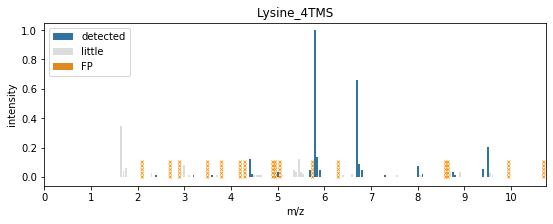


Spectrum C02 - detected peaks: 57
When matched to Lysine_4TMS: 23 matched ions with 0.92281020332912 total confidence
In this match, 22 peaks were not in library spectrum and 24 peaks from library spectrum were missing


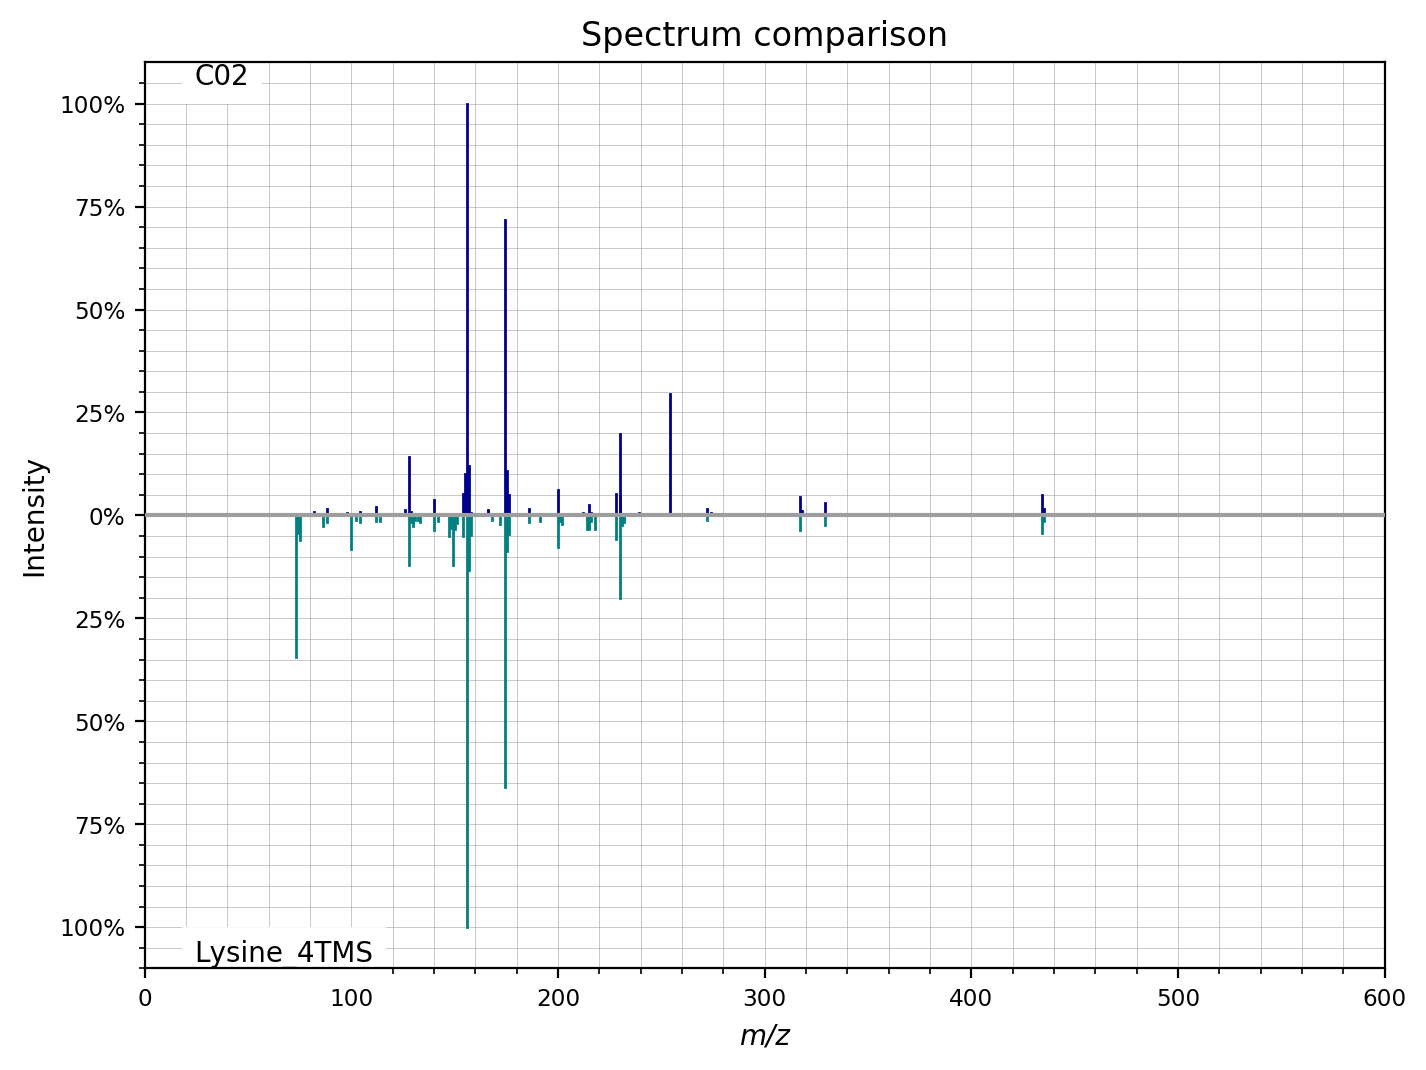

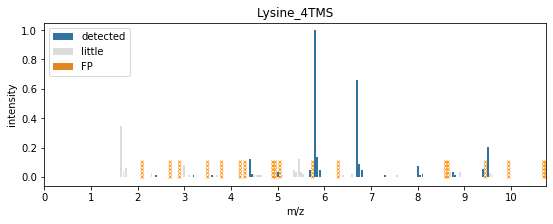

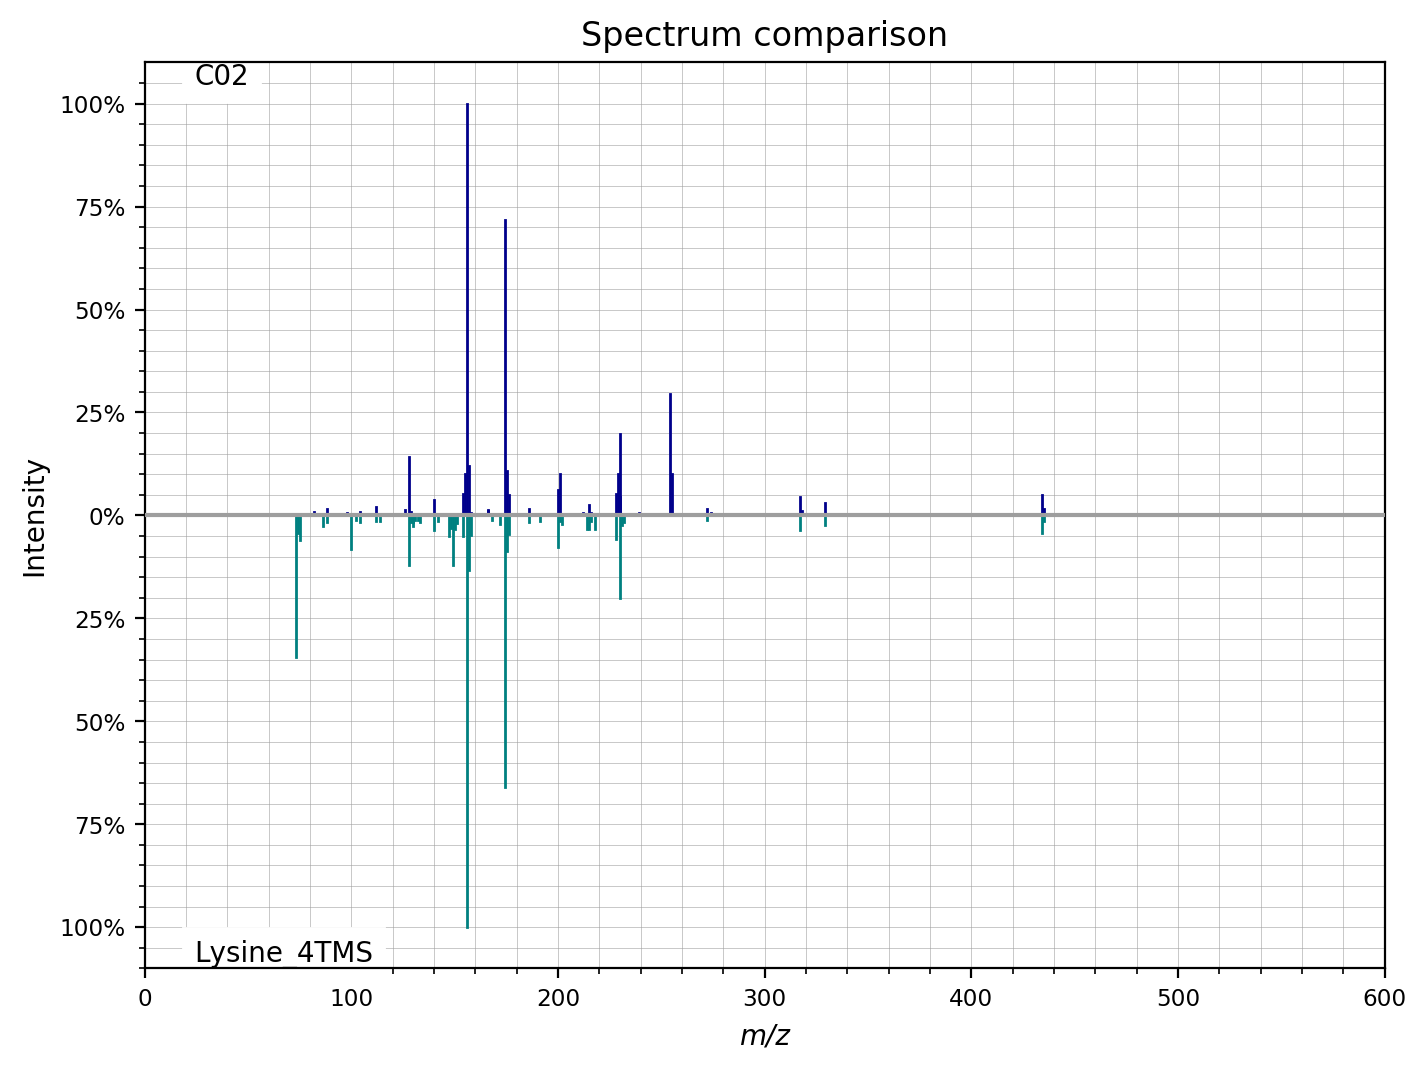

Spectrum C06 - detected peaks: 32
When matched to Fructose_5TMS isomer 2: 18 matched ions with 0.8766808769415186 total confidence
In this match, 12 peaks were not in library spectrum and 24 peaks from library spectrum were missing


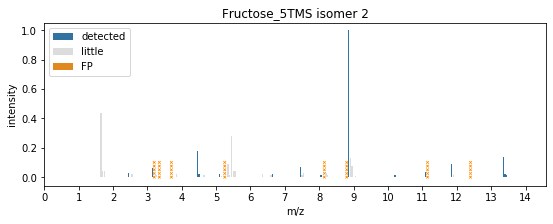


Spectrum C06 - detected peaks: 33
When matched to Fructose_5TMS isomer 2: 18 matched ions with 0.8766808769415186 total confidence
In this match, 12 peaks were not in library spectrum and 23 peaks from library spectrum were missing


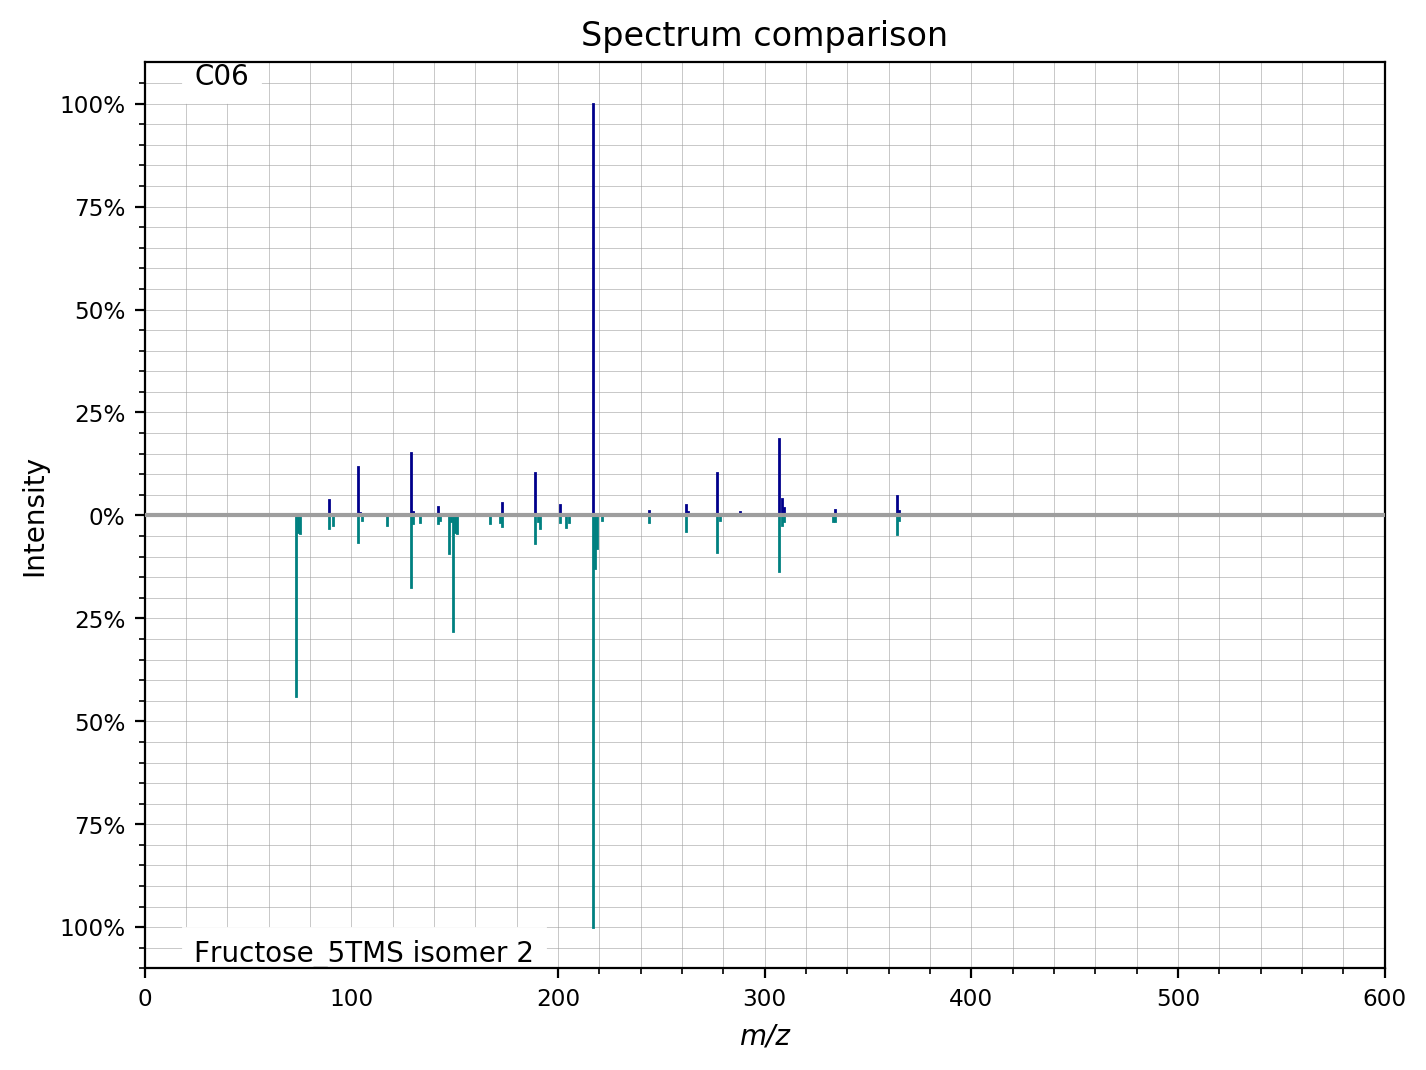

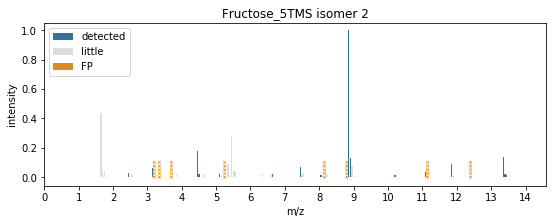

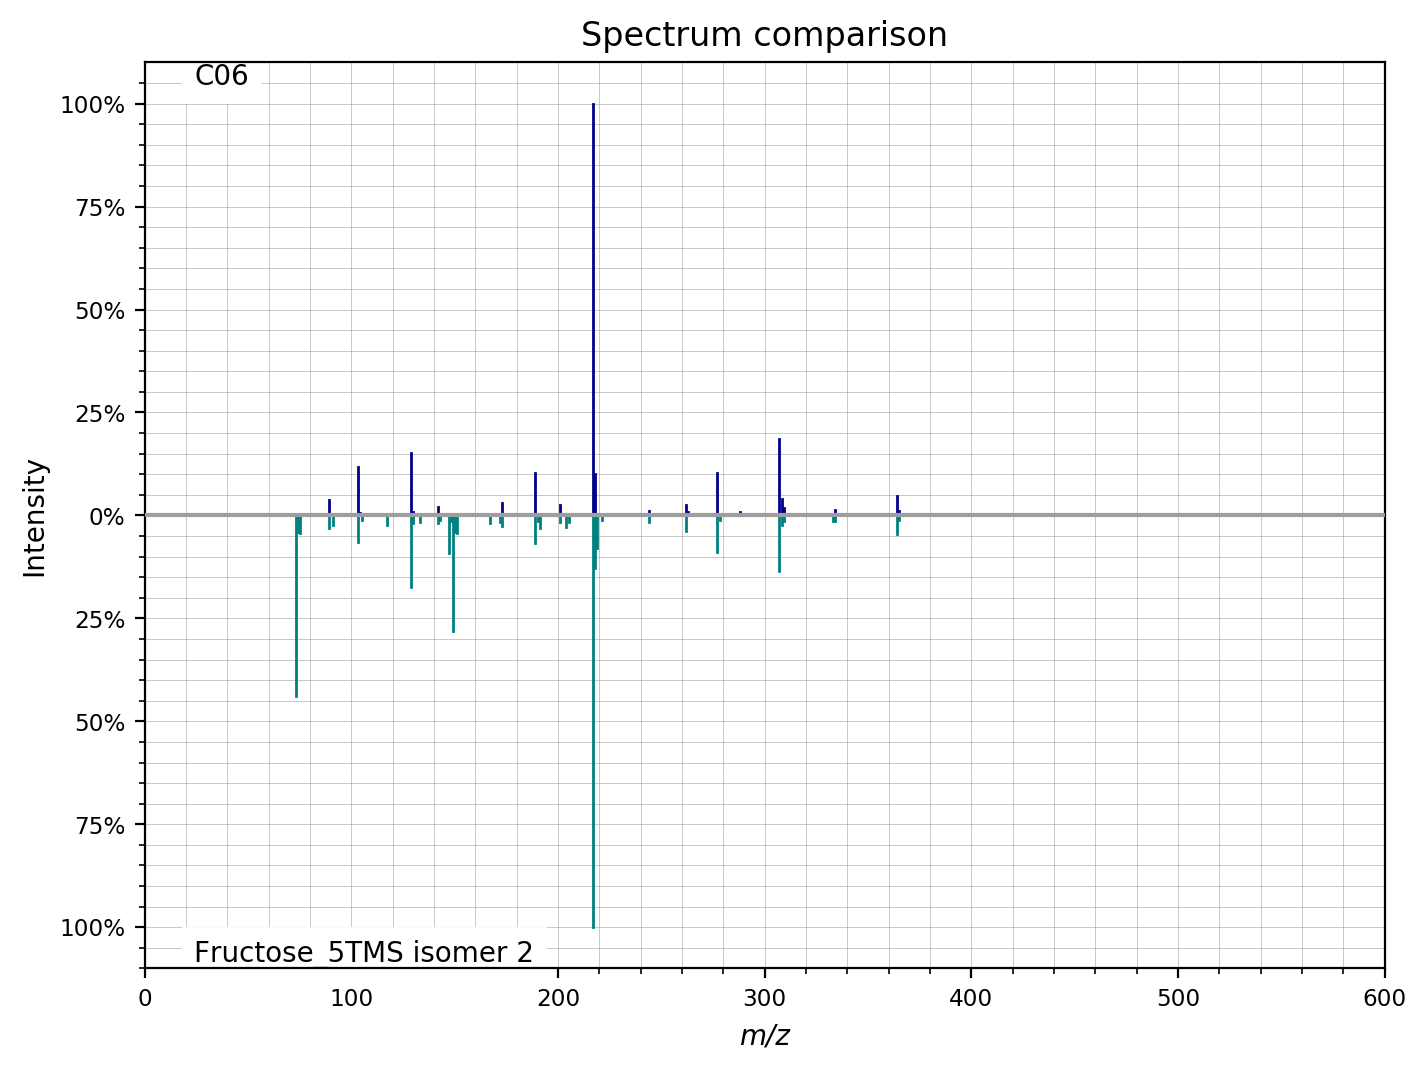

Spectrum C06 - detected peaks: 32
When matched to Fructose_5TMS isomer 1: 15 matched ions with 0.8584115640959713 total confidence
In this match, 14 peaks were not in library spectrum and 25 peaks from library spectrum were missing


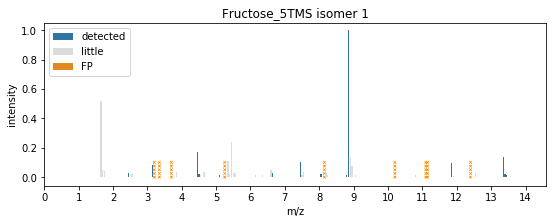


Spectrum C06 - detected peaks: 33
When matched to Fructose_5TMS isomer 1: 15 matched ions with 0.8584115640959713 total confidence
In this match, 14 peaks were not in library spectrum and 24 peaks from library spectrum were missing


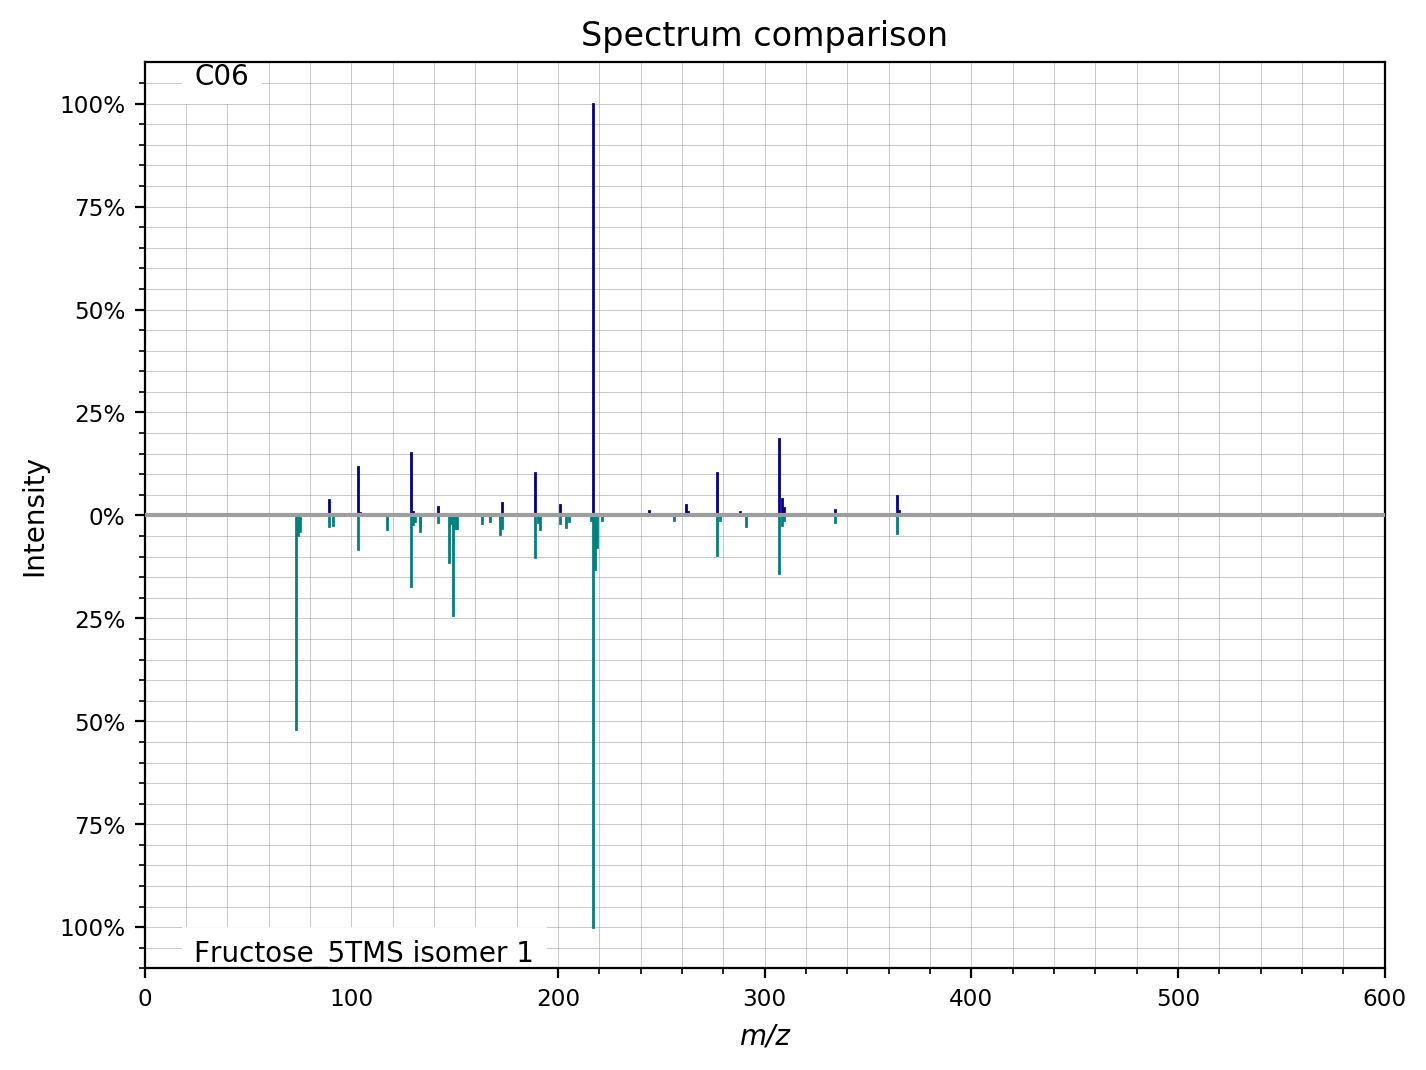

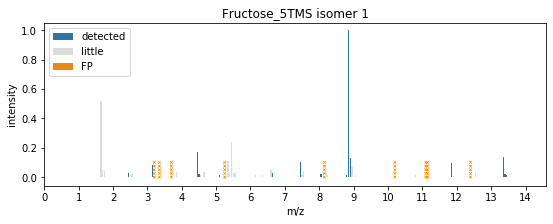

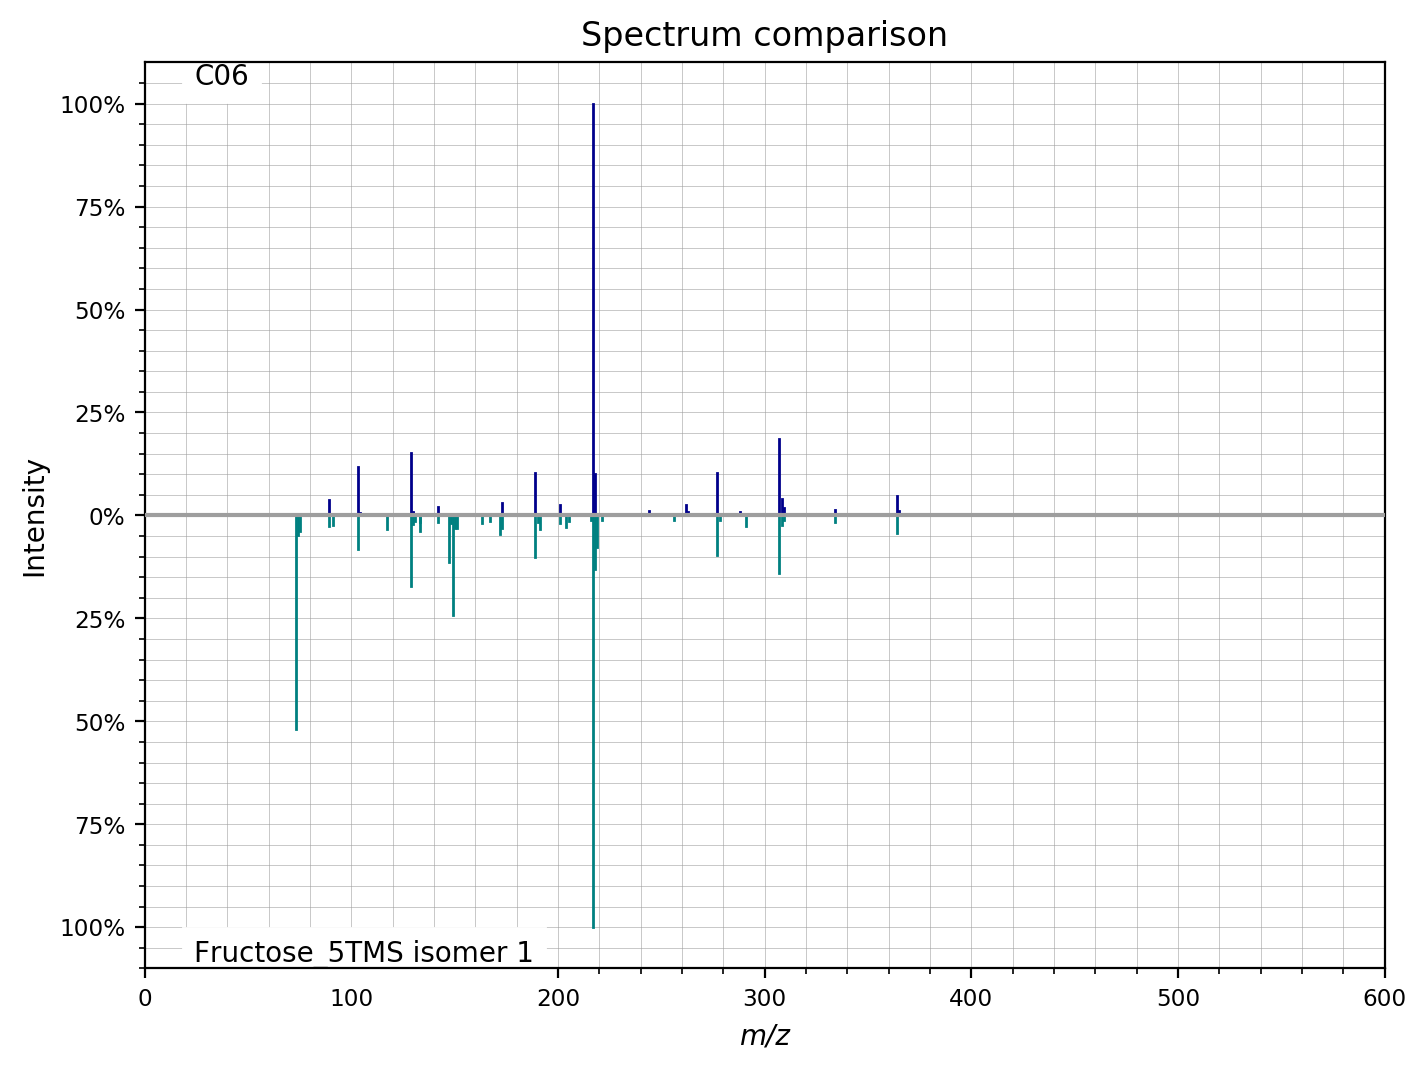

Spectrum C10 - detected peaks: 21
When matched to Myo-inositol_6TMS: 13 matched ions with 0.9155674896314296 total confidence
In this match, 7 peaks were not in library spectrum and 41 peaks from library spectrum were missing


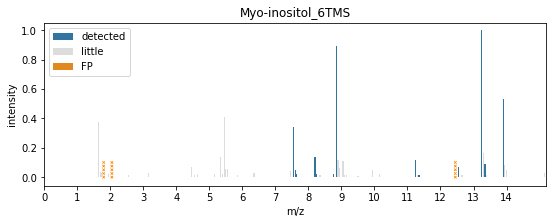


Spectrum C10 - detected peaks: 23
When matched to Myo-inositol_6TMS: 13 matched ions with 0.9155674896314296 total confidence
In this match, 7 peaks were not in library spectrum and 39 peaks from library spectrum were missing


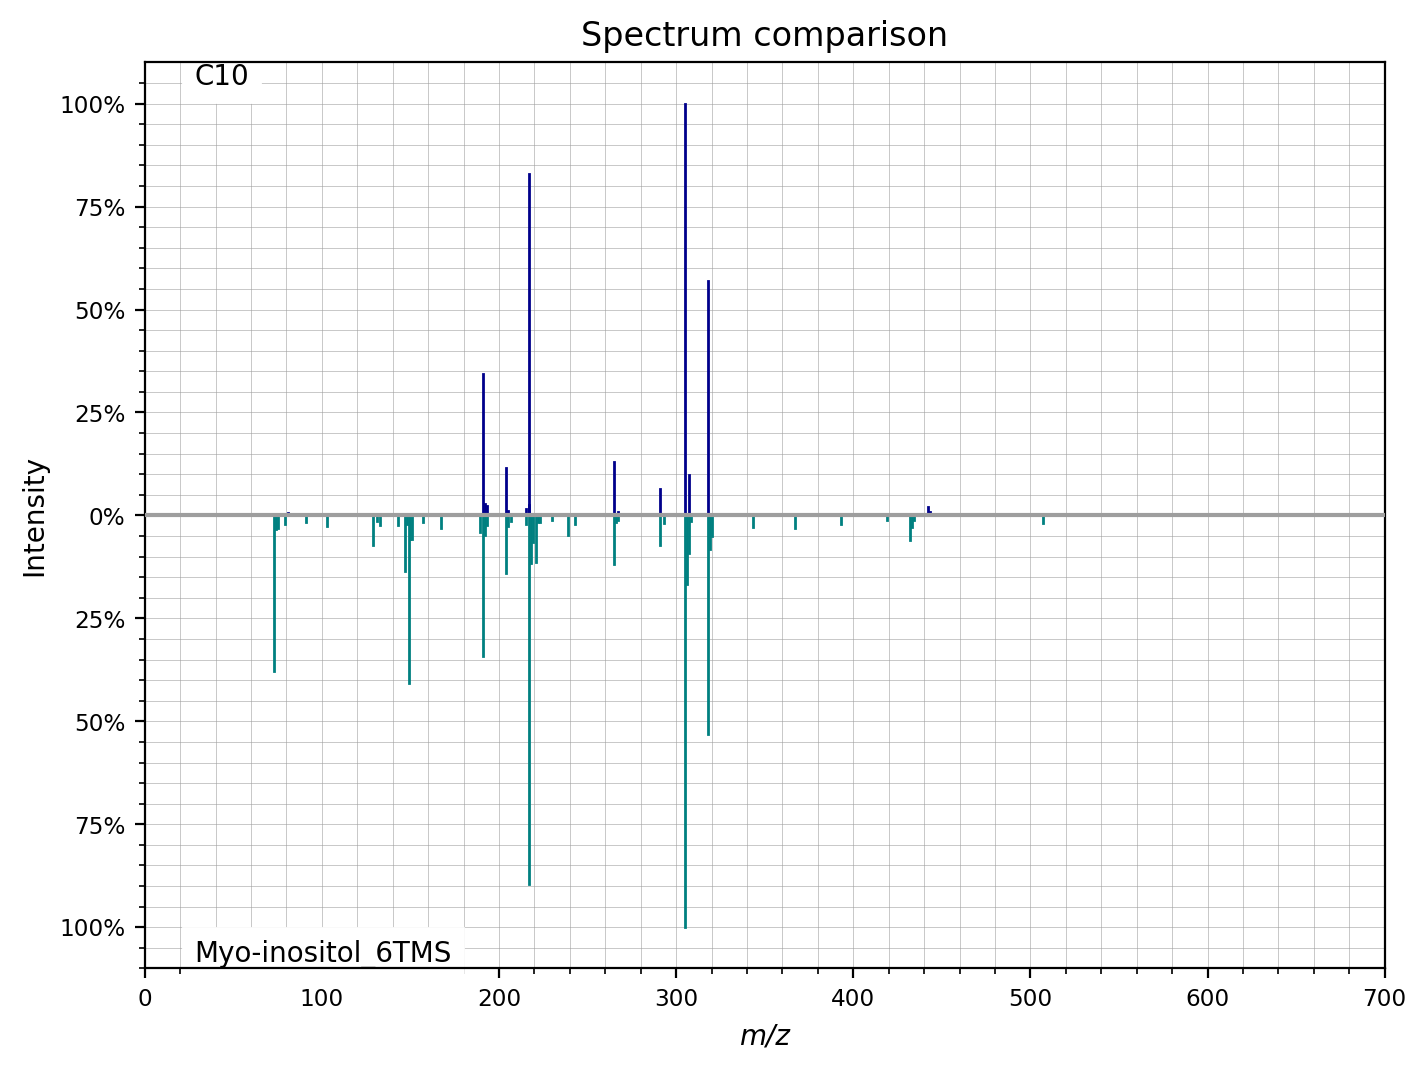

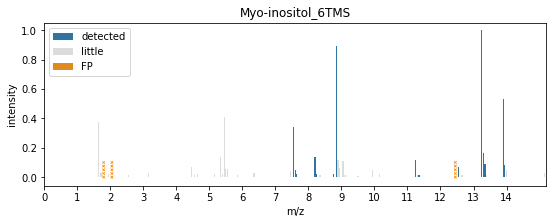

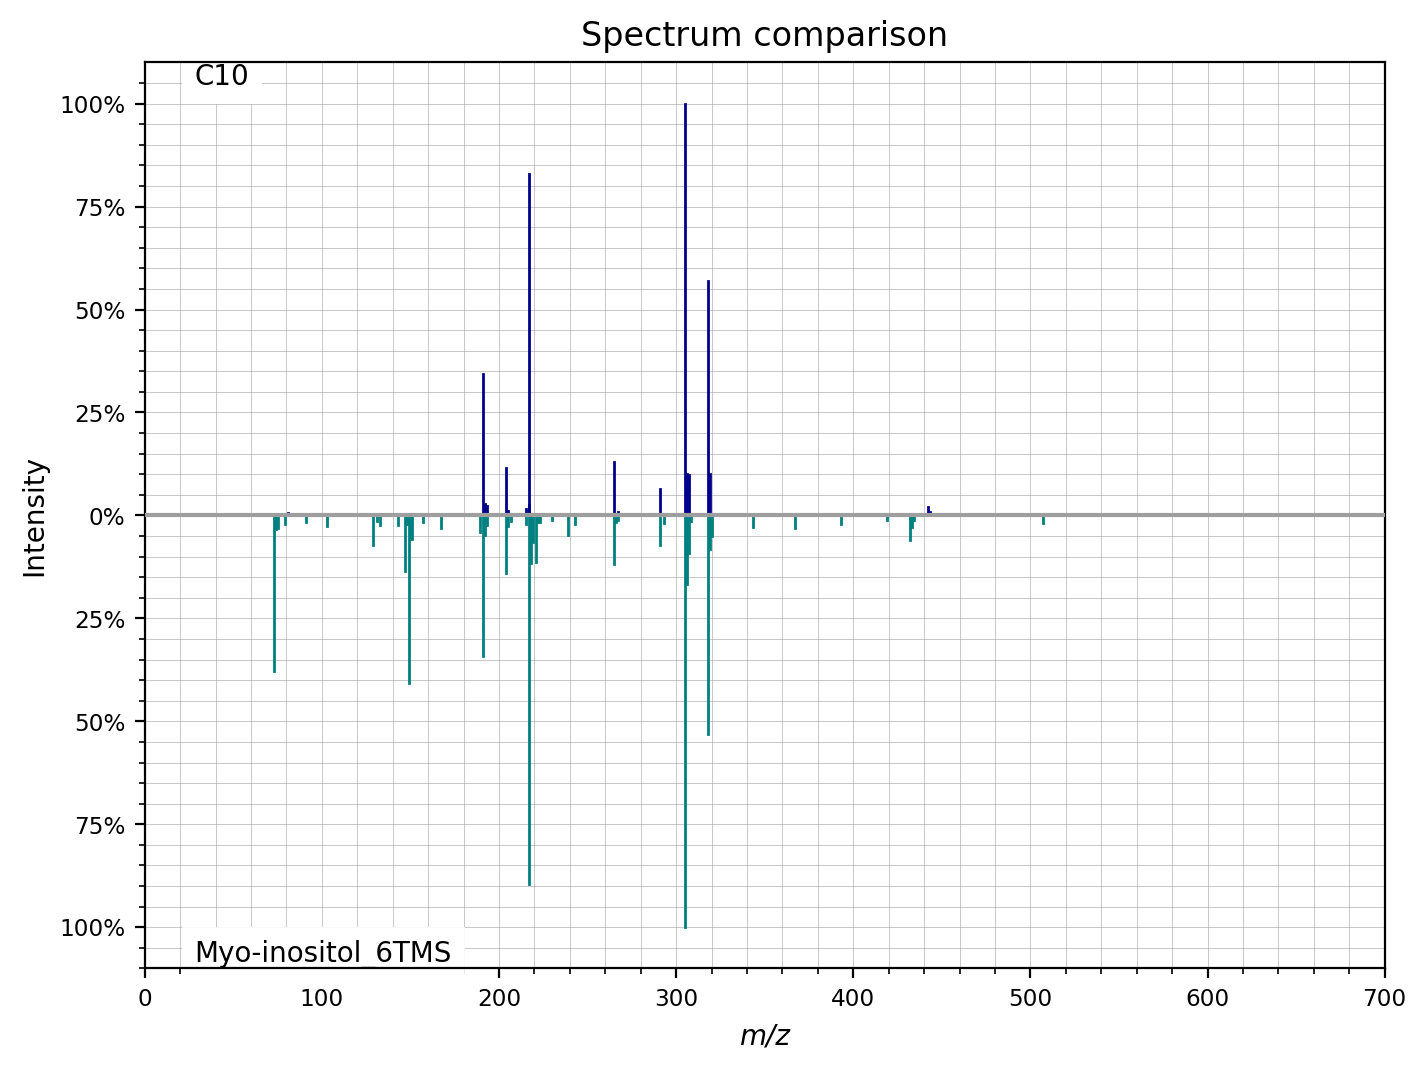

Spectrum C08 - detected peaks: 30
When matched to Citric acid_4TMS: 13 matched ions with 0.8749224326835099 total confidence
In this match, 15 peaks were not in library spectrum and 32 peaks from library spectrum were missing


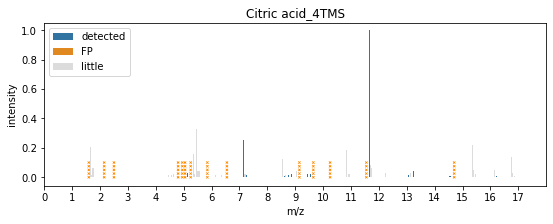


Spectrum C08 - detected peaks: 31
When matched to Citric acid_4TMS: 13 matched ions with 0.8749224326835099 total confidence
In this match, 15 peaks were not in library spectrum and 31 peaks from library spectrum were missing


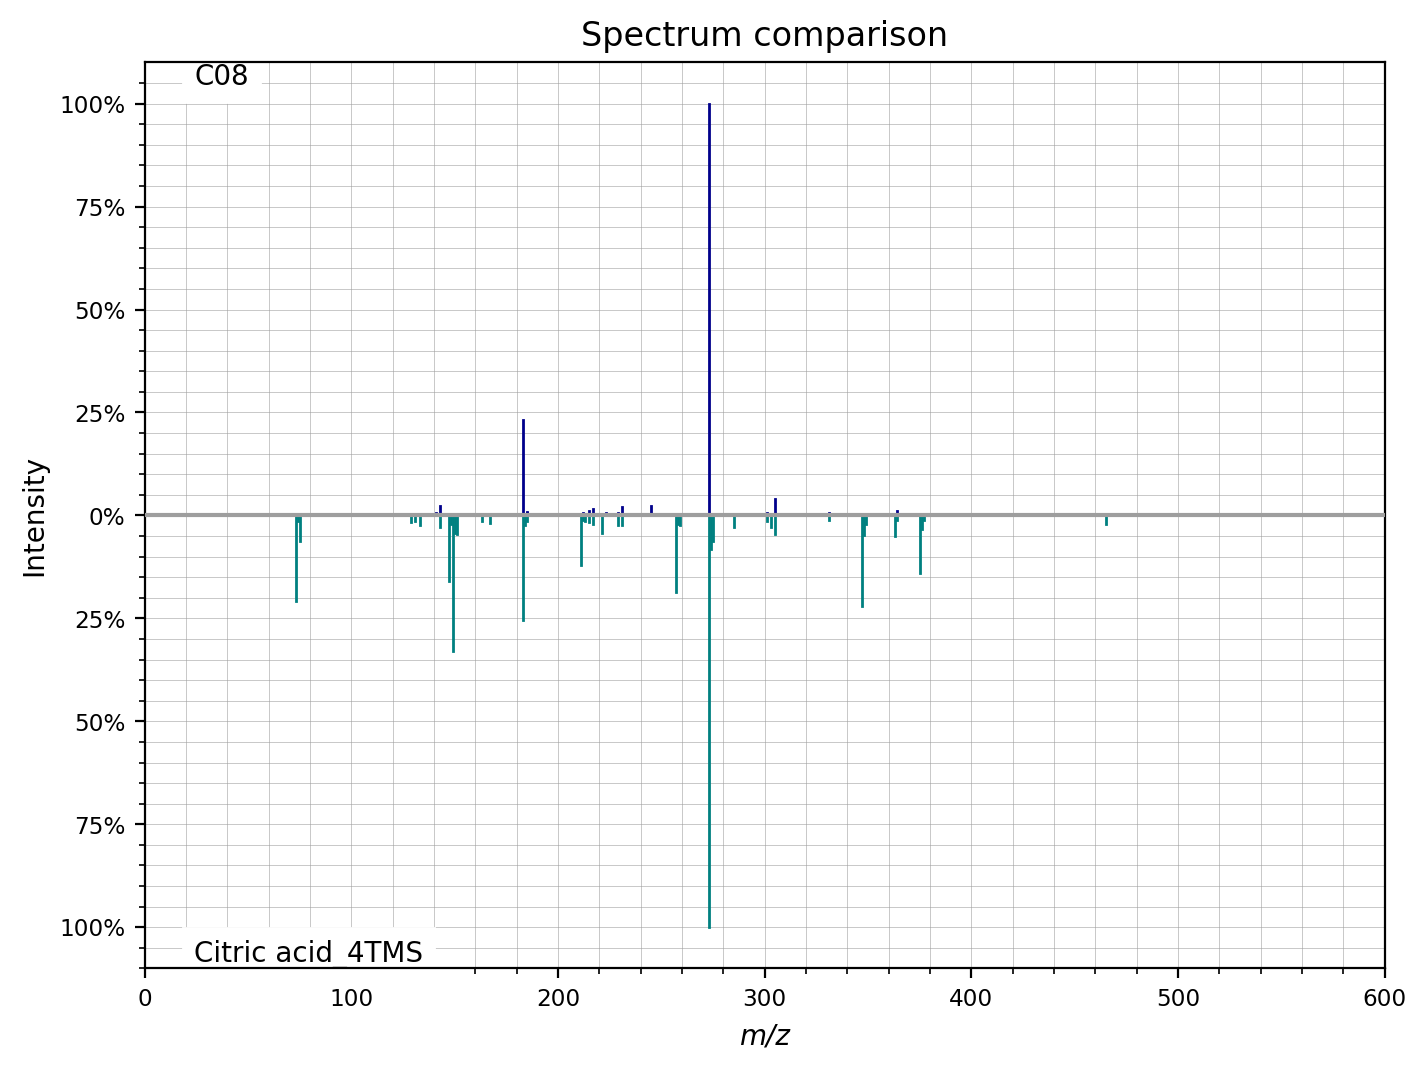

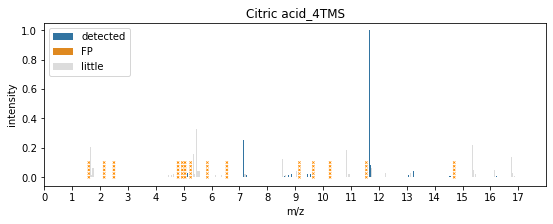

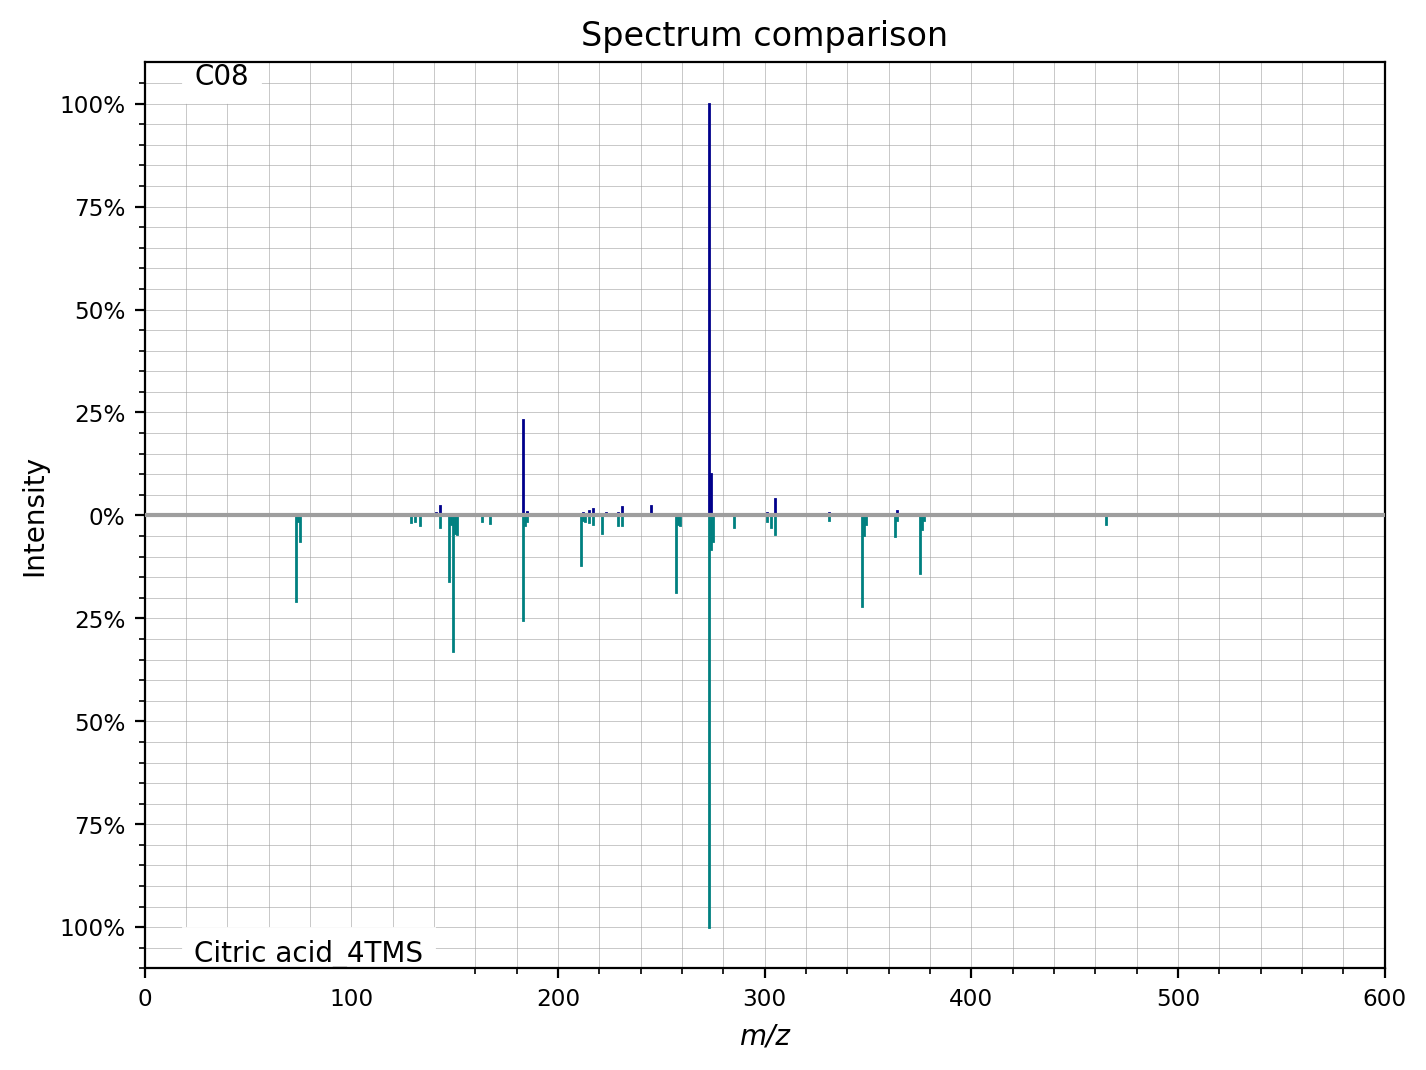

Spectrum C16 - detected peaks: 14
When matched to Uridine_4TMS isomer 1: 12 matched ions with 0.6025062983867928 total confidence
In this match, 0 peaks were not in library spectrum and 75 peaks from library spectrum were missing


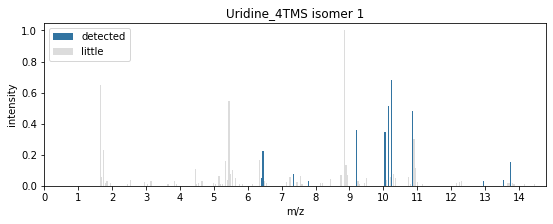


Spectrum C16 - detected peaks: 18
When matched to Uridine_4TMS isomer 1: 12 matched ions with 0.6025062983867928 total confidence
In this match, 1 peaks were not in library spectrum and 72 peaks from library spectrum were missing


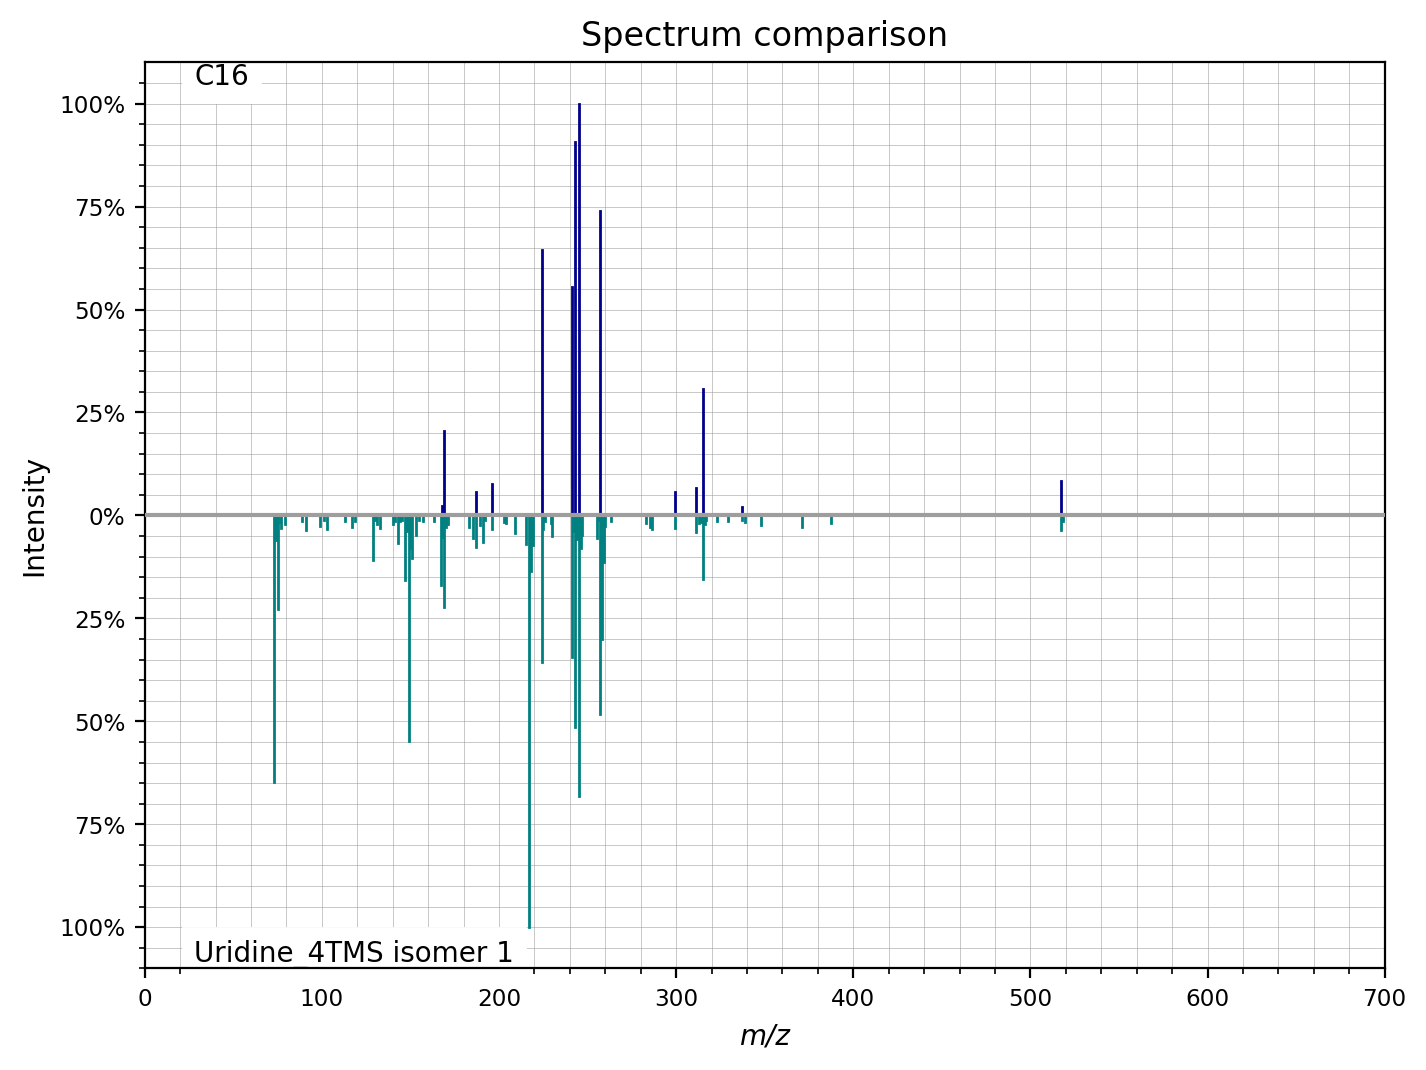

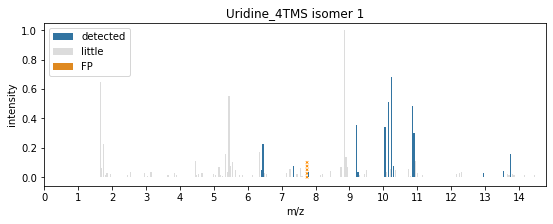

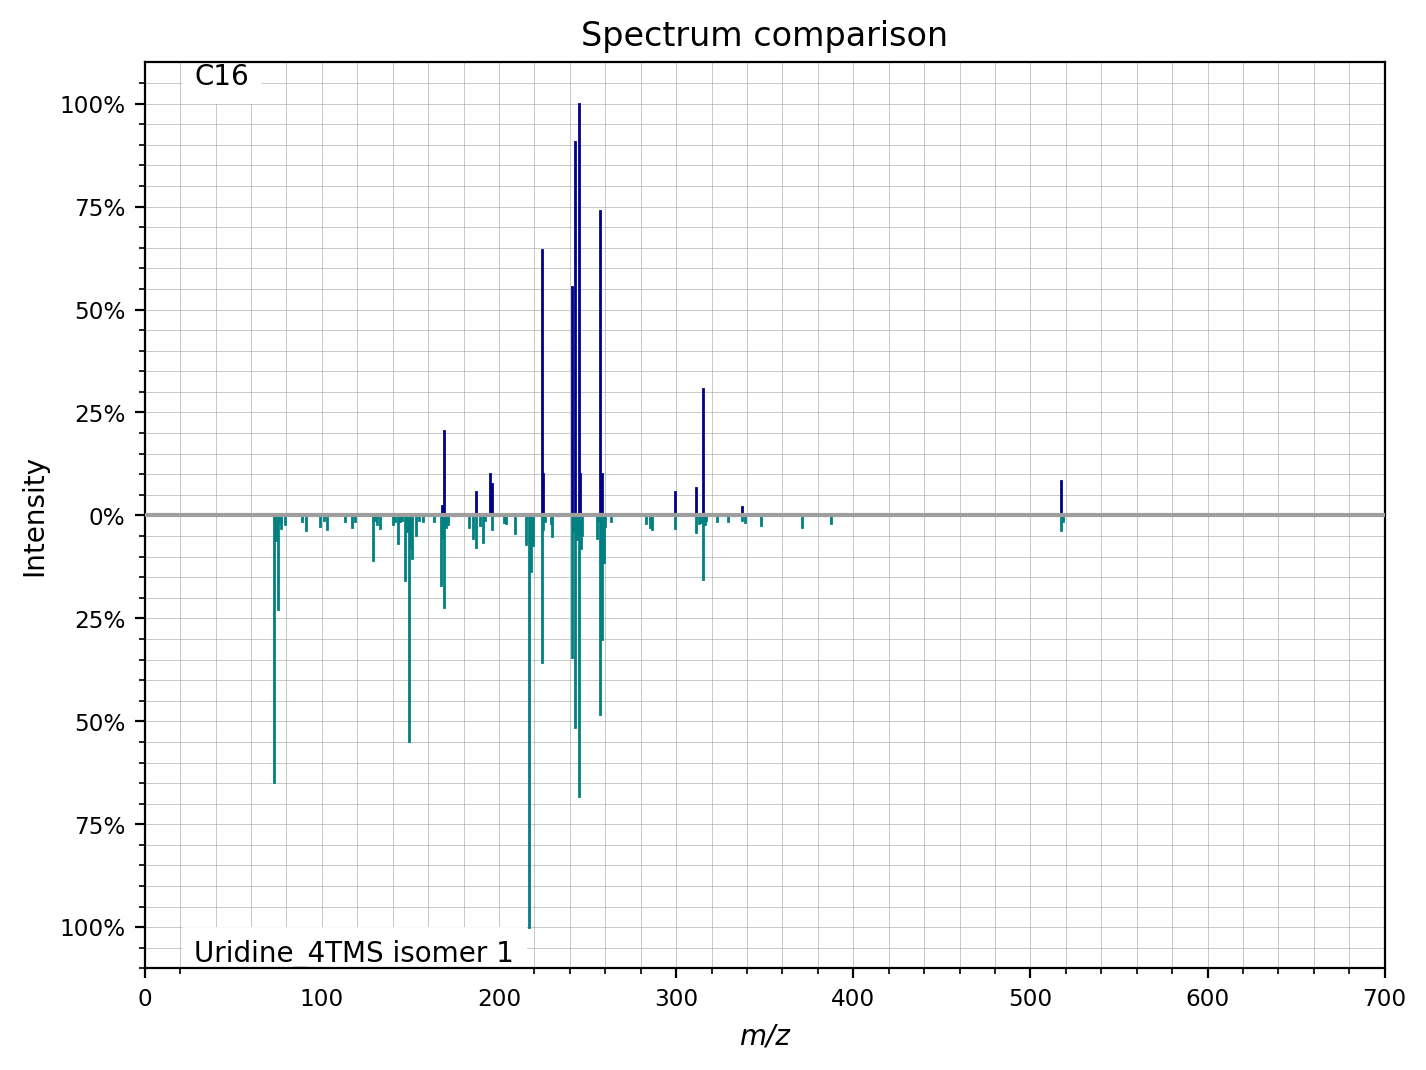

Spectrum C06 - detected peaks: 32
When matched to Xylose_4TMS: 11 matched ions with 0.8140434072629077 total confidence
In this match, 18 peaks were not in library spectrum and 29 peaks from library spectrum were missing


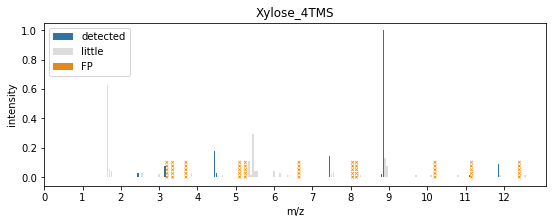


Spectrum C06 - detected peaks: 33
When matched to Xylose_4TMS: 11 matched ions with 0.8140434072629077 total confidence
In this match, 18 peaks were not in library spectrum and 28 peaks from library spectrum were missing


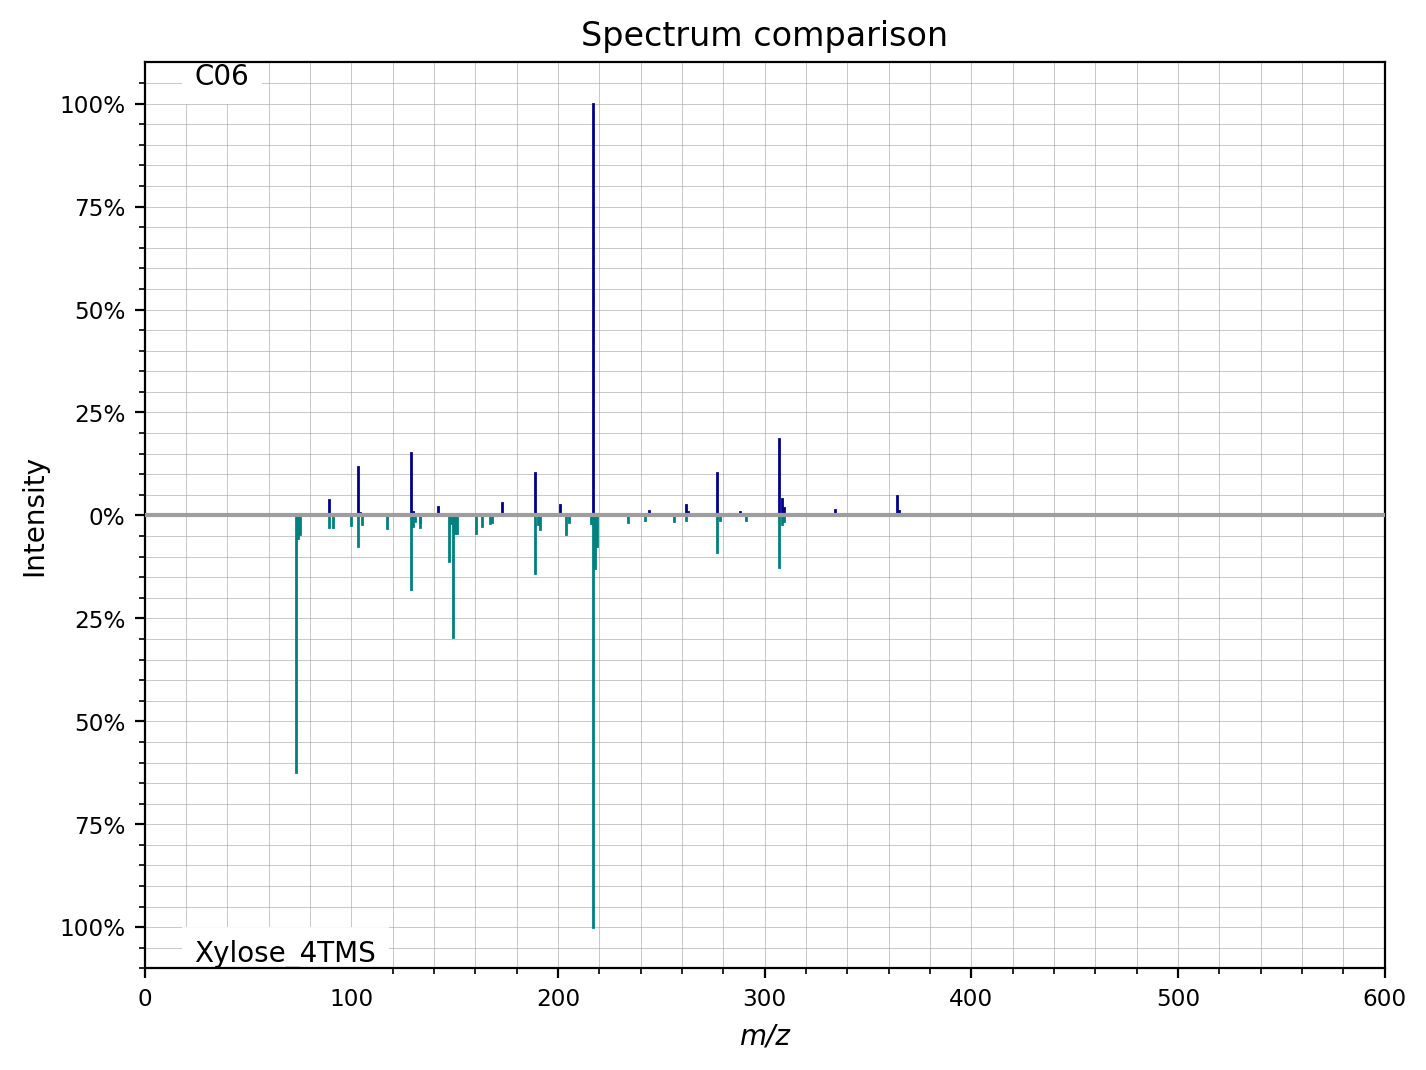

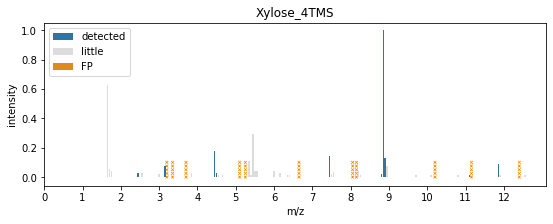

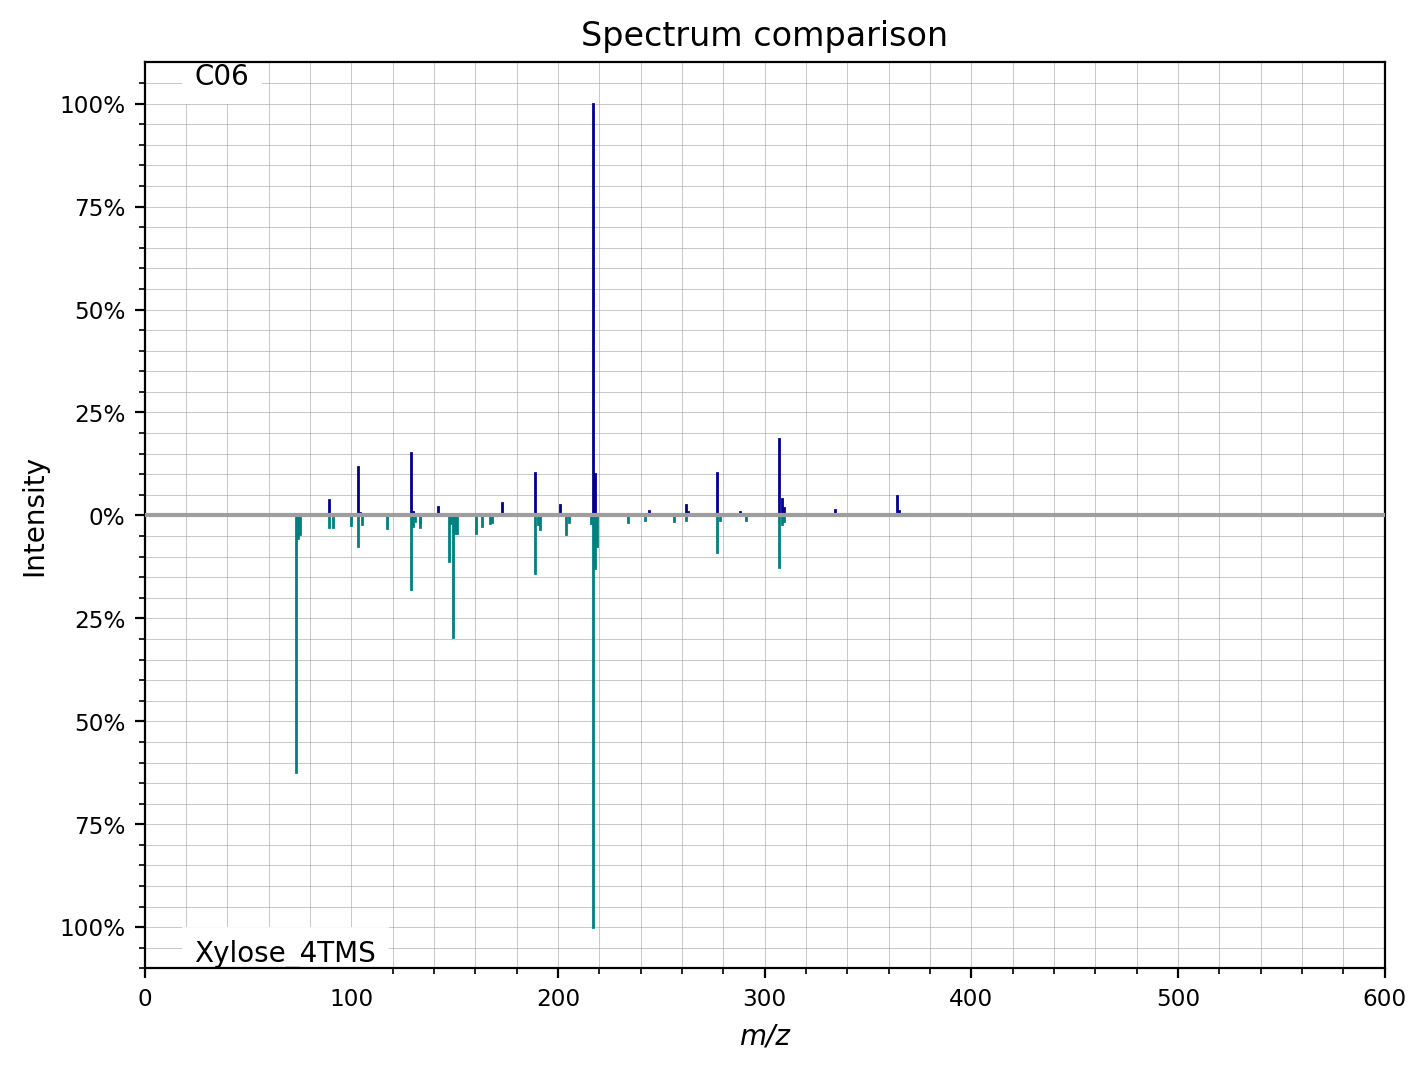

Spectrum C06 - detected peaks: 32
When matched to Ribose_4TMS: 11 matched ions with 0.8566412457759247 total confidence
In this match, 17 peaks were not in library spectrum and 24 peaks from library spectrum were missing


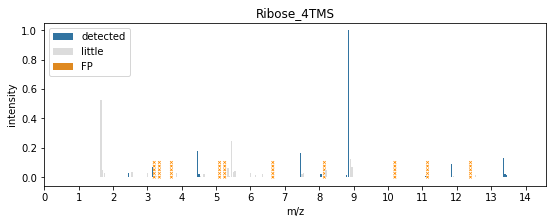


Spectrum C06 - detected peaks: 33
When matched to Ribose_4TMS: 11 matched ions with 0.8566412457759247 total confidence
In this match, 17 peaks were not in library spectrum and 23 peaks from library spectrum were missing


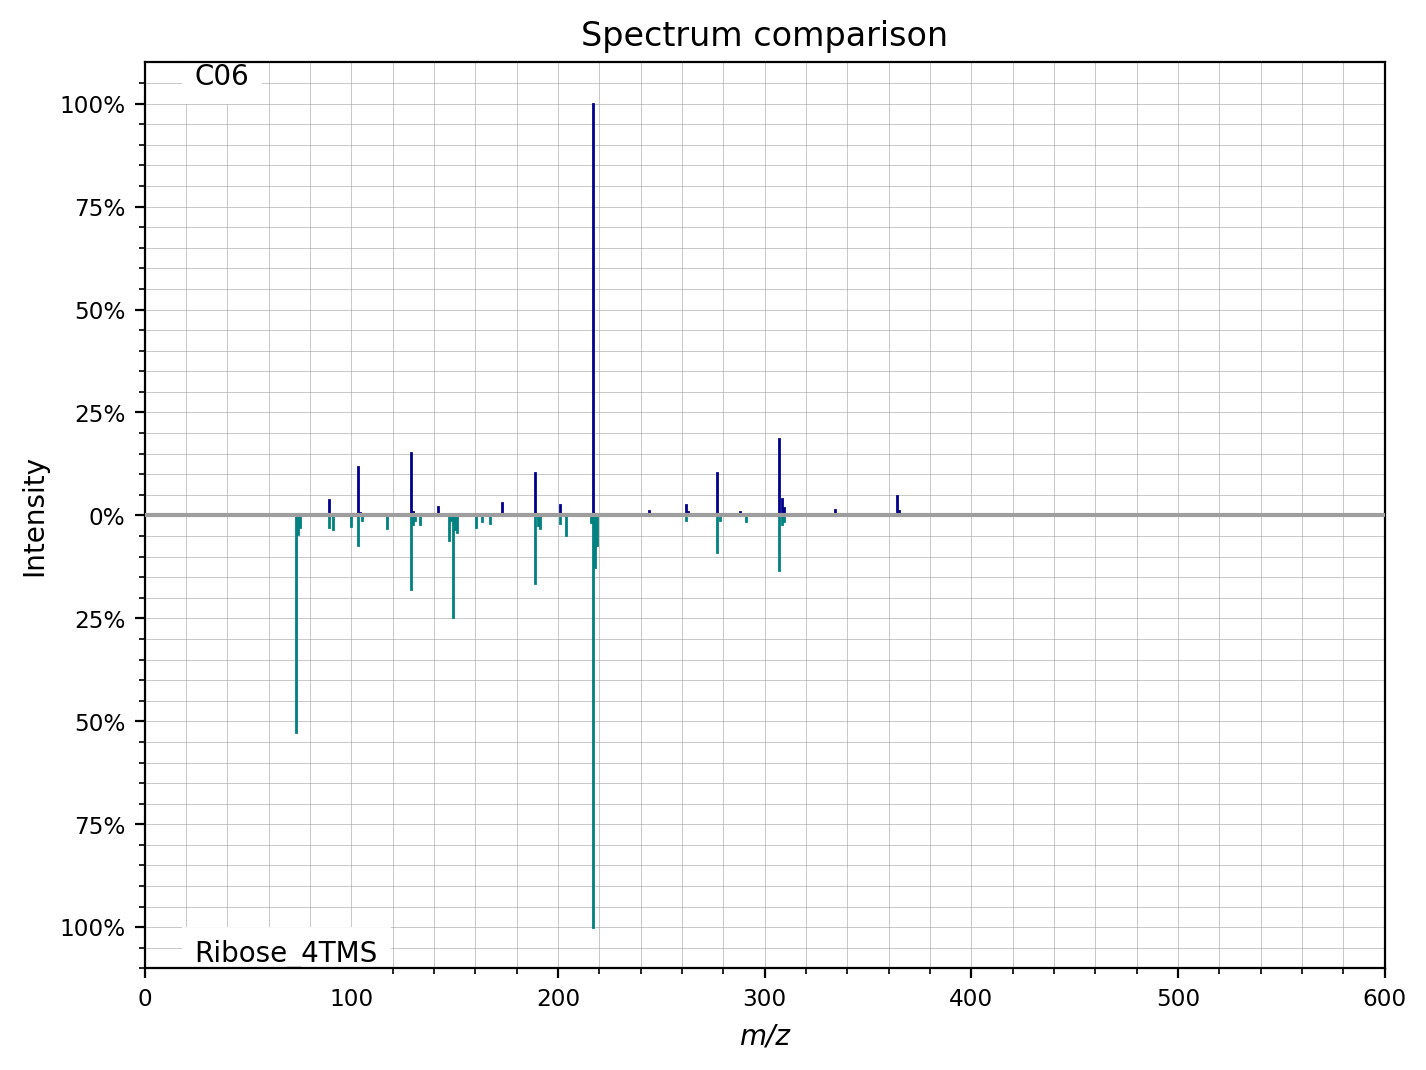

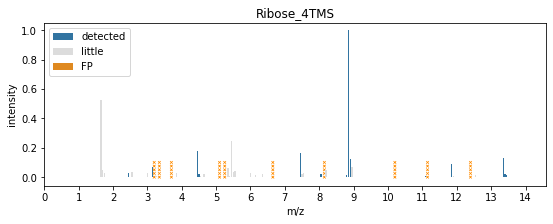

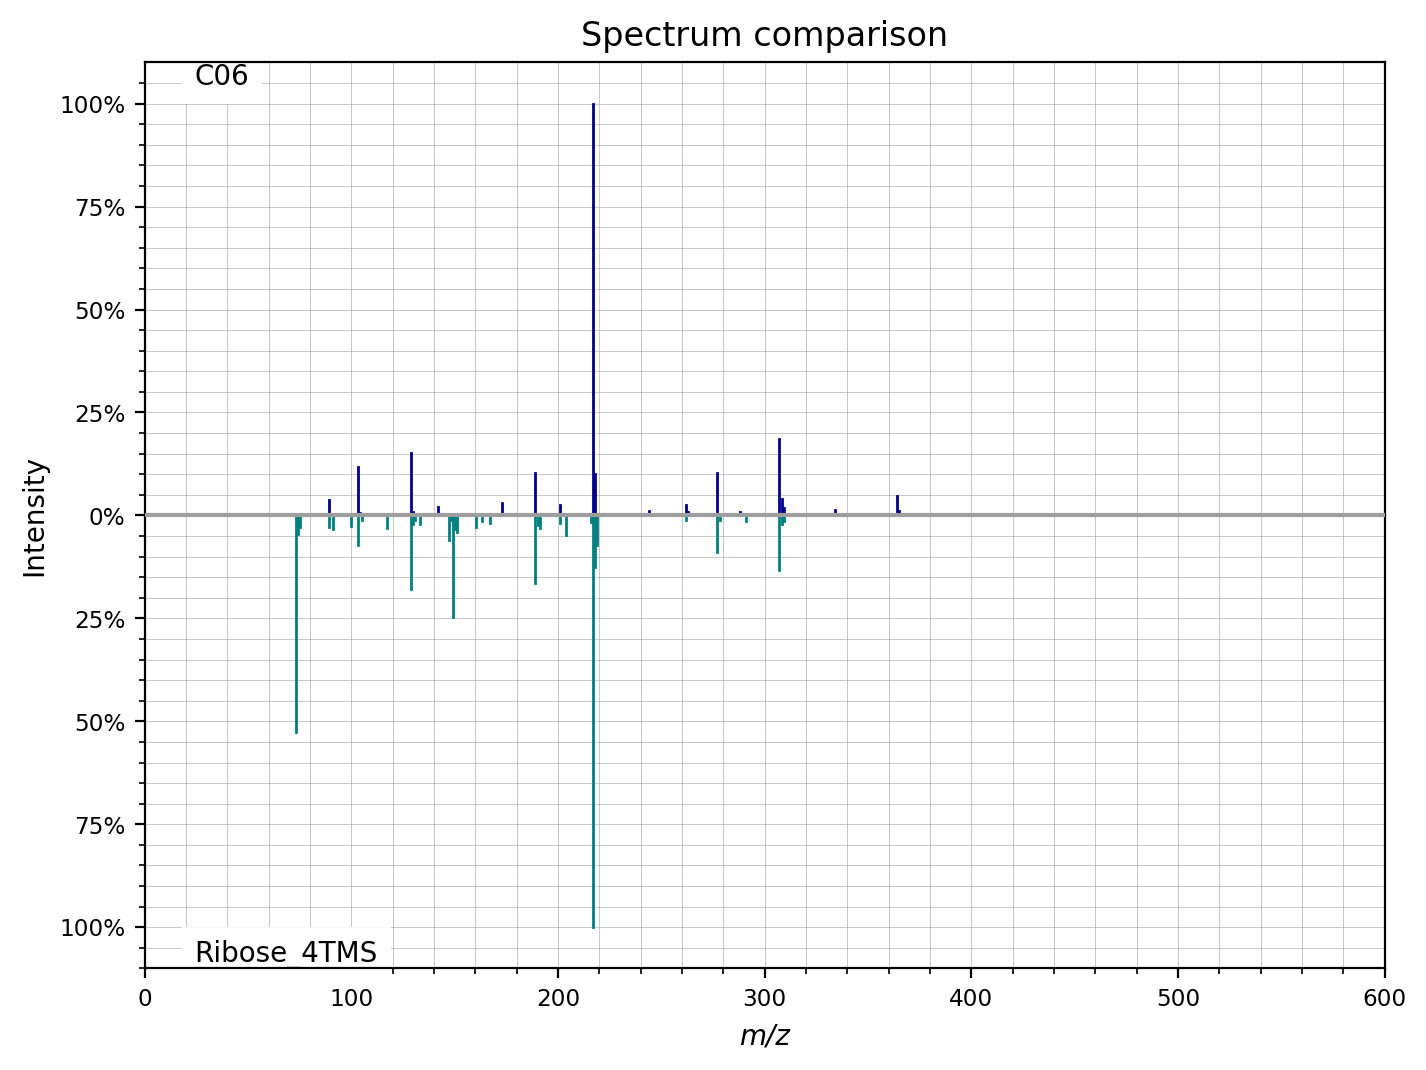

Spectrum C06 - detected peaks: 32
When matched to Arabitol_5TMS: 10 matched ions with 0.7972294938455029 total confidence
In this match, 20 peaks were not in library spectrum and 33 peaks from library spectrum were missing


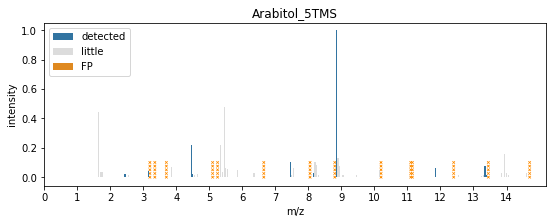


Spectrum C06 - detected peaks: 33
When matched to Arabitol_5TMS: 10 matched ions with 0.7972294938455029 total confidence
In this match, 20 peaks were not in library spectrum and 32 peaks from library spectrum were missing


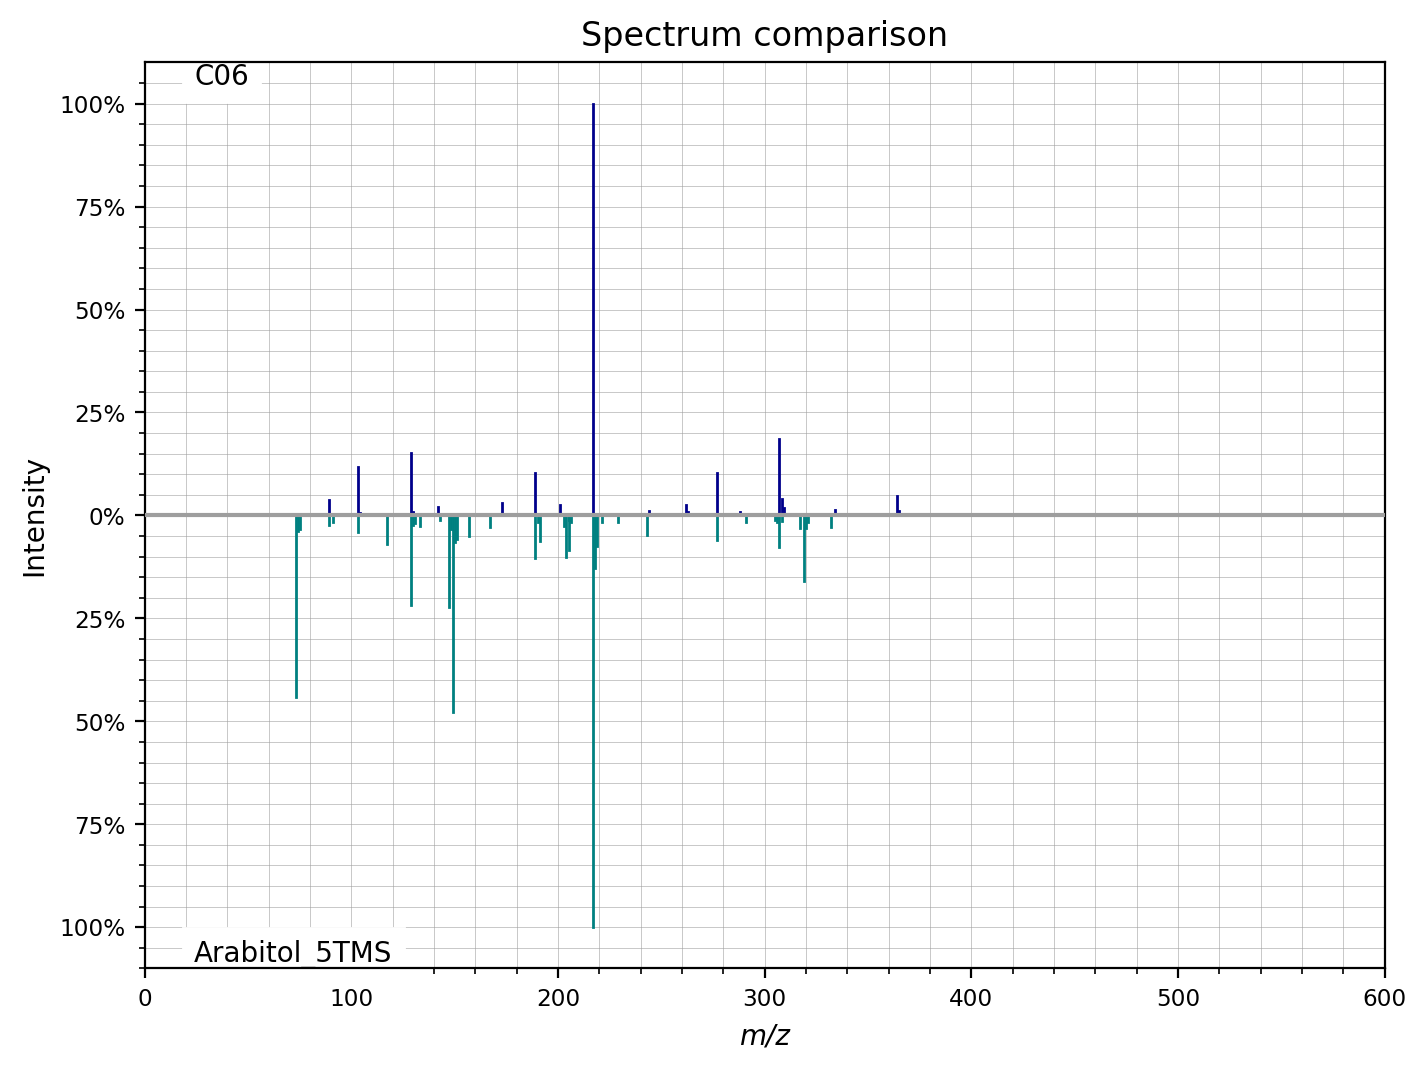

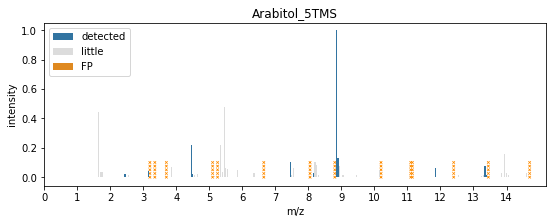

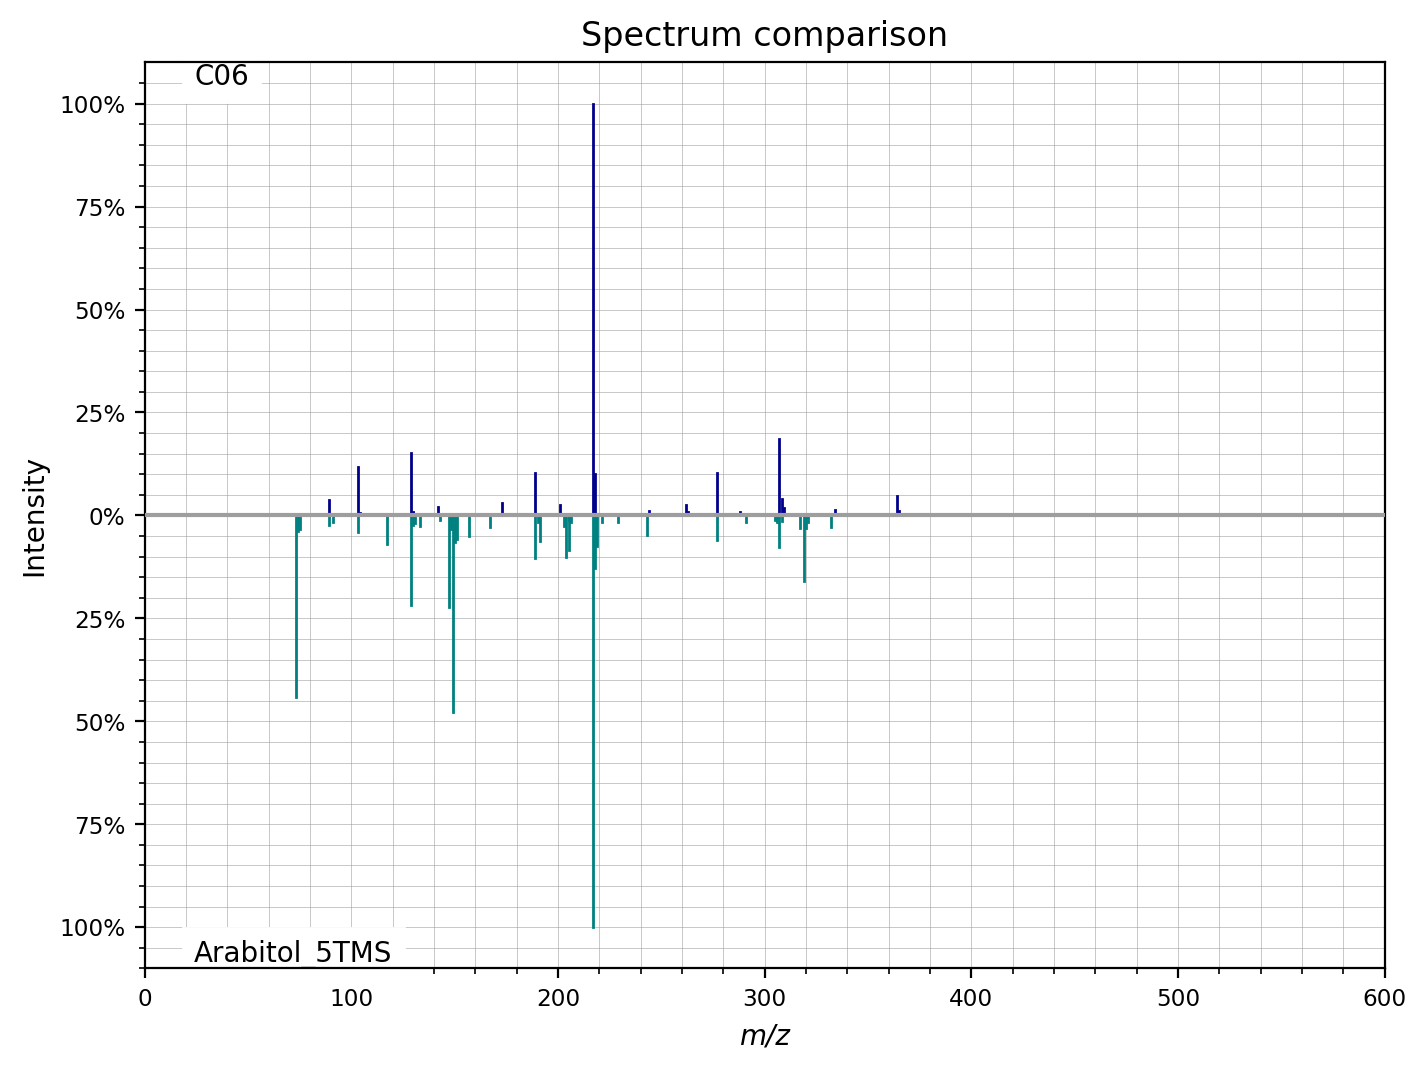

Spectrum C06 - detected peaks: 32
When matched to Arabitol_5TMS: 10 matched ions with 0.796552247937575 total confidence
In this match, 20 peaks were not in library spectrum and 33 peaks from library spectrum were missing


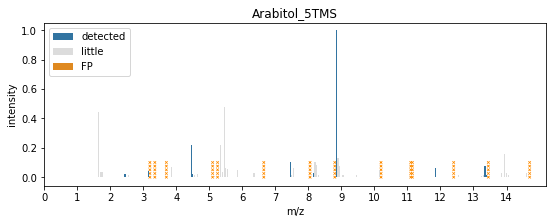


Spectrum C06 - detected peaks: 33
When matched to Arabitol_5TMS: 10 matched ions with 0.796552247937575 total confidence
In this match, 20 peaks were not in library spectrum and 32 peaks from library spectrum were missing


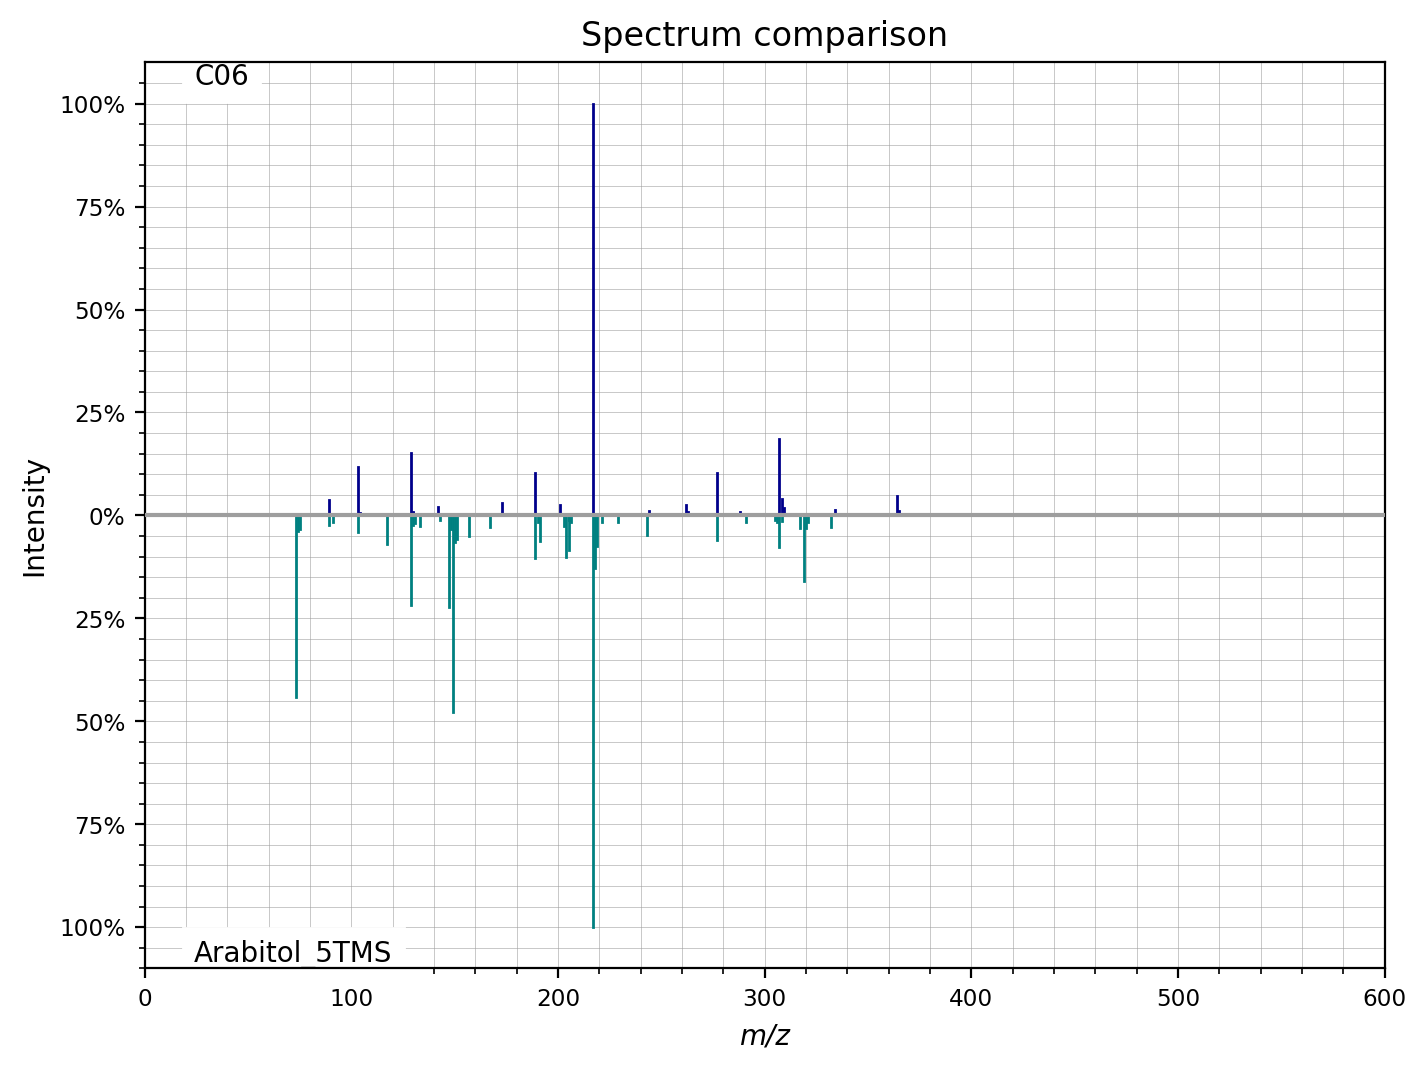

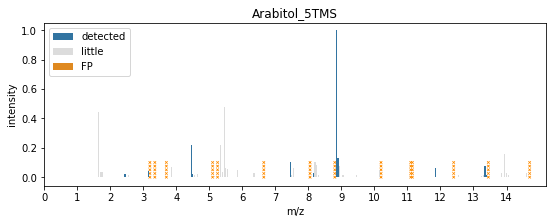

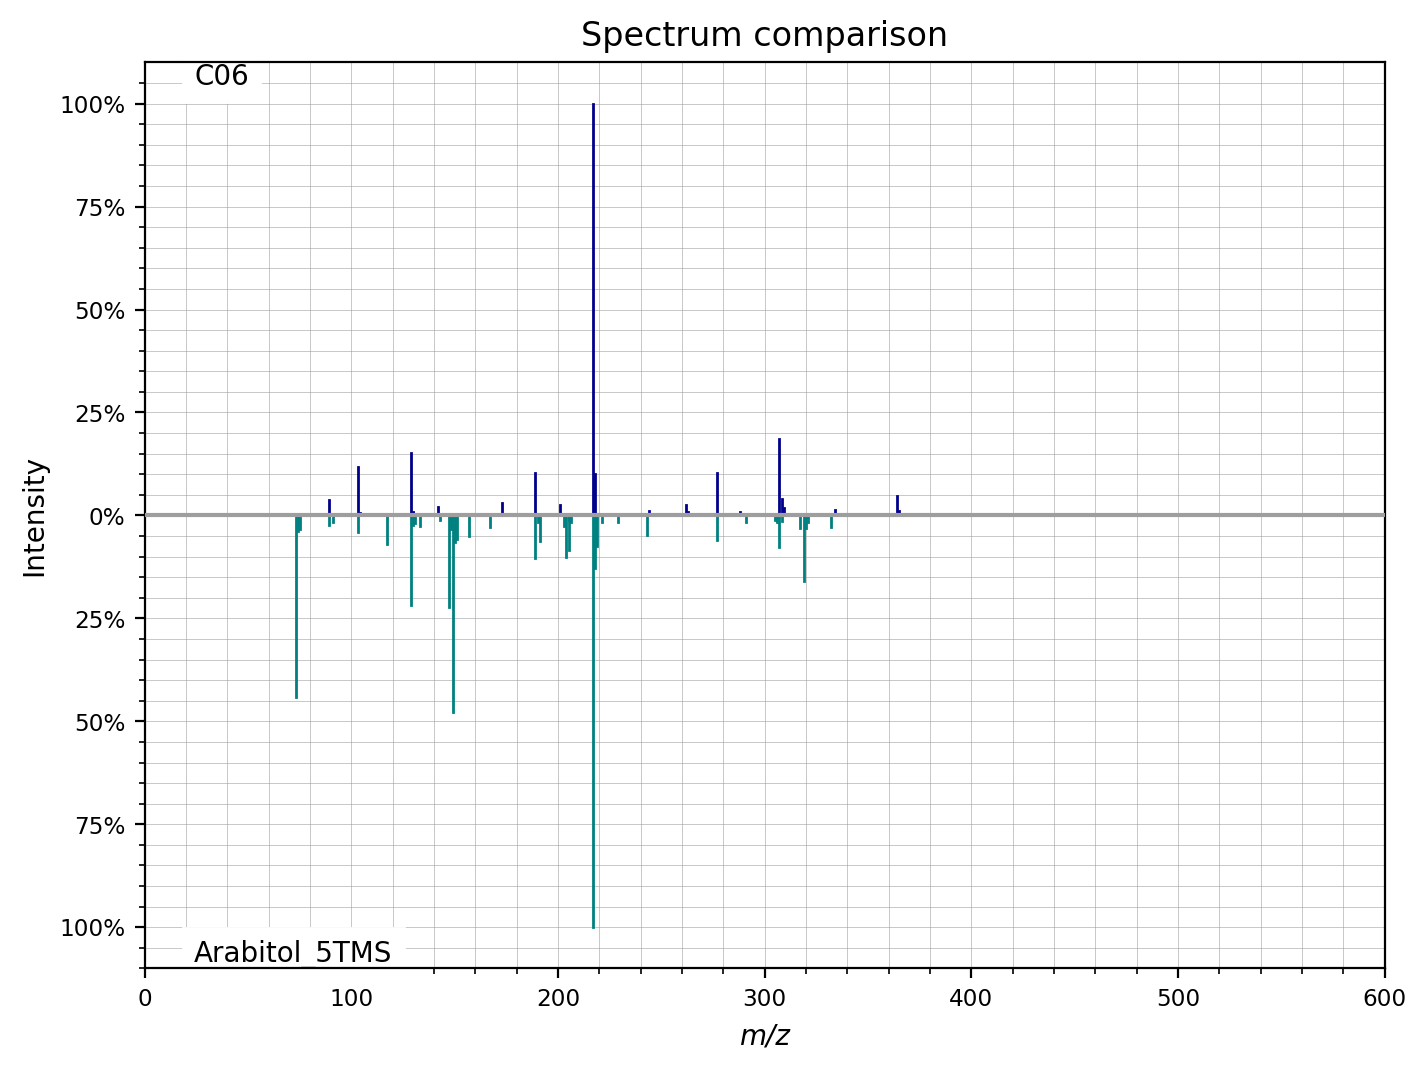

Spectrum C06 - detected peaks: 32
When matched to Arabitol_5TMS: 9 matched ions with 0.7972294938455029 total confidence
In this match, 20 peaks were not in library spectrum and 33 peaks from library spectrum were missing


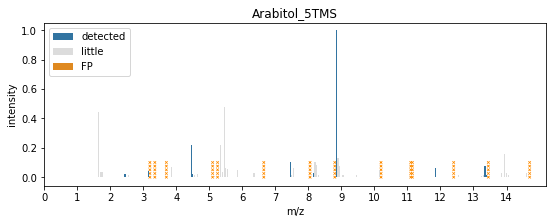


Spectrum C06 - detected peaks: 33
When matched to Arabitol_5TMS: 9 matched ions with 0.7972294938455029 total confidence
In this match, 20 peaks were not in library spectrum and 32 peaks from library spectrum were missing


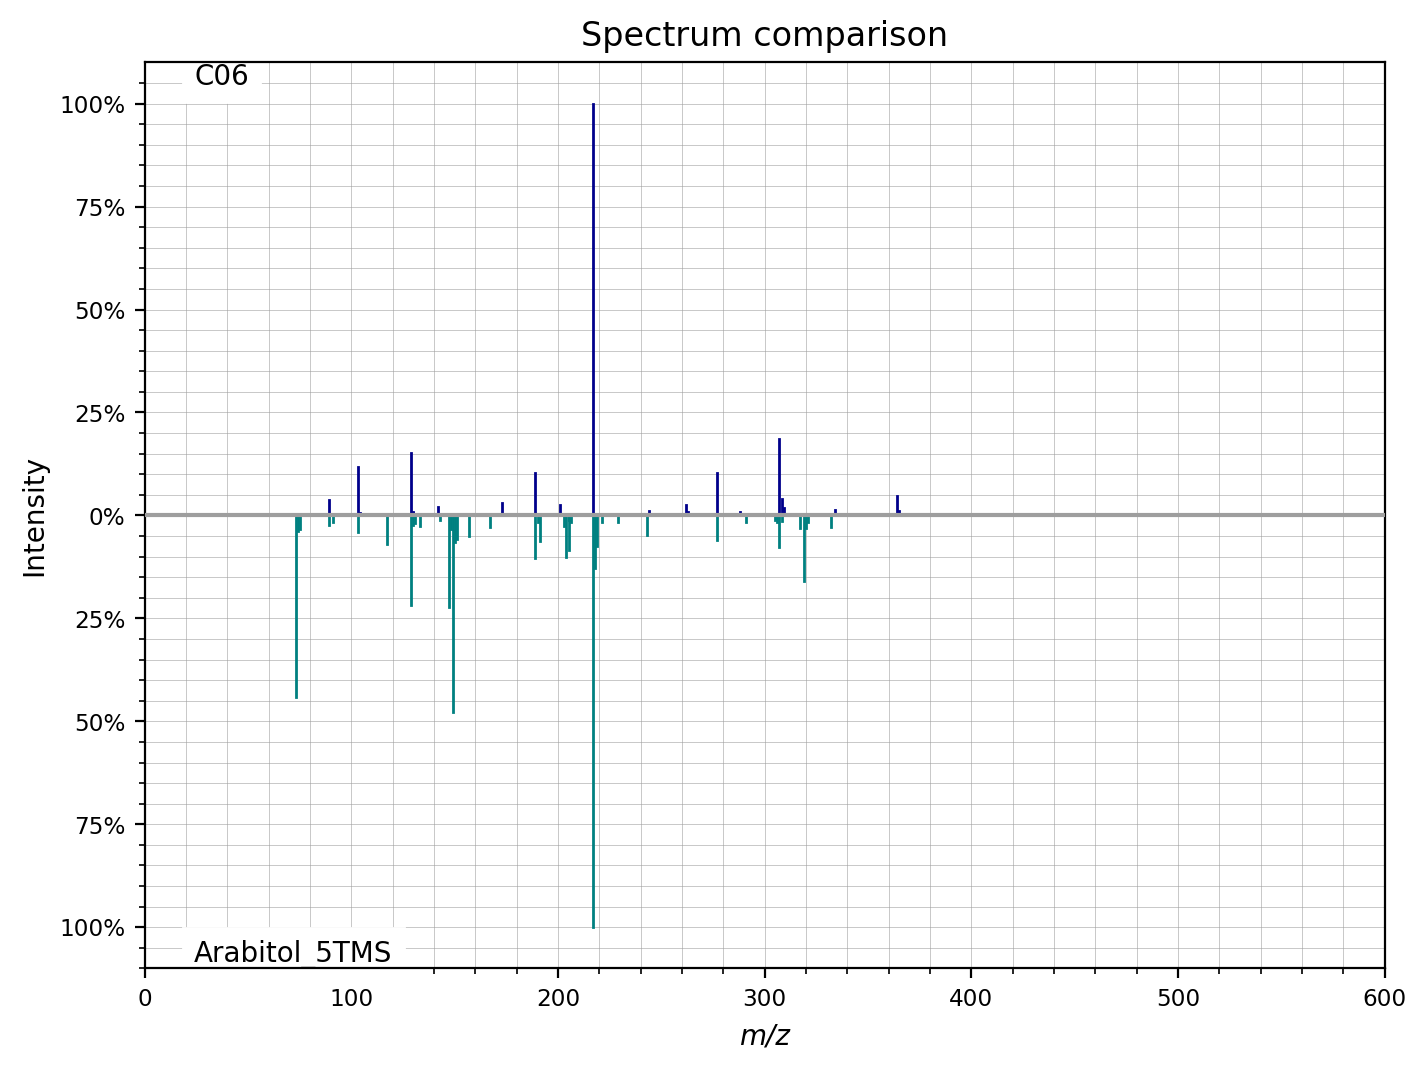

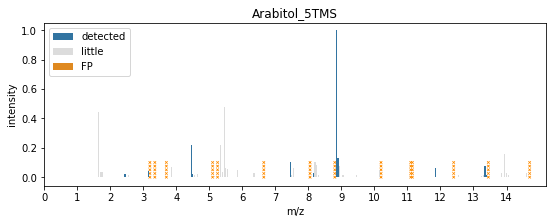

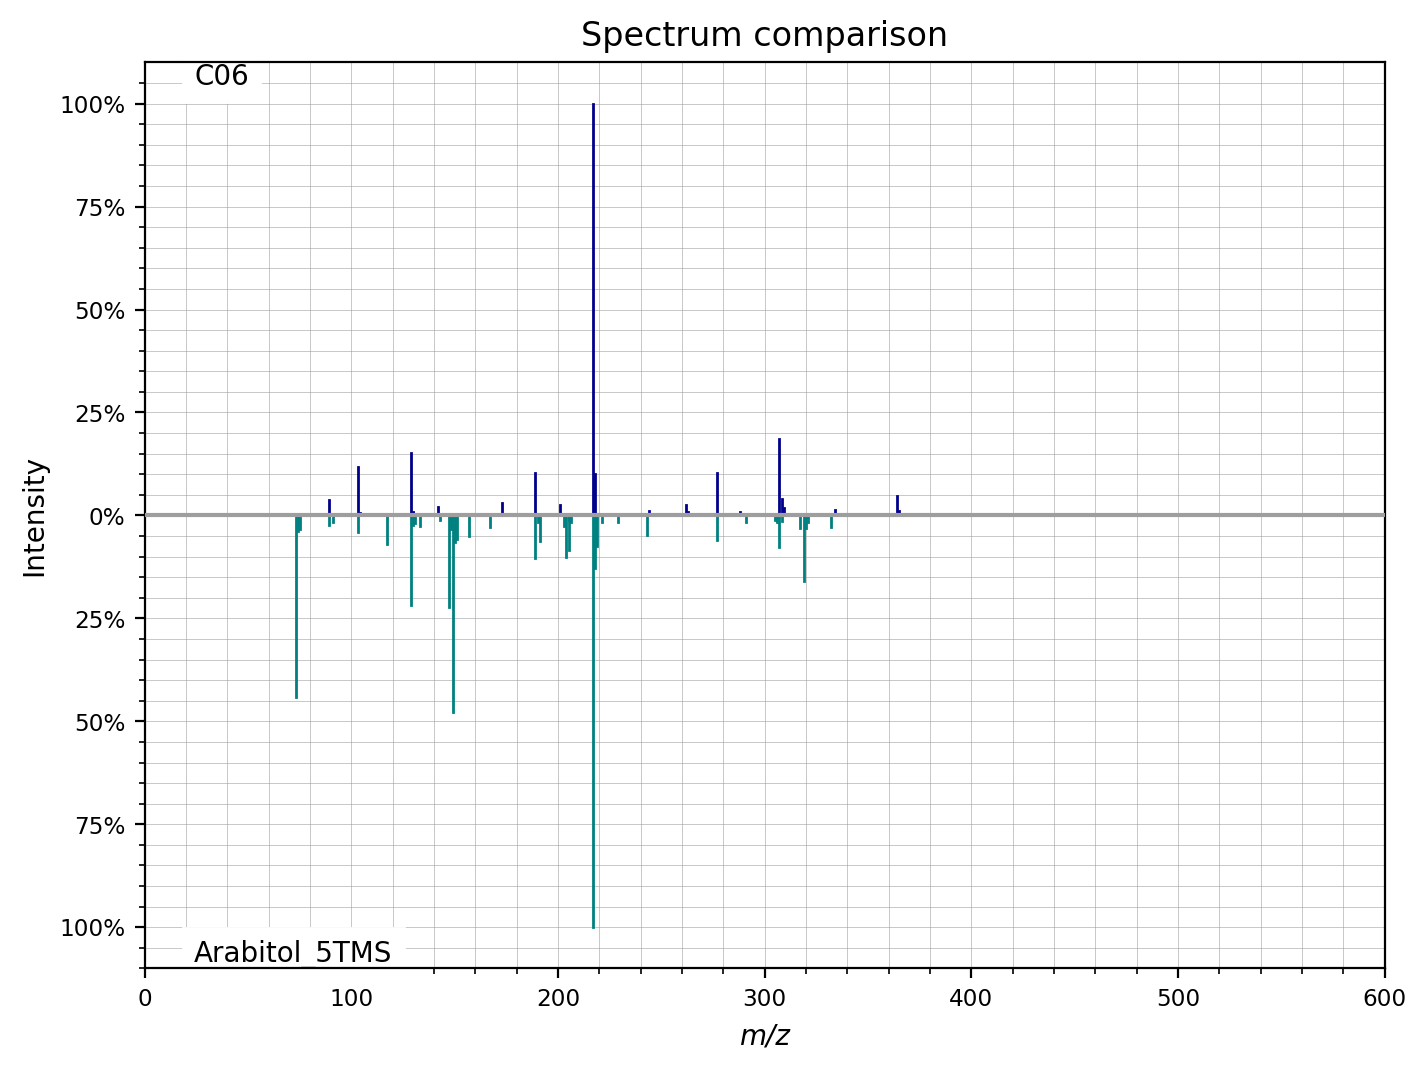

Spectrum C06 - detected peaks: 32
When matched to Arabitol_5TMS: 9 matched ions with 0.796552247937575 total confidence
In this match, 20 peaks were not in library spectrum and 33 peaks from library spectrum were missing


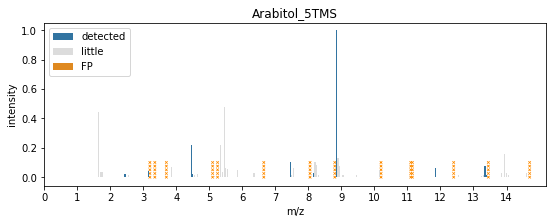


Spectrum C06 - detected peaks: 33
When matched to Arabitol_5TMS: 9 matched ions with 0.796552247937575 total confidence
In this match, 20 peaks were not in library spectrum and 32 peaks from library spectrum were missing


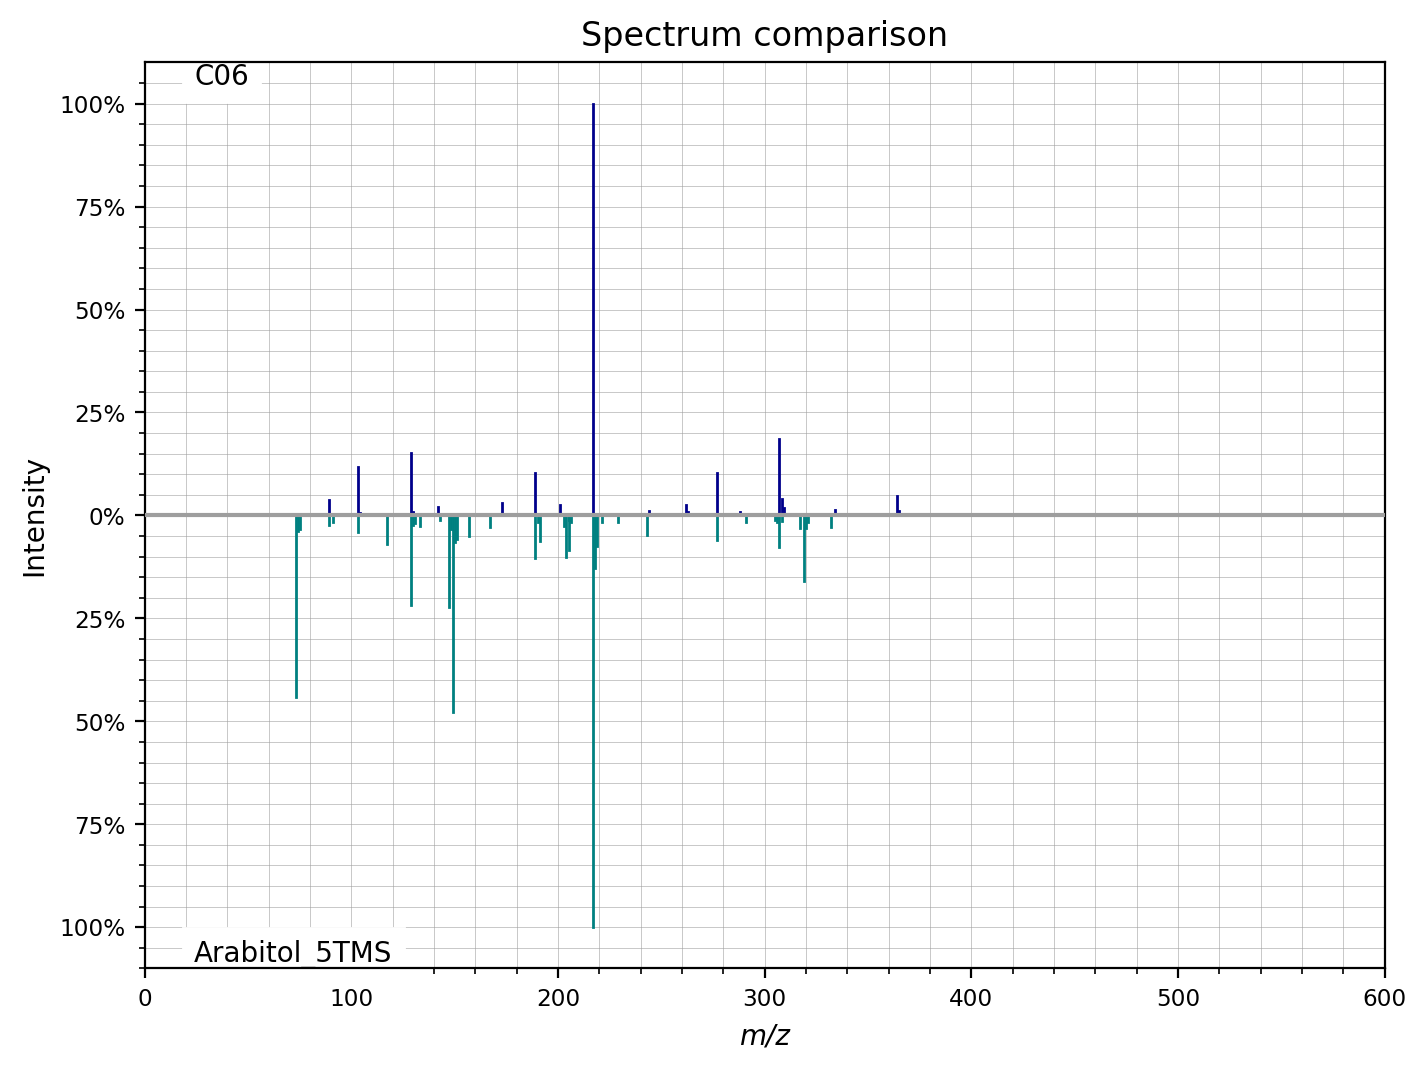

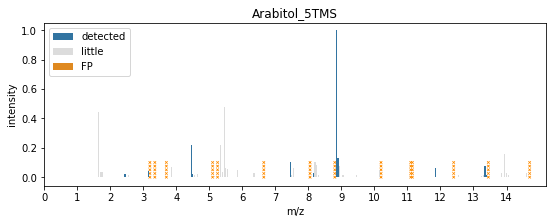

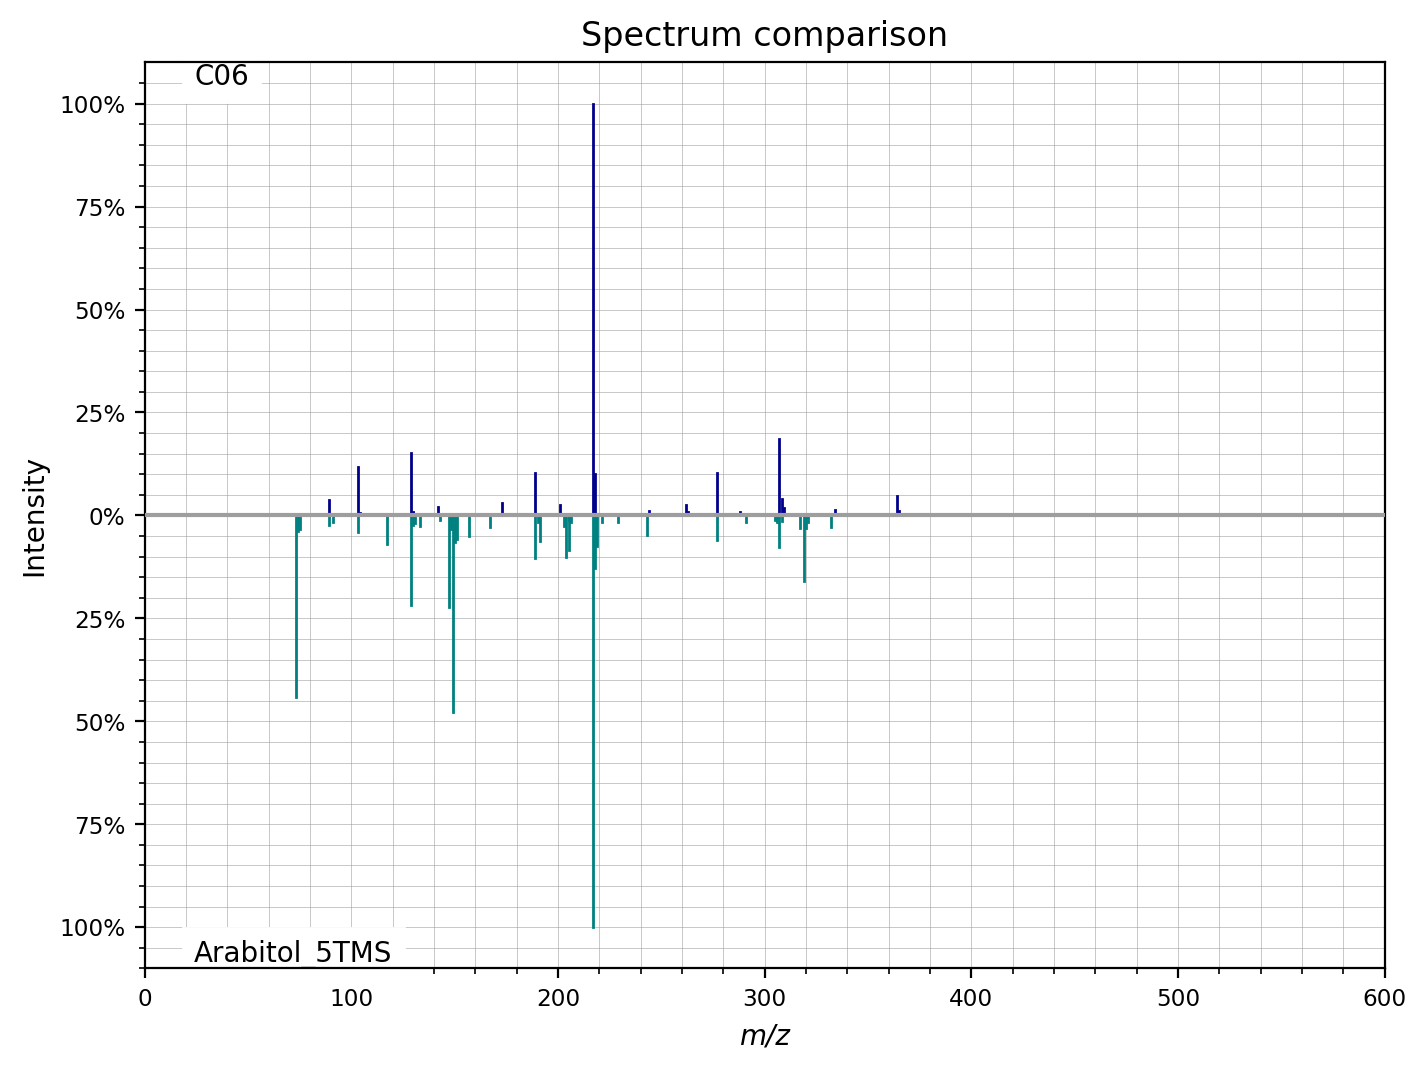

Spectrum C26 - detected peaks: 12
When matched to Threonine_3TMS spectra 1: 8 matched ions with 0.7965404736026365 total confidence
In this match, 1 peaks were not in library spectrum and 74 peaks from library spectrum were missing


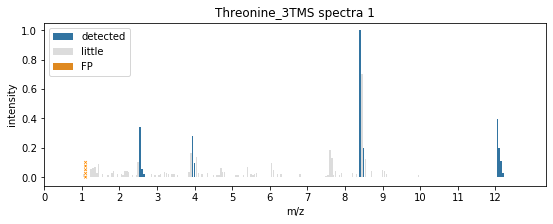


Spectrum C26 - detected peaks: 13
When matched to Threonine_3TMS spectra 1: 8 matched ions with 0.7965404736026365 total confidence
In this match, 1 peaks were not in library spectrum and 73 peaks from library spectrum were missing


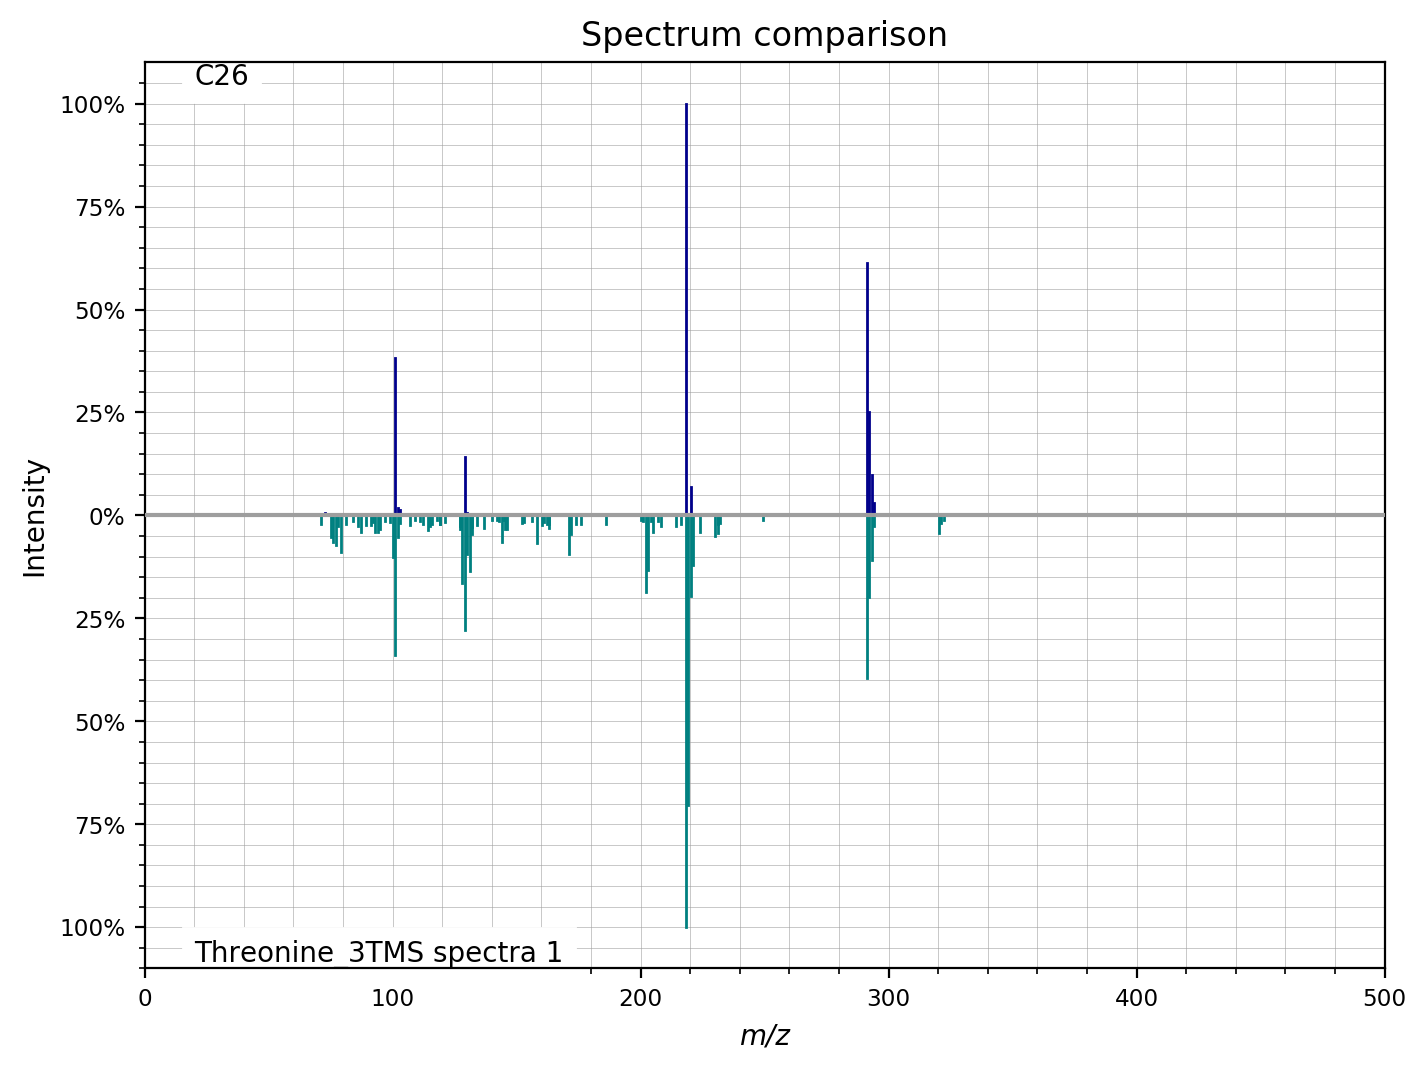

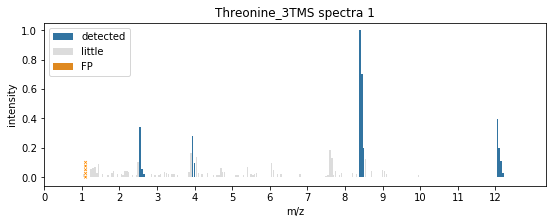

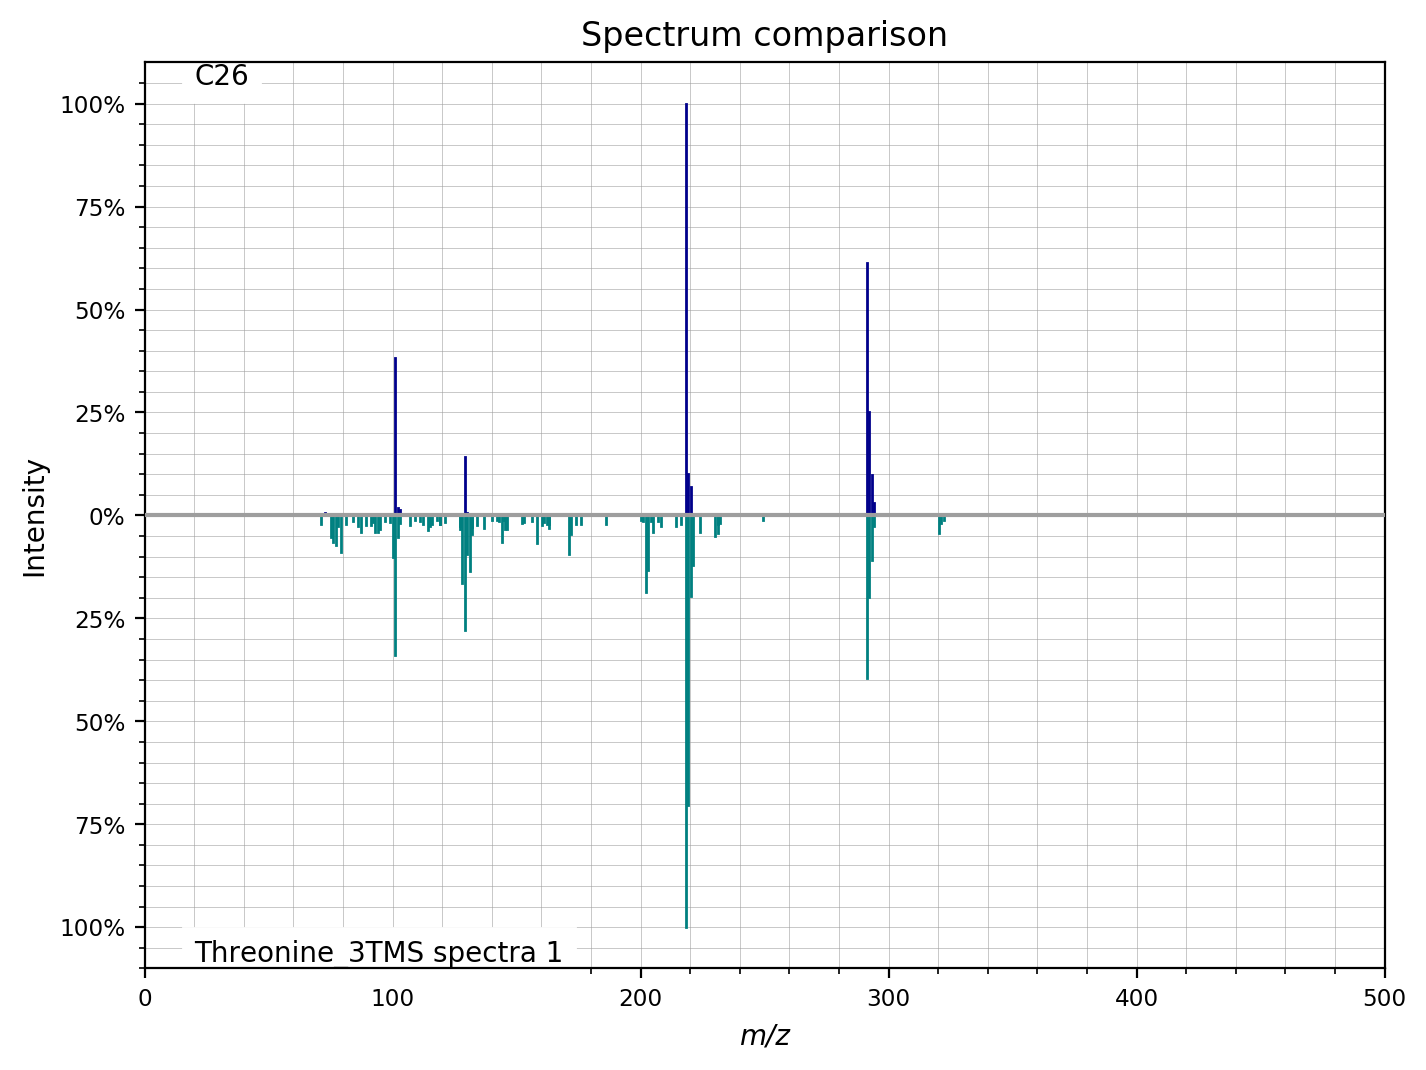

Spectrum C17 - detected peaks: 14
When matched to Serine_3TMS: 8 matched ions with 0.8255728082836913 total confidence
In this match, 4 peaks were not in library spectrum and 24 peaks from library spectrum were missing


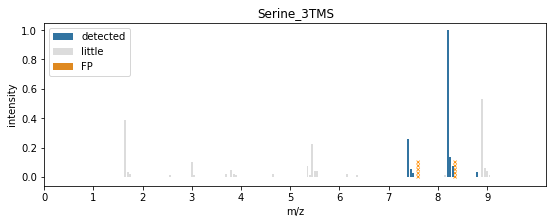


Spectrum C17 - detected peaks: 14
When matched to Serine_3TMS: 8 matched ions with 0.8255728082836913 total confidence
In this match, 4 peaks were not in library spectrum and 24 peaks from library spectrum were missing


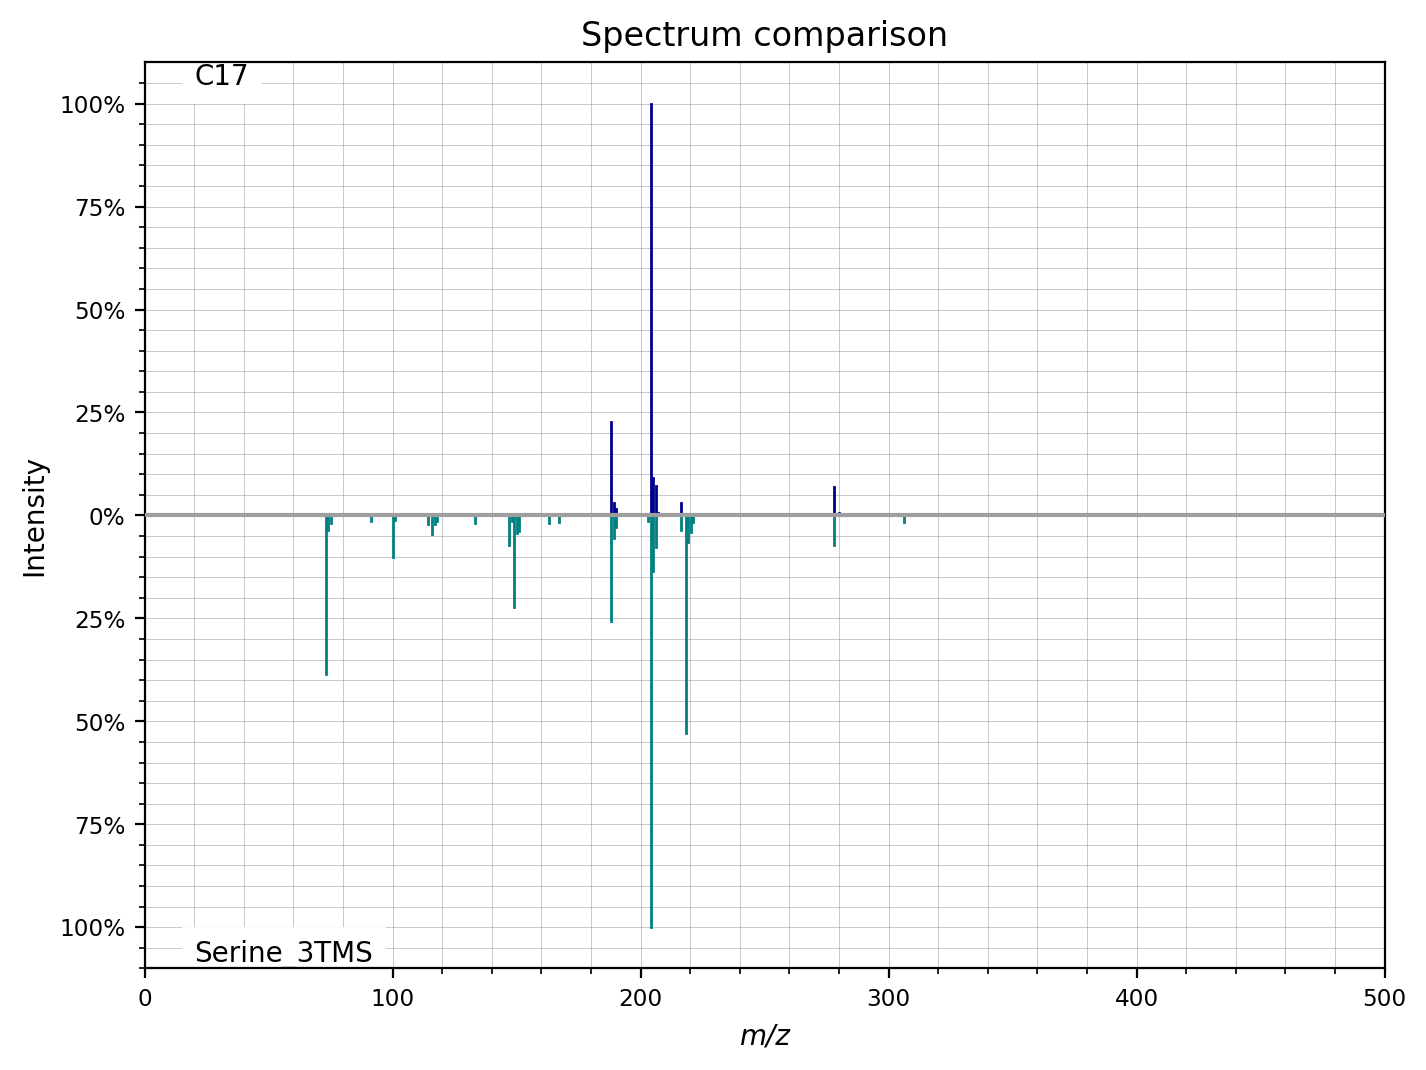

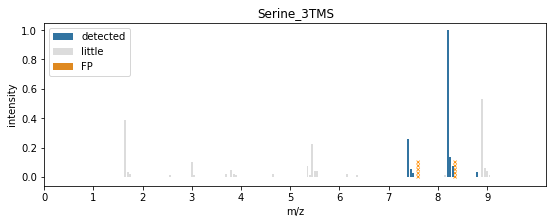

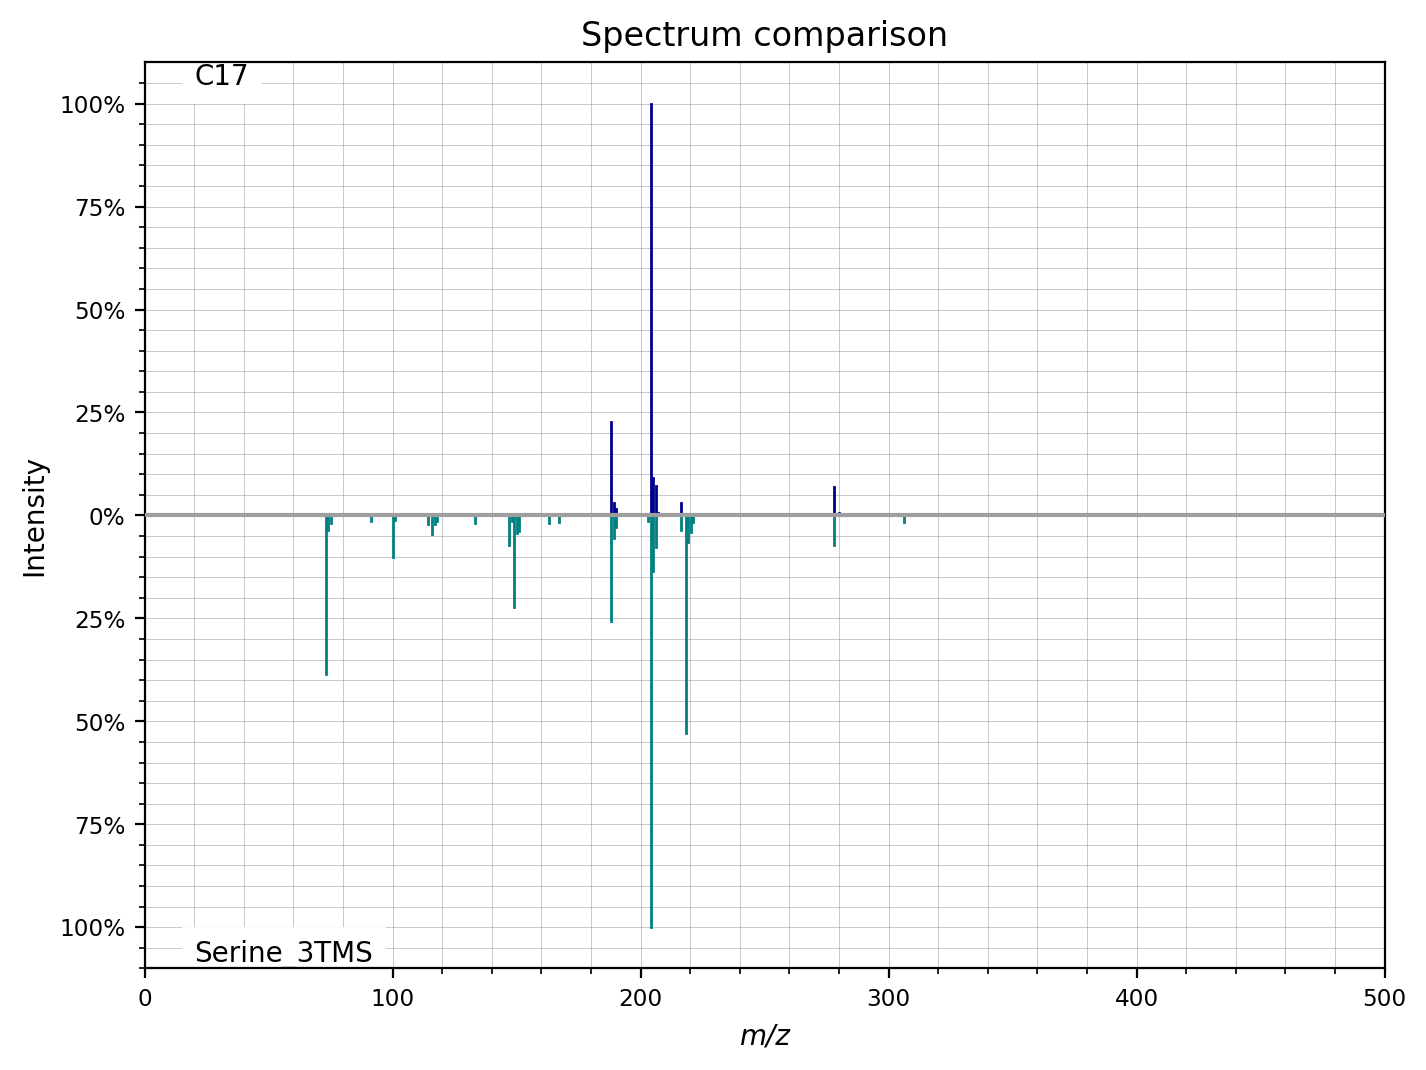

Spectrum C06 - detected peaks: 32
When matched to Ribitol_5TMS: 8 matched ions with 0.7140334223708281 total confidence
In this match, 20 peaks were not in library spectrum and 33 peaks from library spectrum were missing


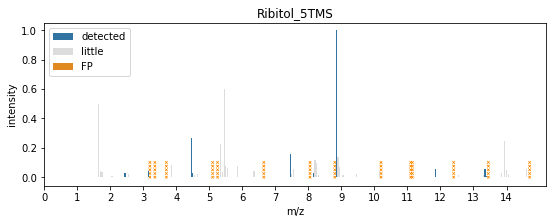


Spectrum C06 - detected peaks: 33
When matched to Ribitol_5TMS: 8 matched ions with 0.7140334223708281 total confidence
In this match, 20 peaks were not in library spectrum and 32 peaks from library spectrum were missing


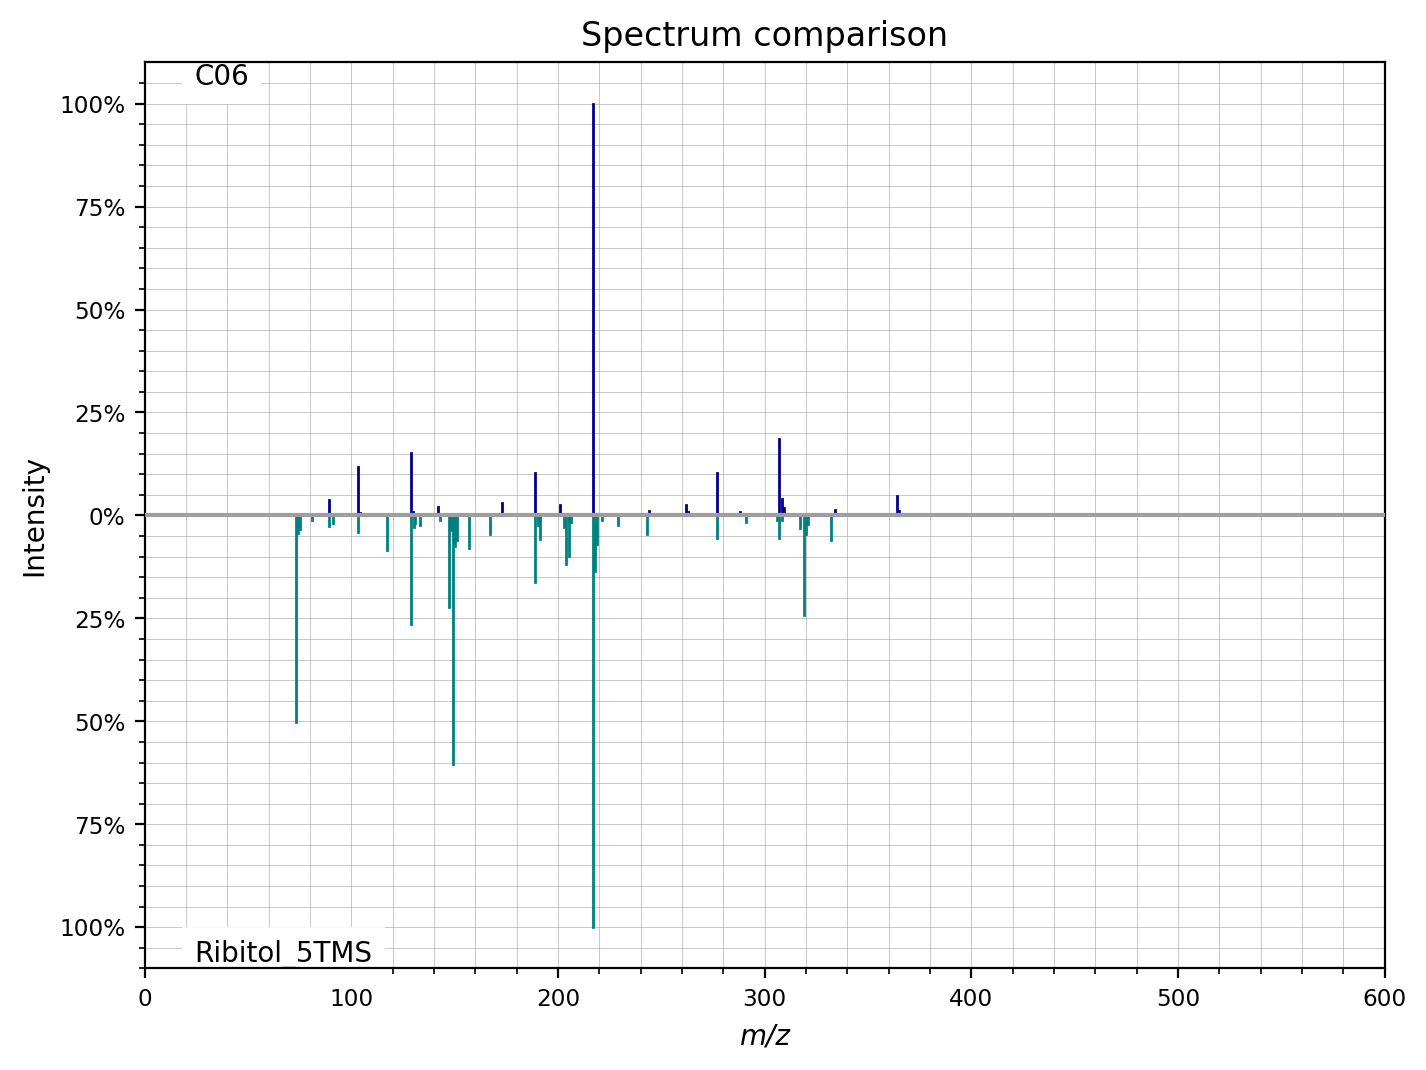

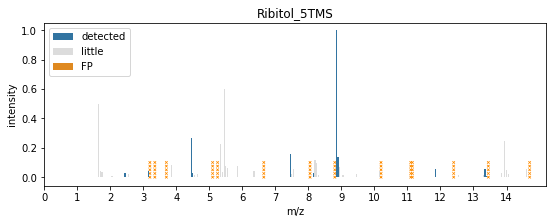

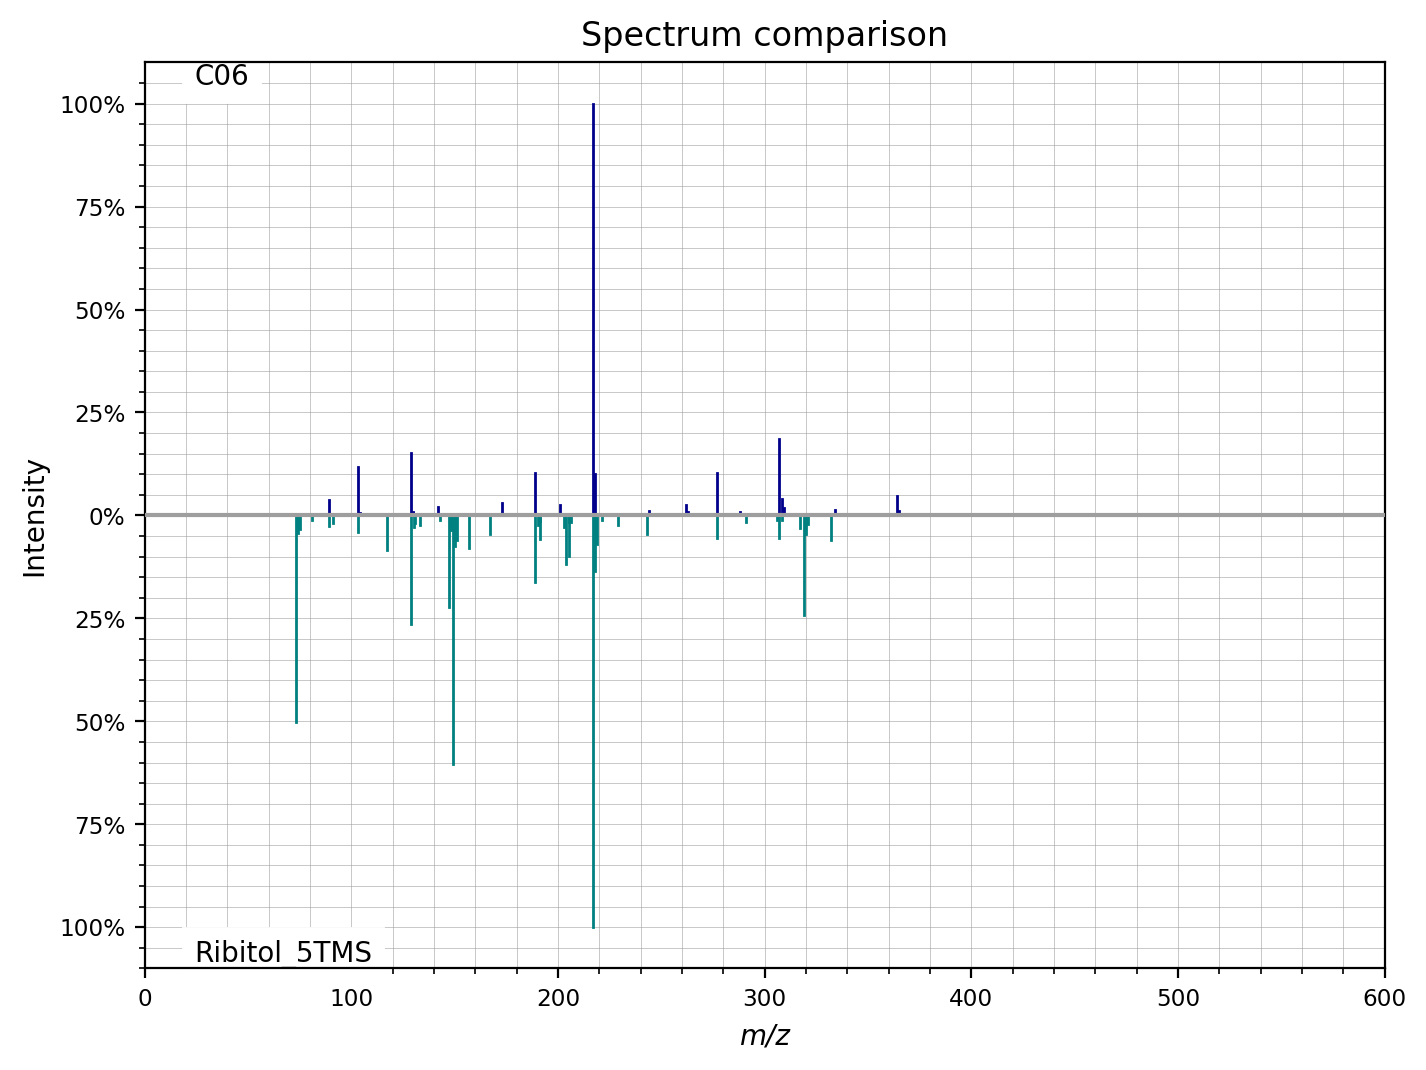

Spectrum C06 - detected peaks: 32
When matched to Gluconic acid-1,4-lactone: 7 matched ions with 0.8218563911271052 total confidence
In this match, 19 peaks were not in library spectrum and 43 peaks from library spectrum were missing


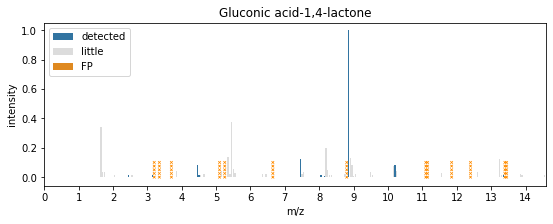


Spectrum C06 - detected peaks: 33
When matched to Gluconic acid-1,4-lactone: 7 matched ions with 0.8218563911271052 total confidence
In this match, 19 peaks were not in library spectrum and 42 peaks from library spectrum were missing


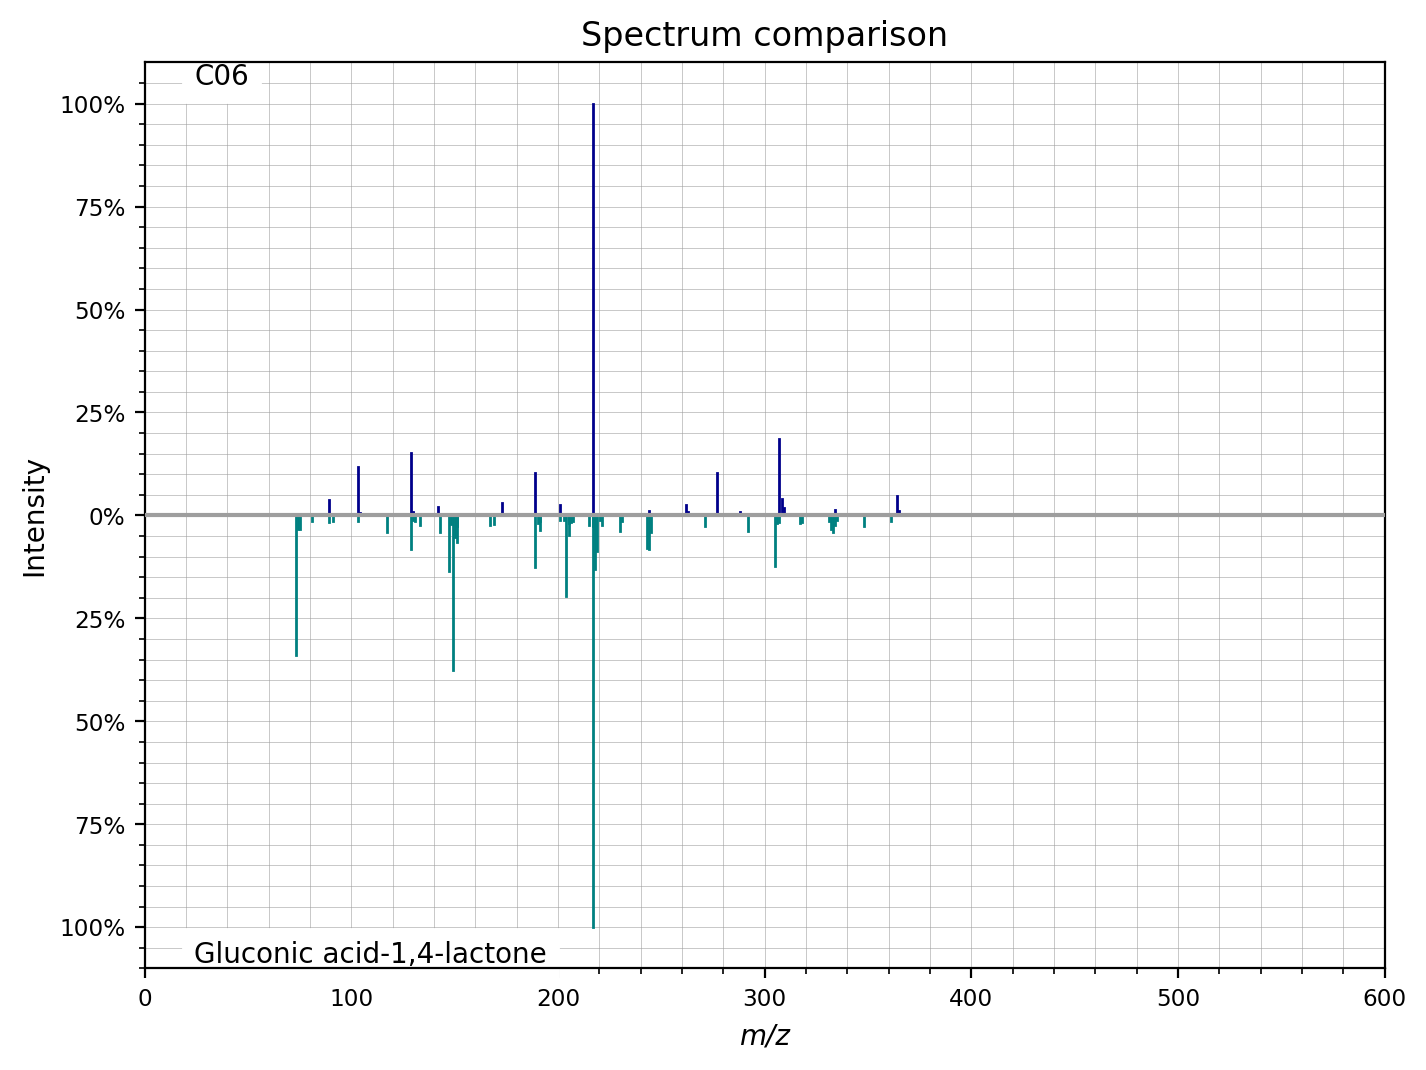

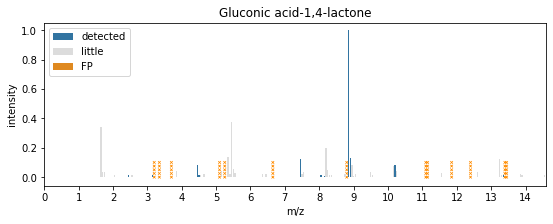

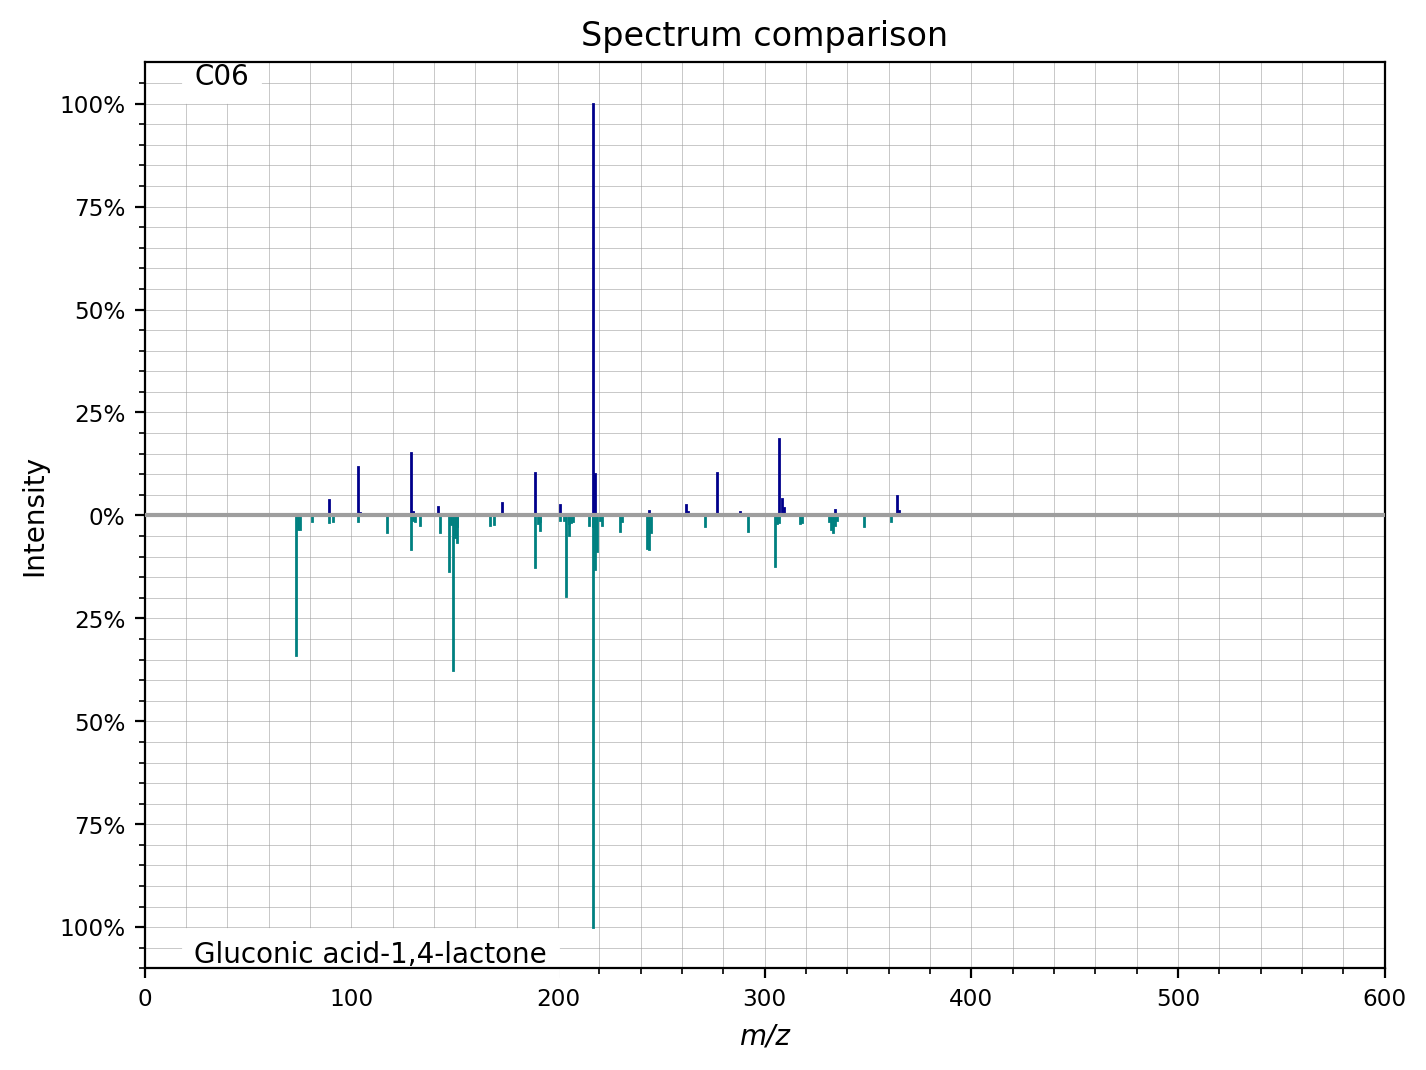

Spectrum C06 - detected peaks: 32
When matched to Galactitol_6TMS: 7 matched ions with 0.7806173392109105 total confidence
In this match, 21 peaks were not in library spectrum and 41 peaks from library spectrum were missing


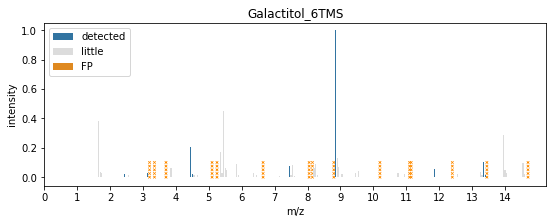


Spectrum C06 - detected peaks: 33
When matched to Galactitol_6TMS: 7 matched ions with 0.7806173392109105 total confidence
In this match, 21 peaks were not in library spectrum and 40 peaks from library spectrum were missing


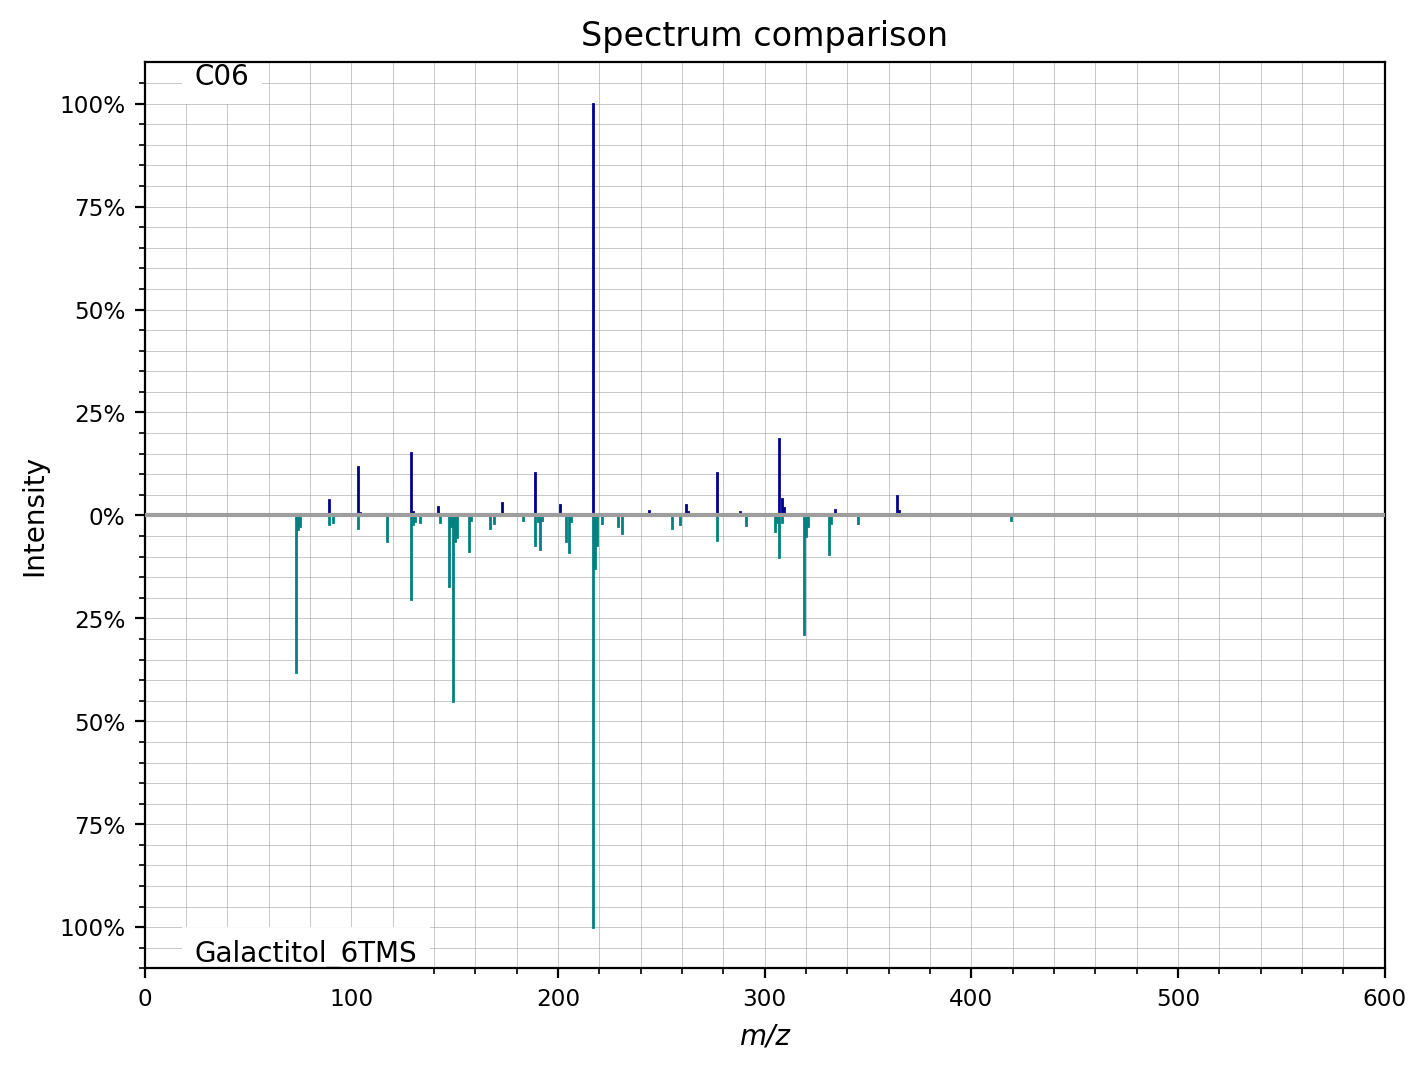

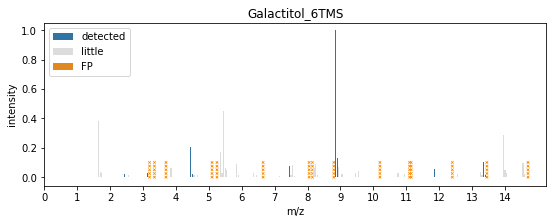

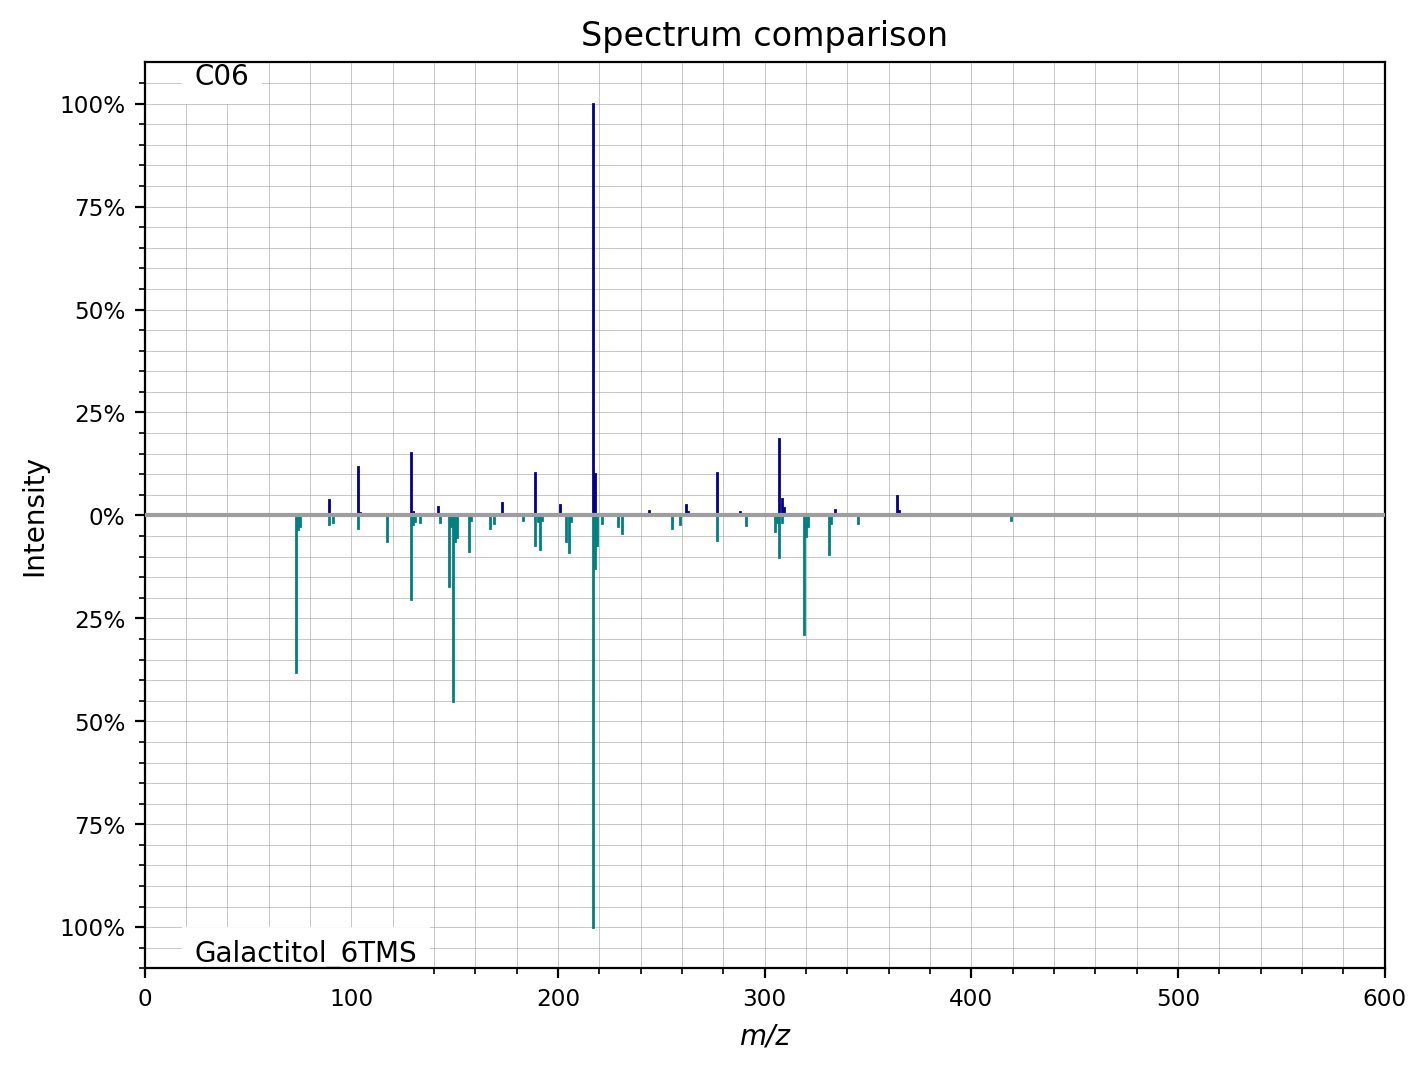

Spectrum C19 - detected peaks: 14
When matched to Aspartic acid_3TMS isomer: 5 matched ions with 0.8539725938176345 total confidence
In this match, 7 peaks were not in library spectrum and 33 peaks from library spectrum were missing


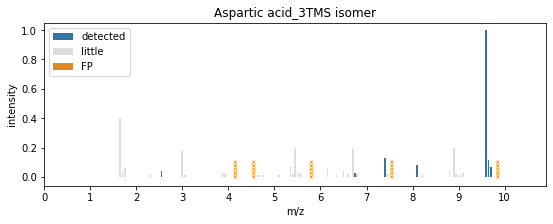


Spectrum C19 - detected peaks: 15
When matched to Aspartic acid_3TMS isomer: 5 matched ions with 0.8539725938176345 total confidence
In this match, 8 peaks were not in library spectrum and 33 peaks from library spectrum were missing


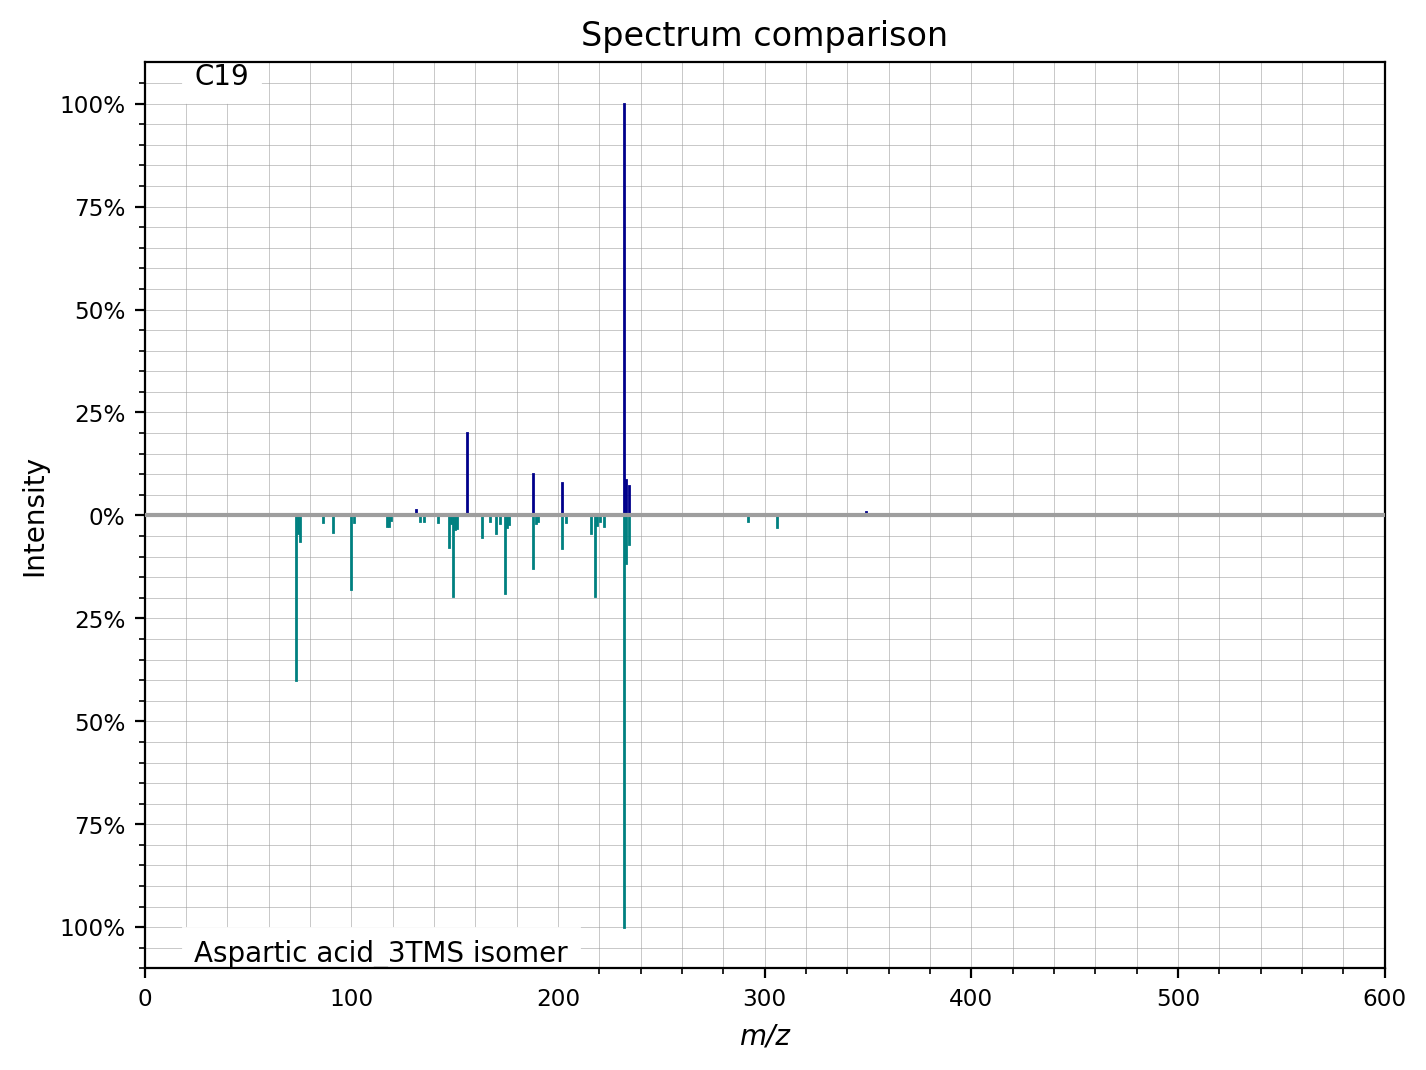

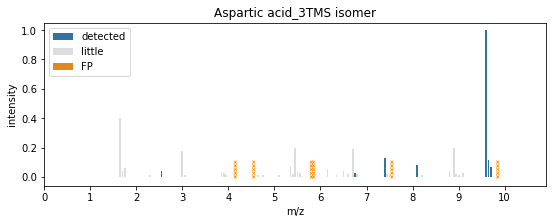

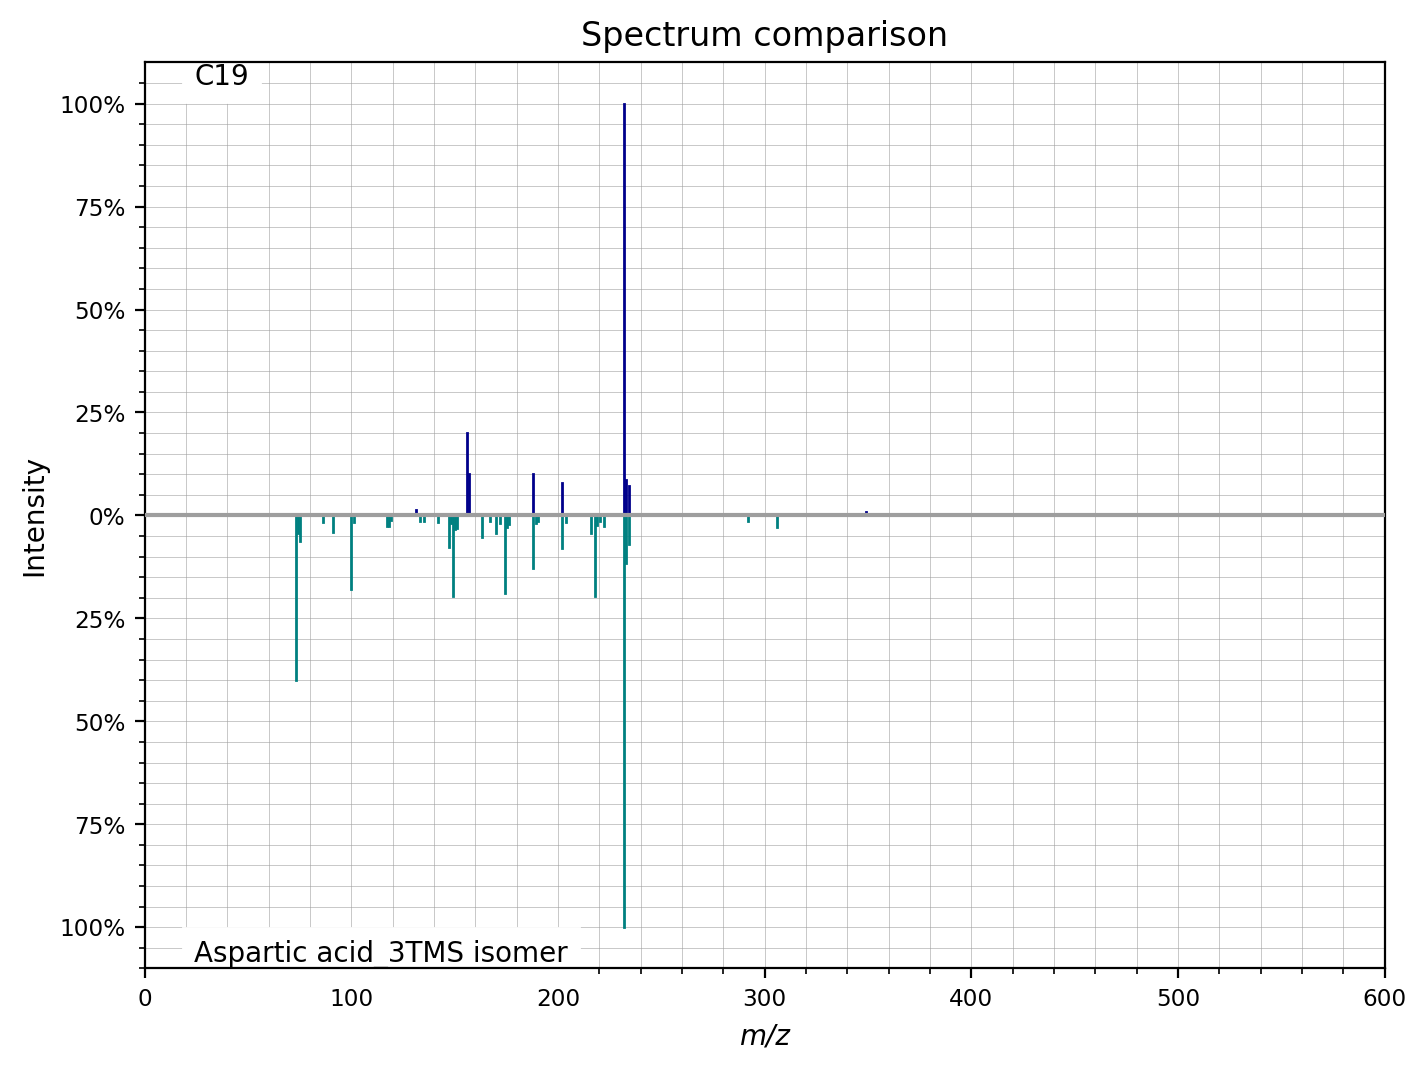

Spectrum C19 - detected peaks: 14
When matched to Aspartic acid_3TMS isomer: 5 matched ions with 0.9098349214292314 total confidence
In this match, 7 peaks were not in library spectrum and 33 peaks from library spectrum were missing


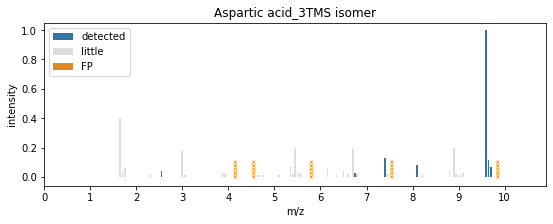


Spectrum C19 - detected peaks: 15
When matched to Aspartic acid_3TMS isomer: 5 matched ions with 0.9098349214292314 total confidence
In this match, 8 peaks were not in library spectrum and 33 peaks from library spectrum were missing


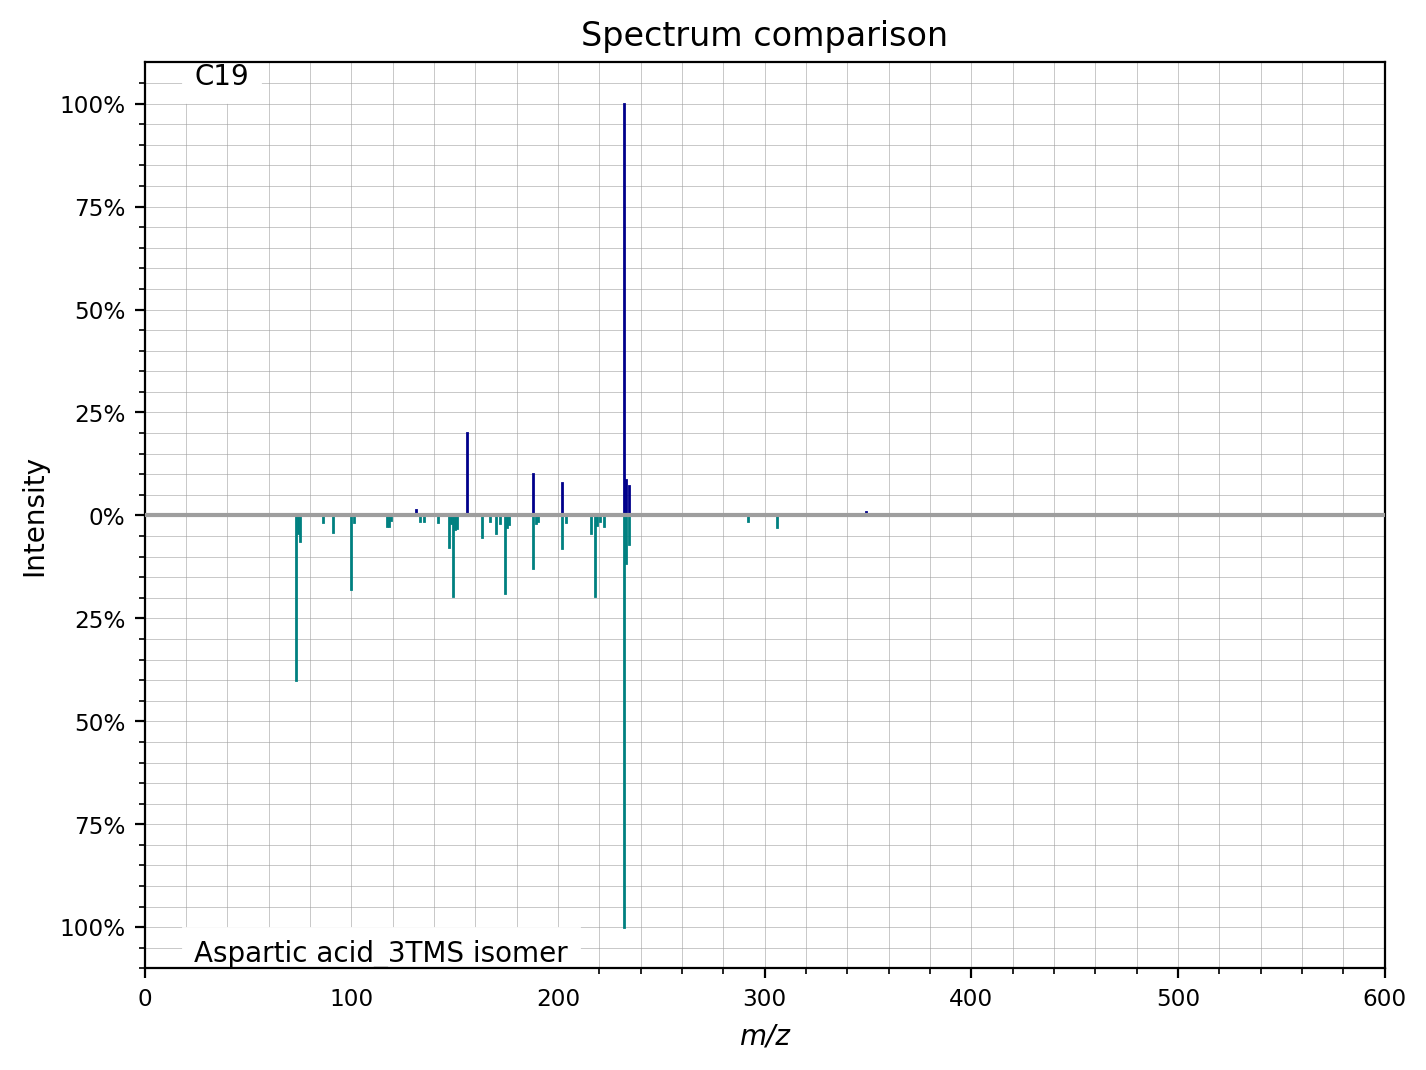

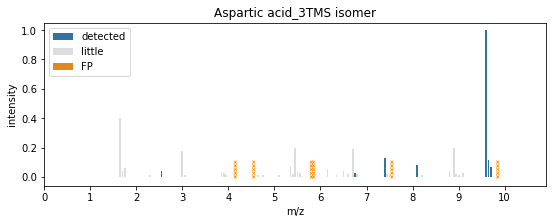

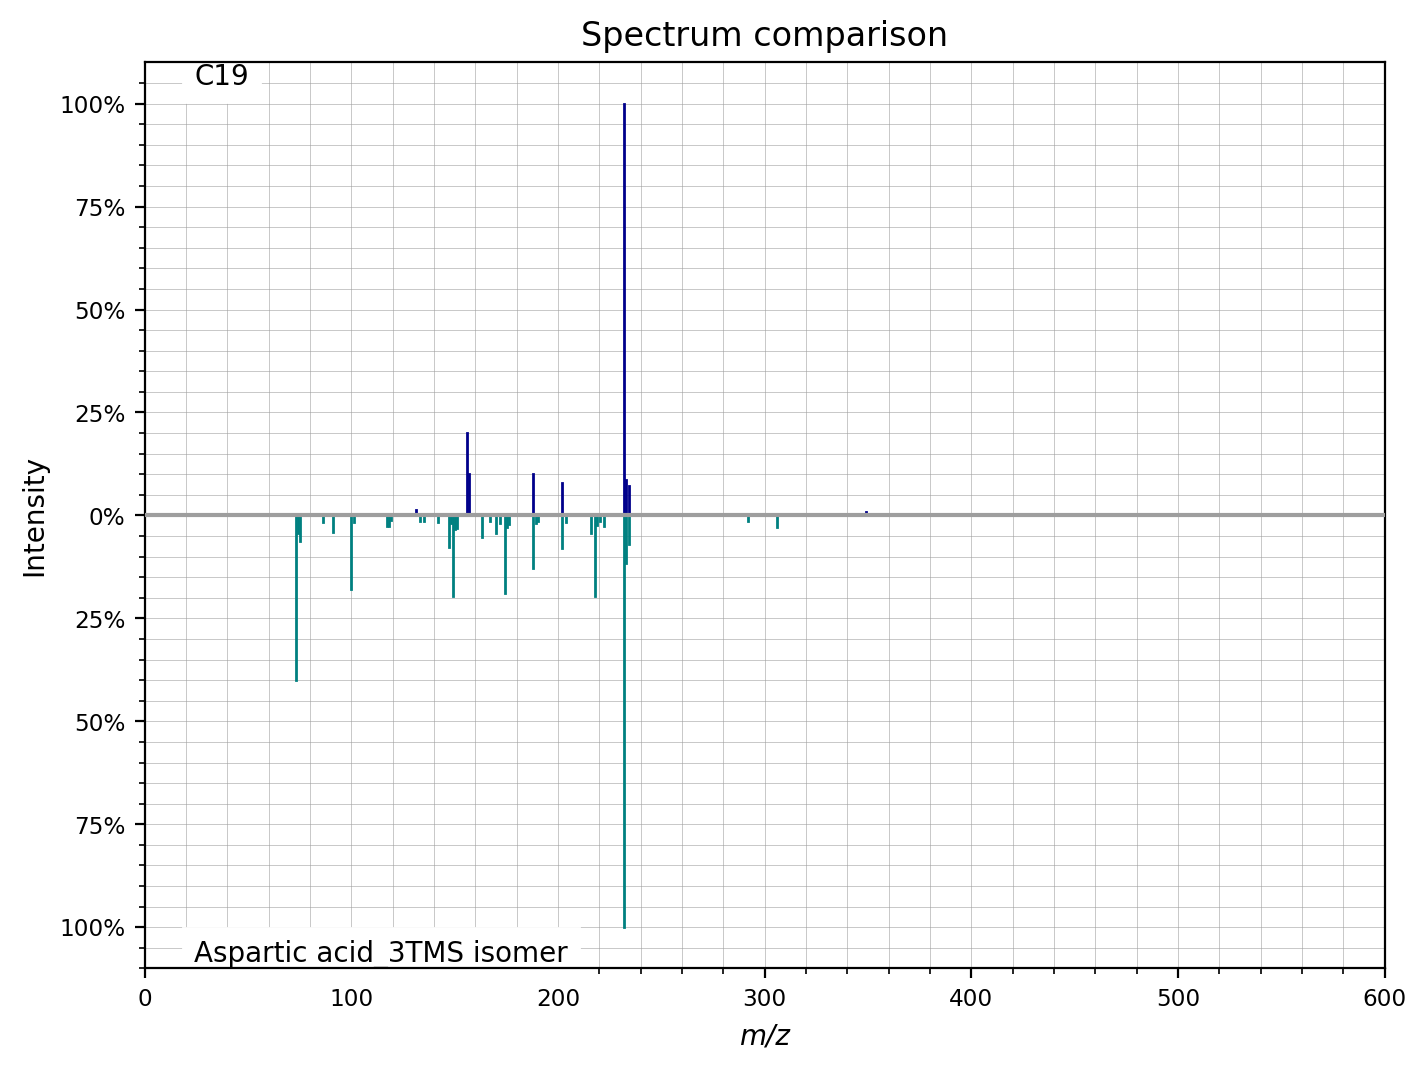

Spectrum C19 - detected peaks: 14
When matched to Aspartic acid_3TMS isomer: 5 matched ions with 0.8539725938176345 total confidence
In this match, 7 peaks were not in library spectrum and 33 peaks from library spectrum were missing


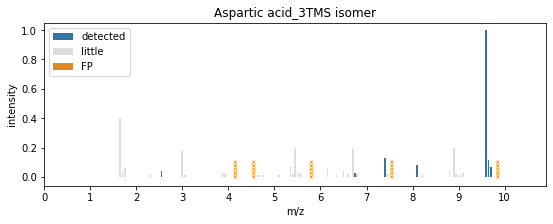


Spectrum C19 - detected peaks: 15
When matched to Aspartic acid_3TMS isomer: 5 matched ions with 0.8539725938176345 total confidence
In this match, 8 peaks were not in library spectrum and 33 peaks from library spectrum were missing


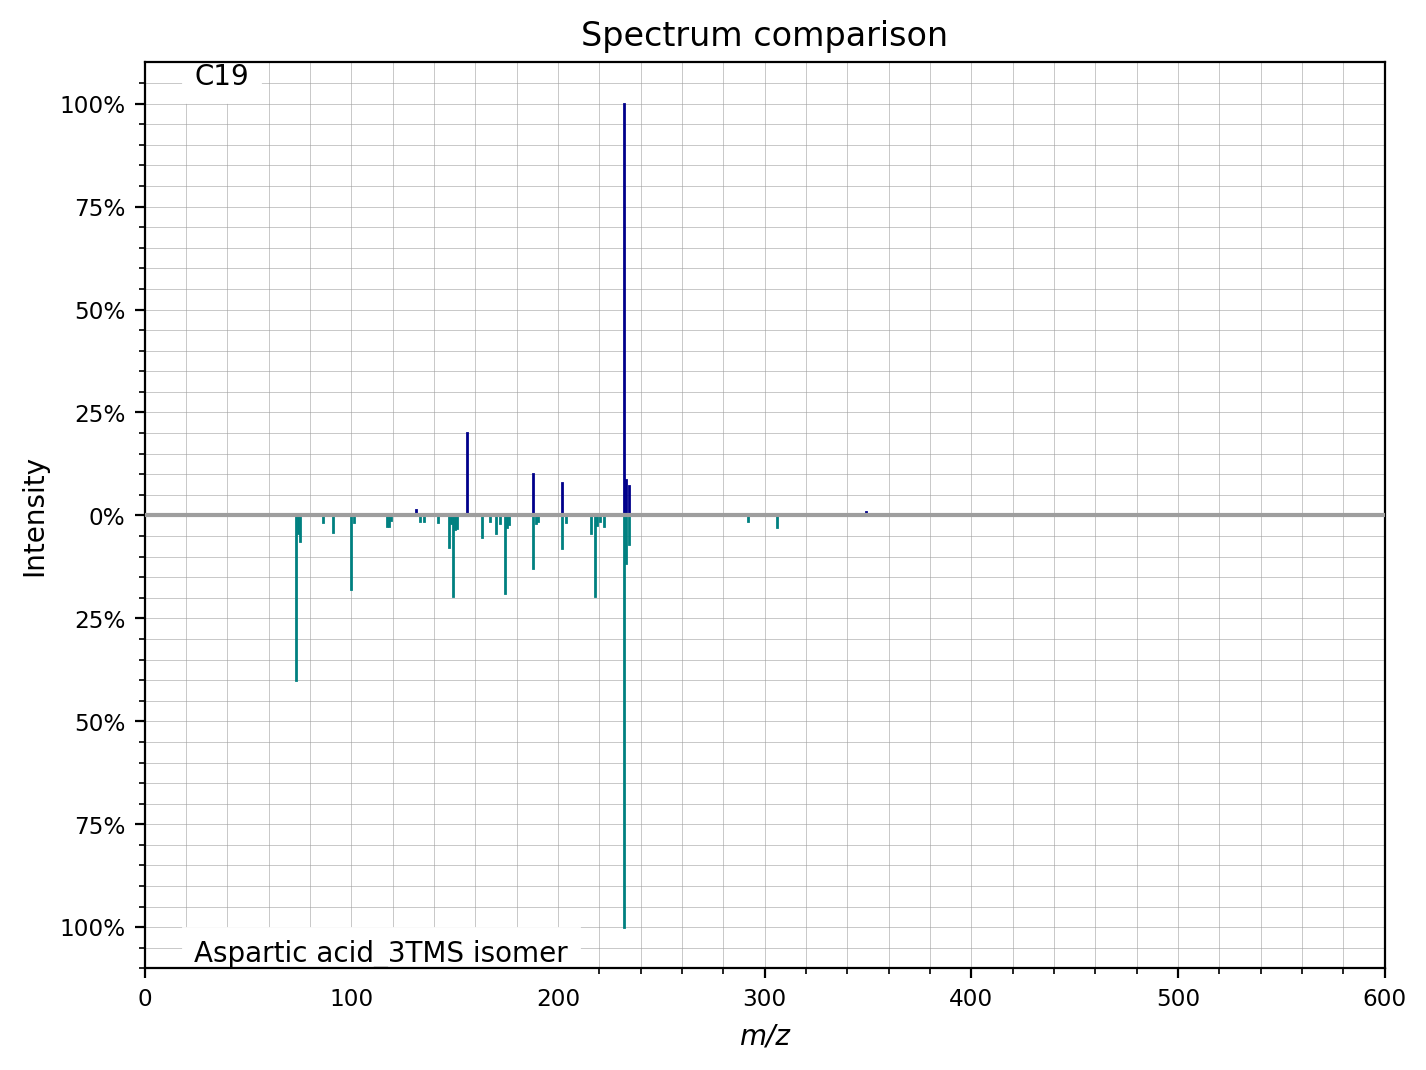

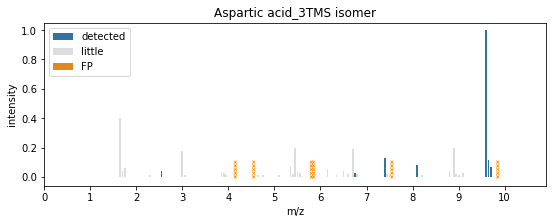

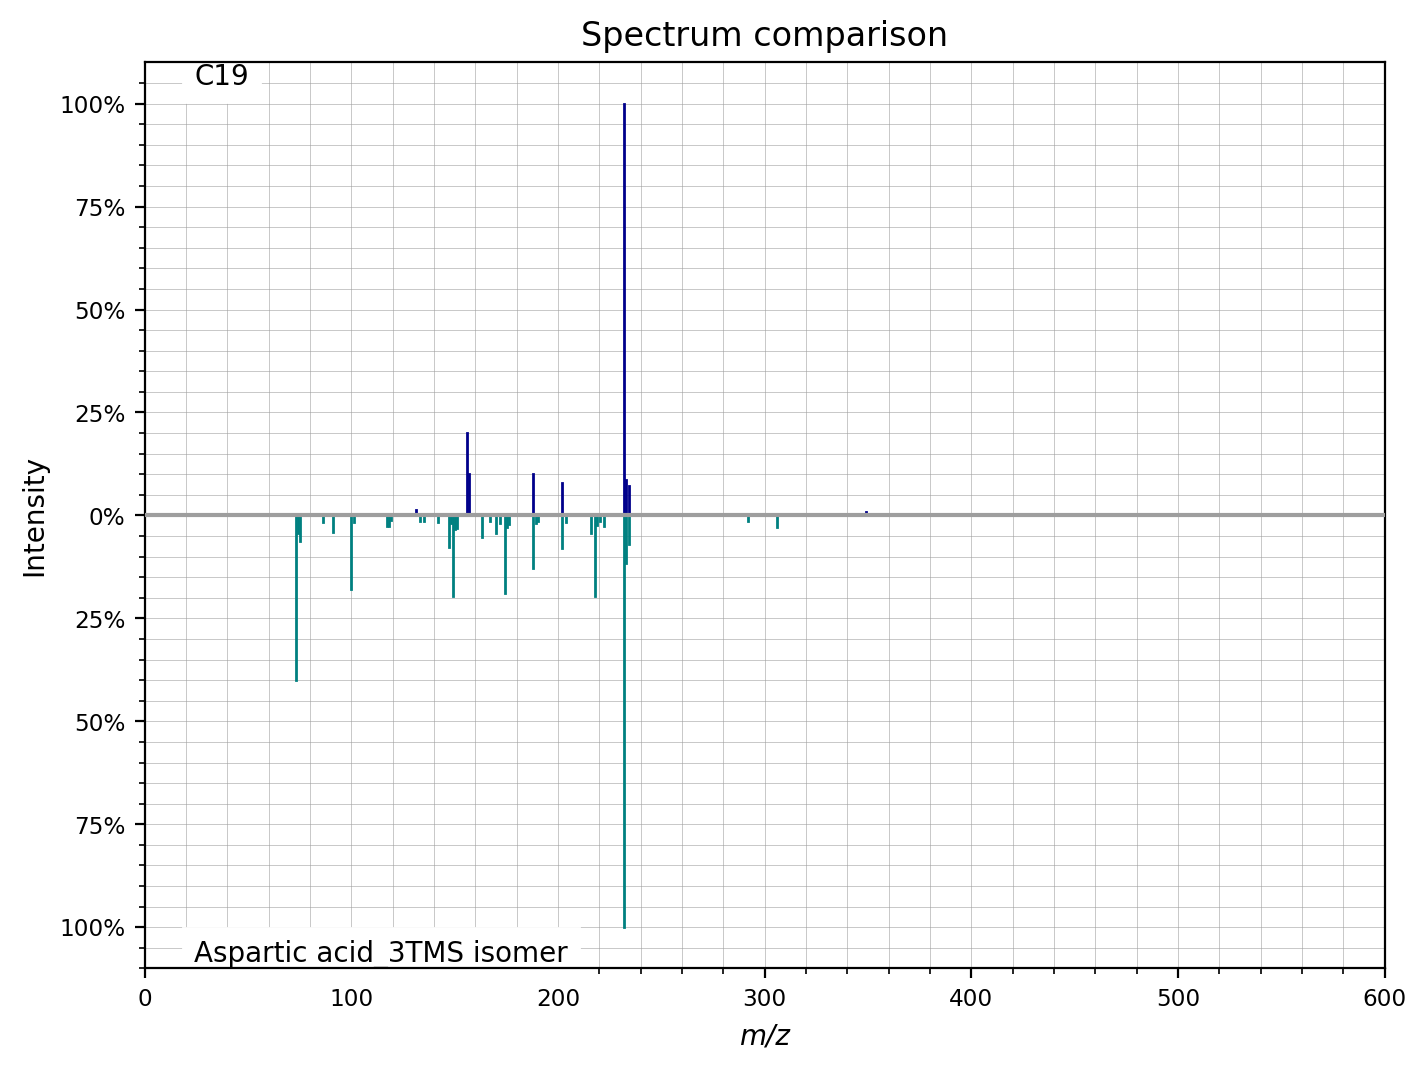

Spectrum C19 - detected peaks: 14
When matched to Aspartic acid_3TMS isomer: 5 matched ions with 0.9098349214292314 total confidence
In this match, 7 peaks were not in library spectrum and 33 peaks from library spectrum were missing


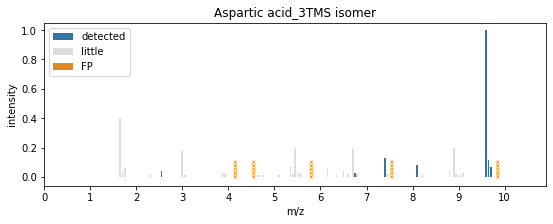


Spectrum C19 - detected peaks: 15
When matched to Aspartic acid_3TMS isomer: 5 matched ions with 0.9098349214292314 total confidence
In this match, 8 peaks were not in library spectrum and 33 peaks from library spectrum were missing


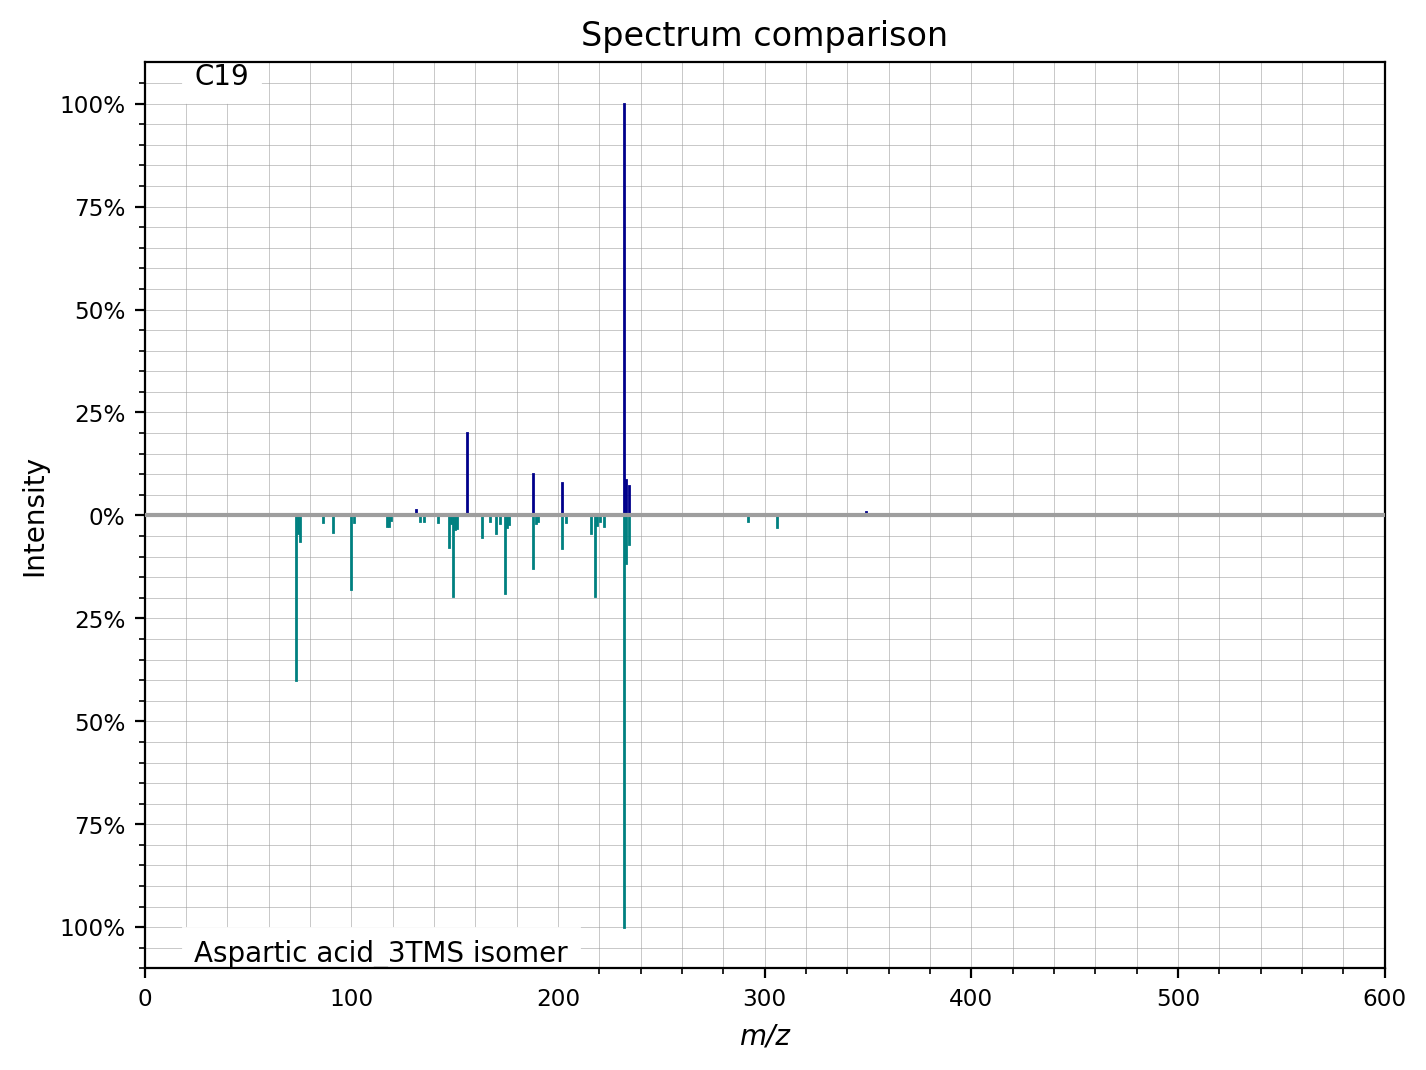

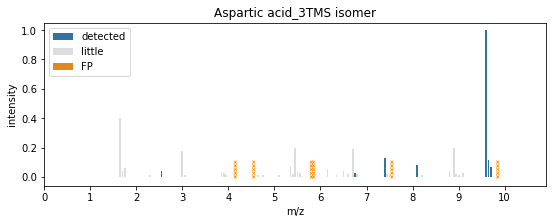

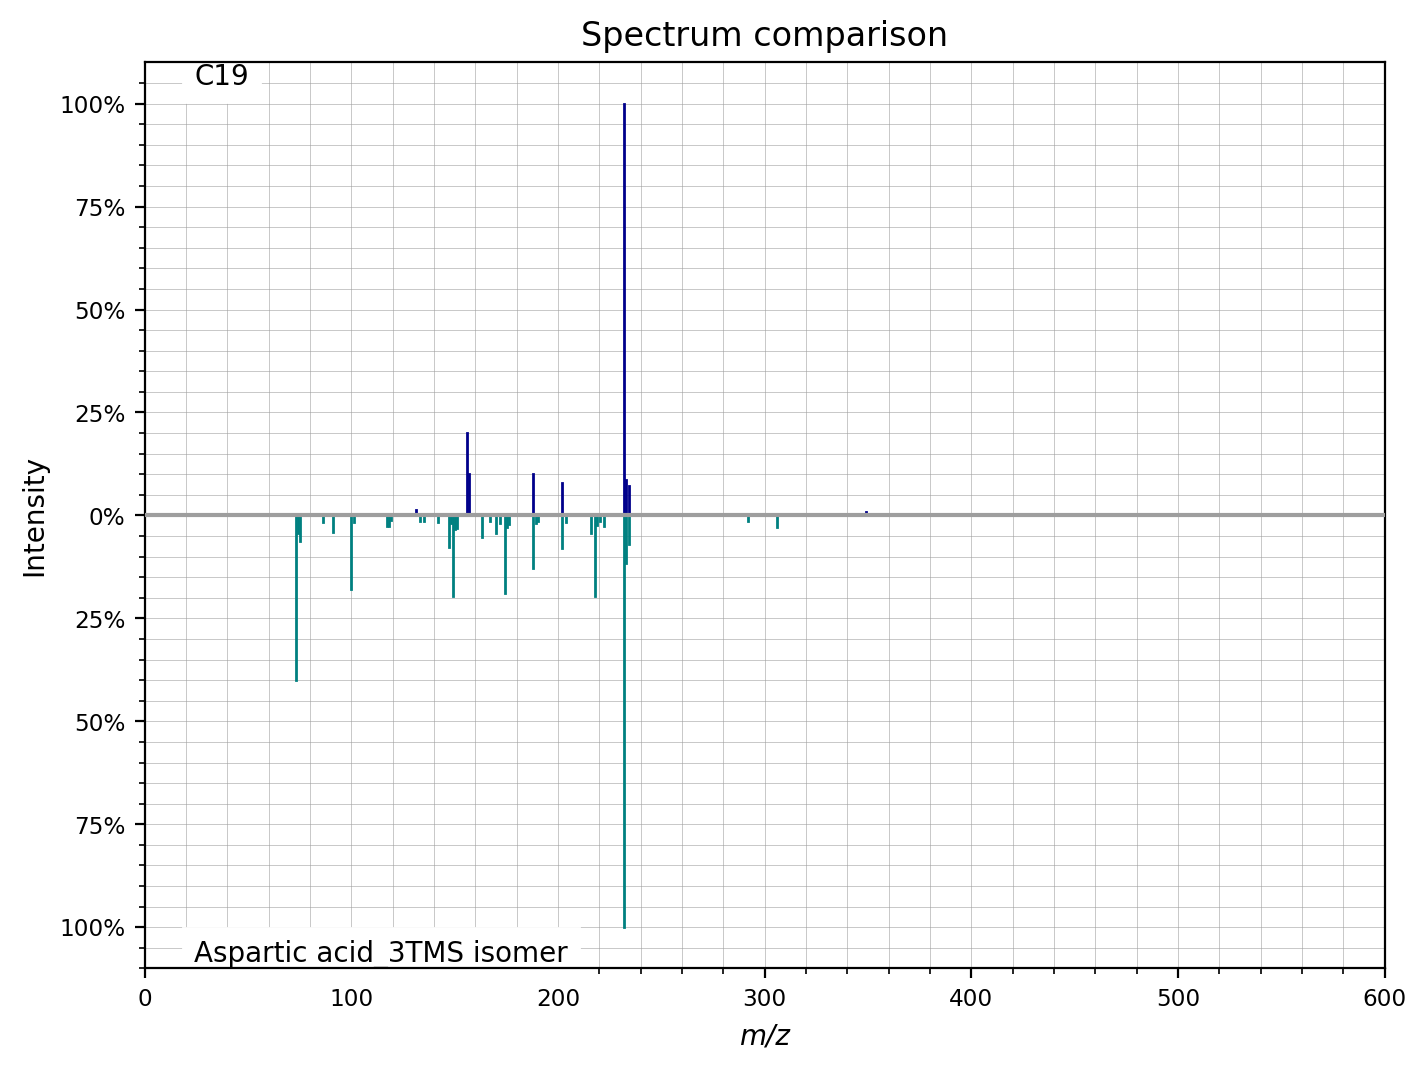

Spectrum C47 - detected peaks: 7
When matched to Norvaline_2TMS: 4 matched ions with 0.9273509946432018 total confidence
In this match, 2 peaks were not in library spectrum and 18 peaks from library spectrum were missing


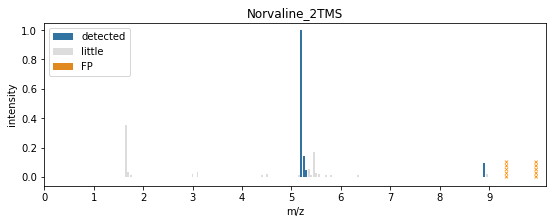


Spectrum C47 - detected peaks: 7
When matched to Norvaline_2TMS: 4 matched ions with 0.9273509946432018 total confidence
In this match, 2 peaks were not in library spectrum and 18 peaks from library spectrum were missing


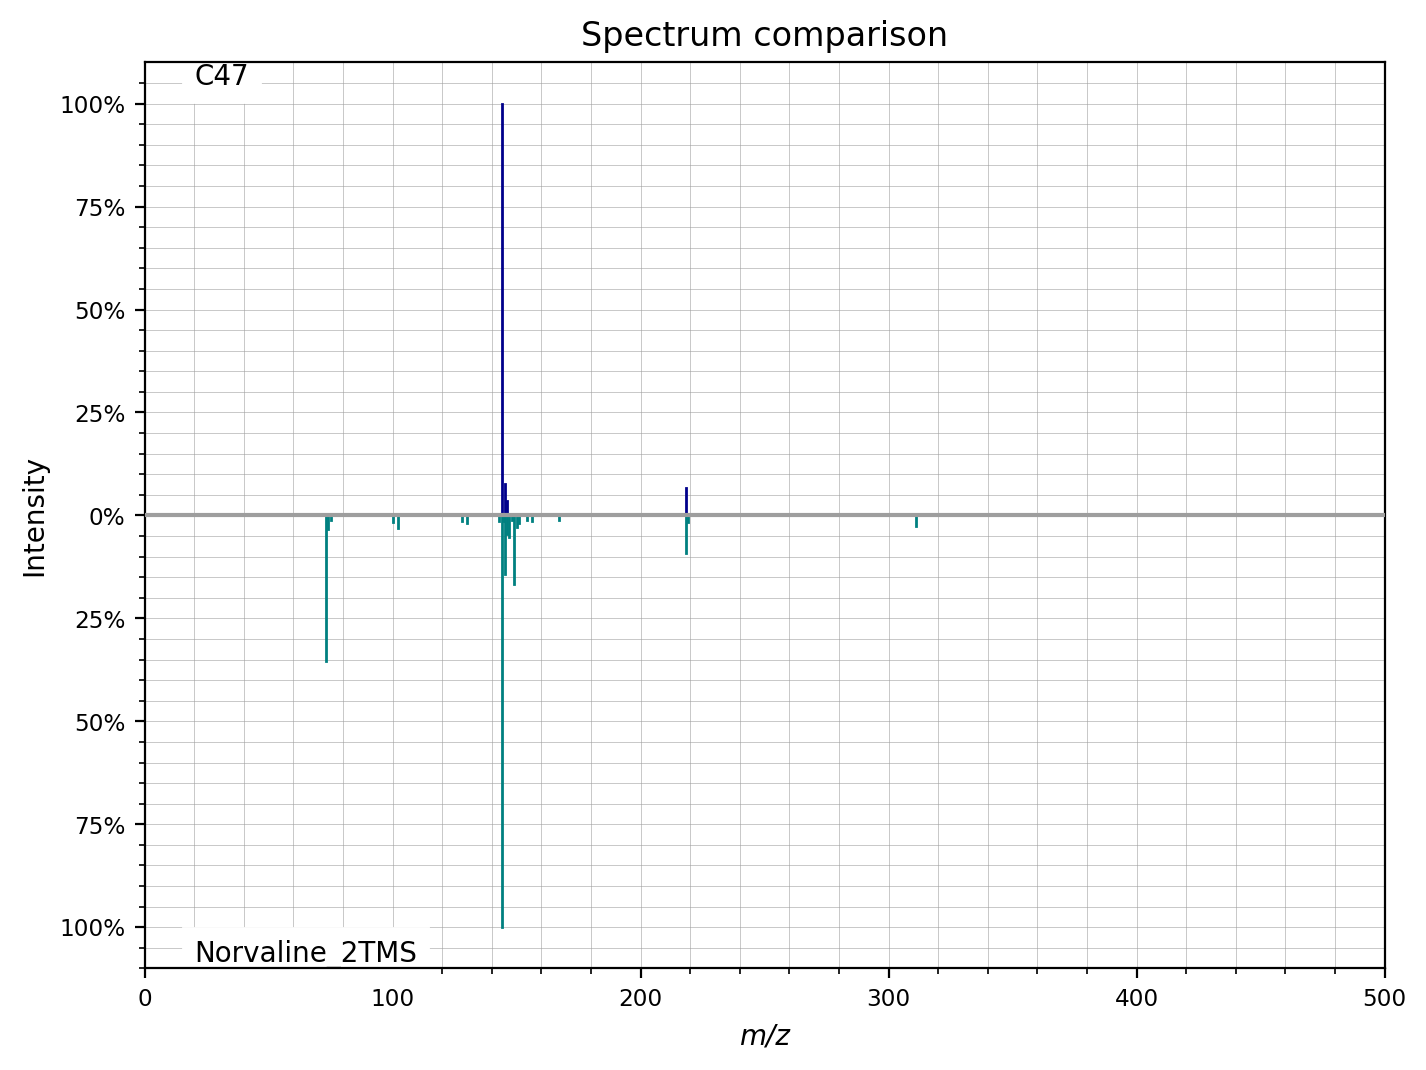

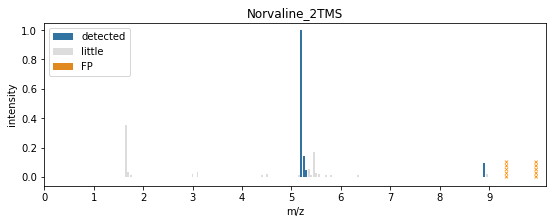

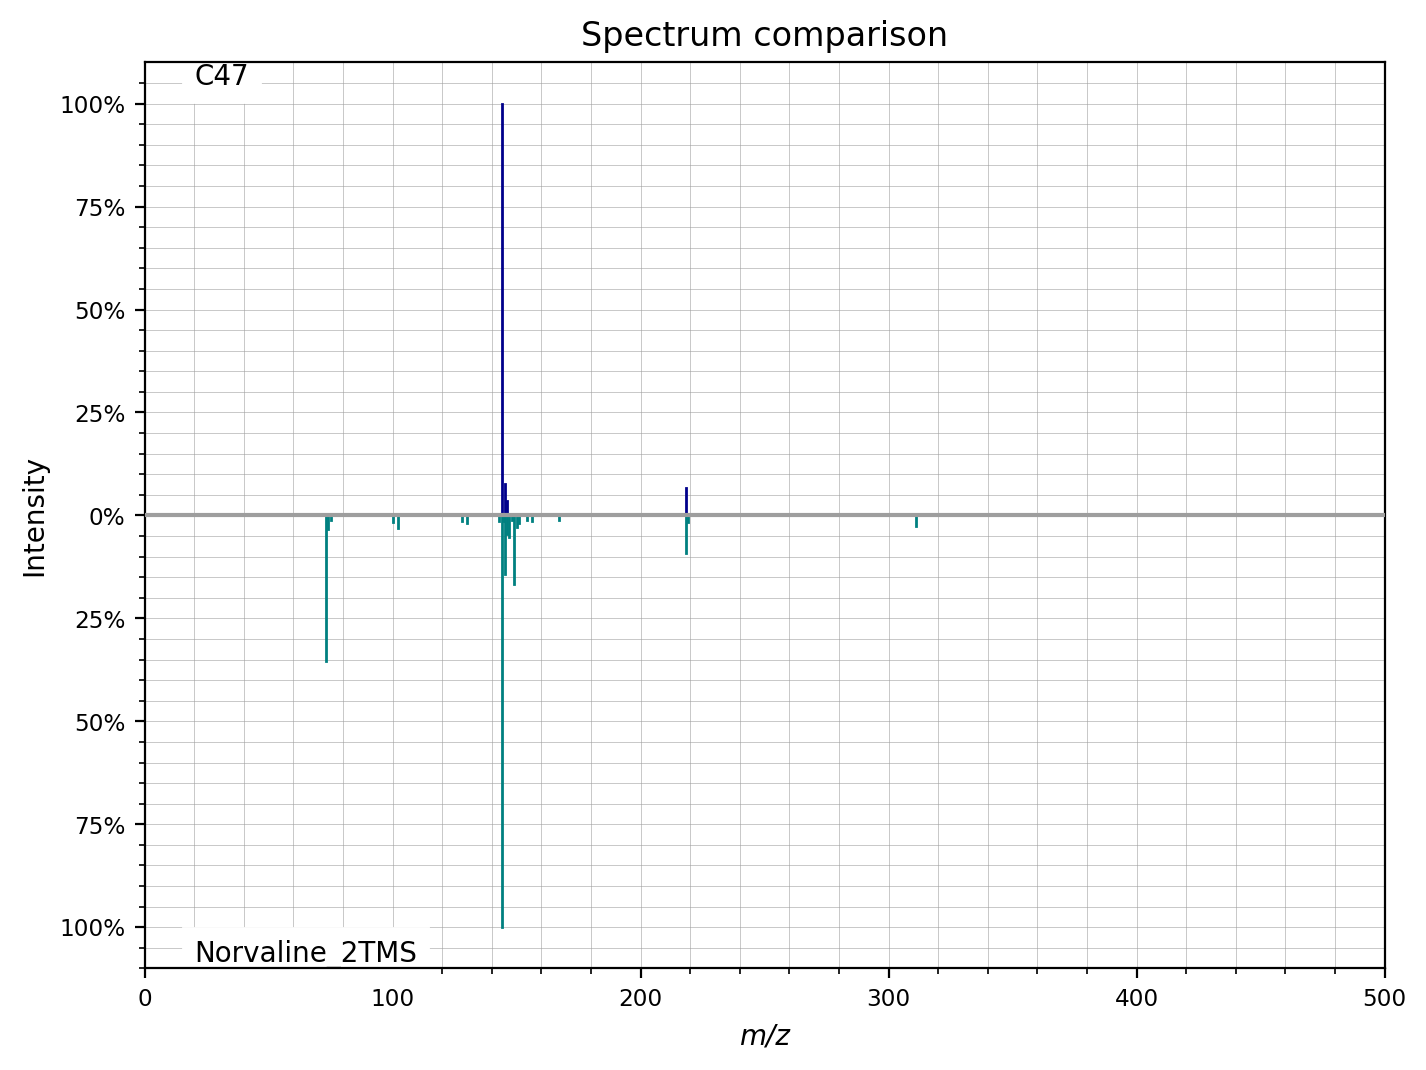

Spectrum C39 - detected peaks: 9
When matched to Histidine_3TMS: 4 matched ions with 0.8396355282325411 total confidence
In this match, 2 peaks were not in library spectrum and 39 peaks from library spectrum were missing


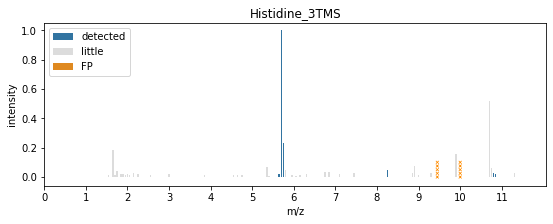


Spectrum C39 - detected peaks: 9
When matched to Histidine_3TMS: 4 matched ions with 0.8396355282325411 total confidence
In this match, 2 peaks were not in library spectrum and 39 peaks from library spectrum were missing


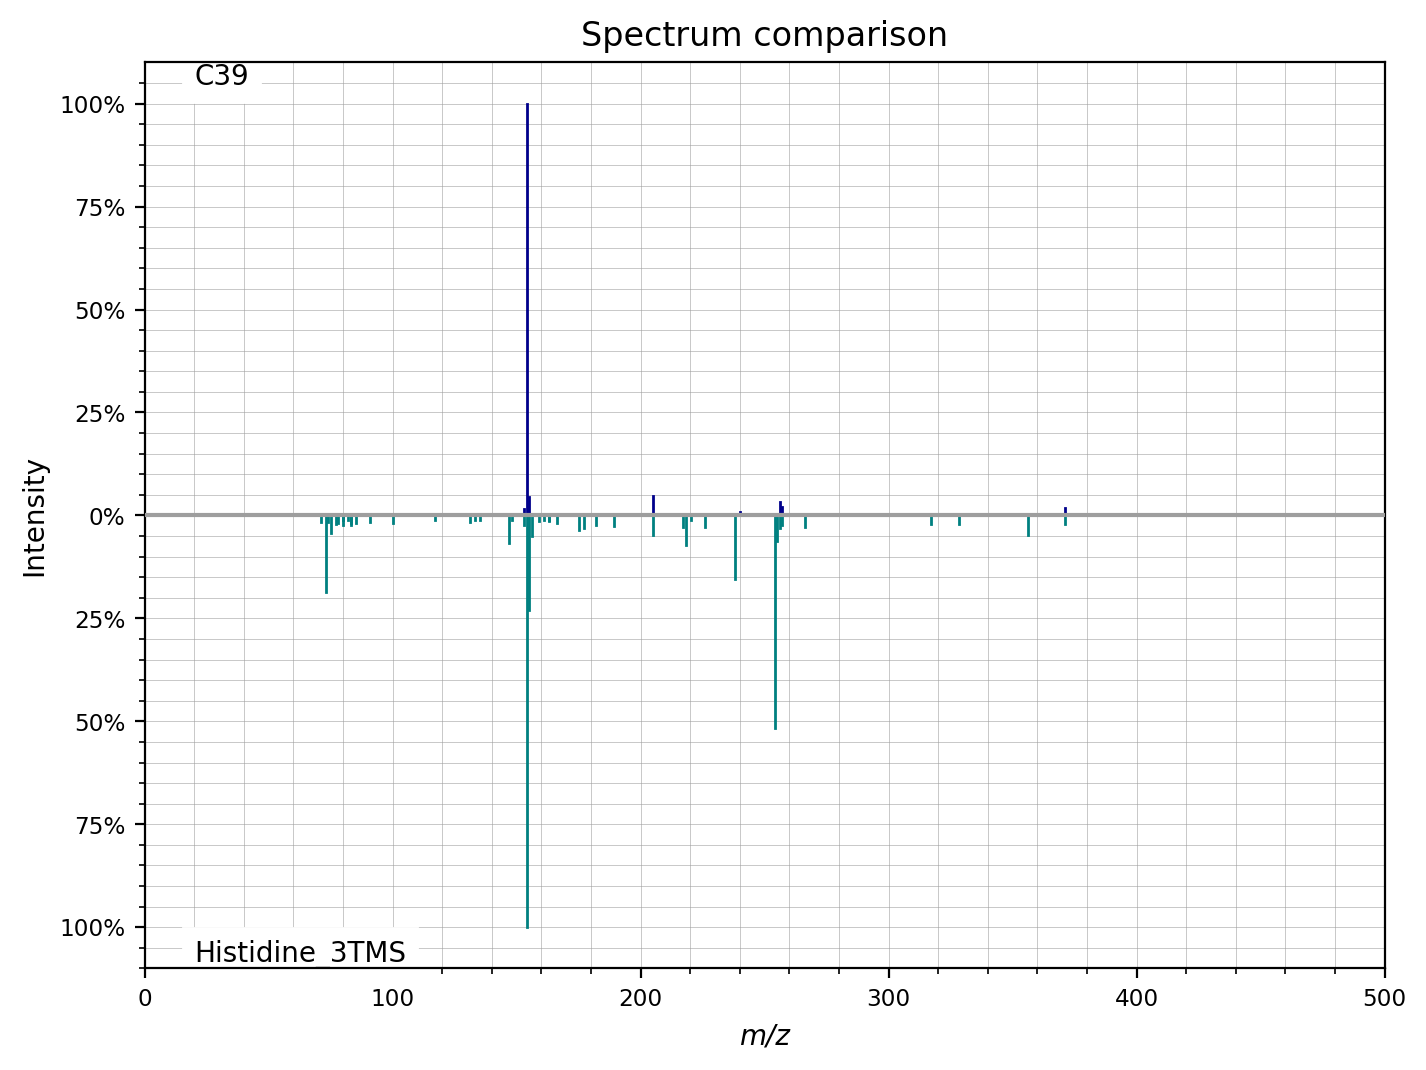

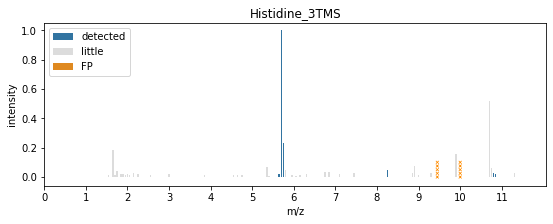

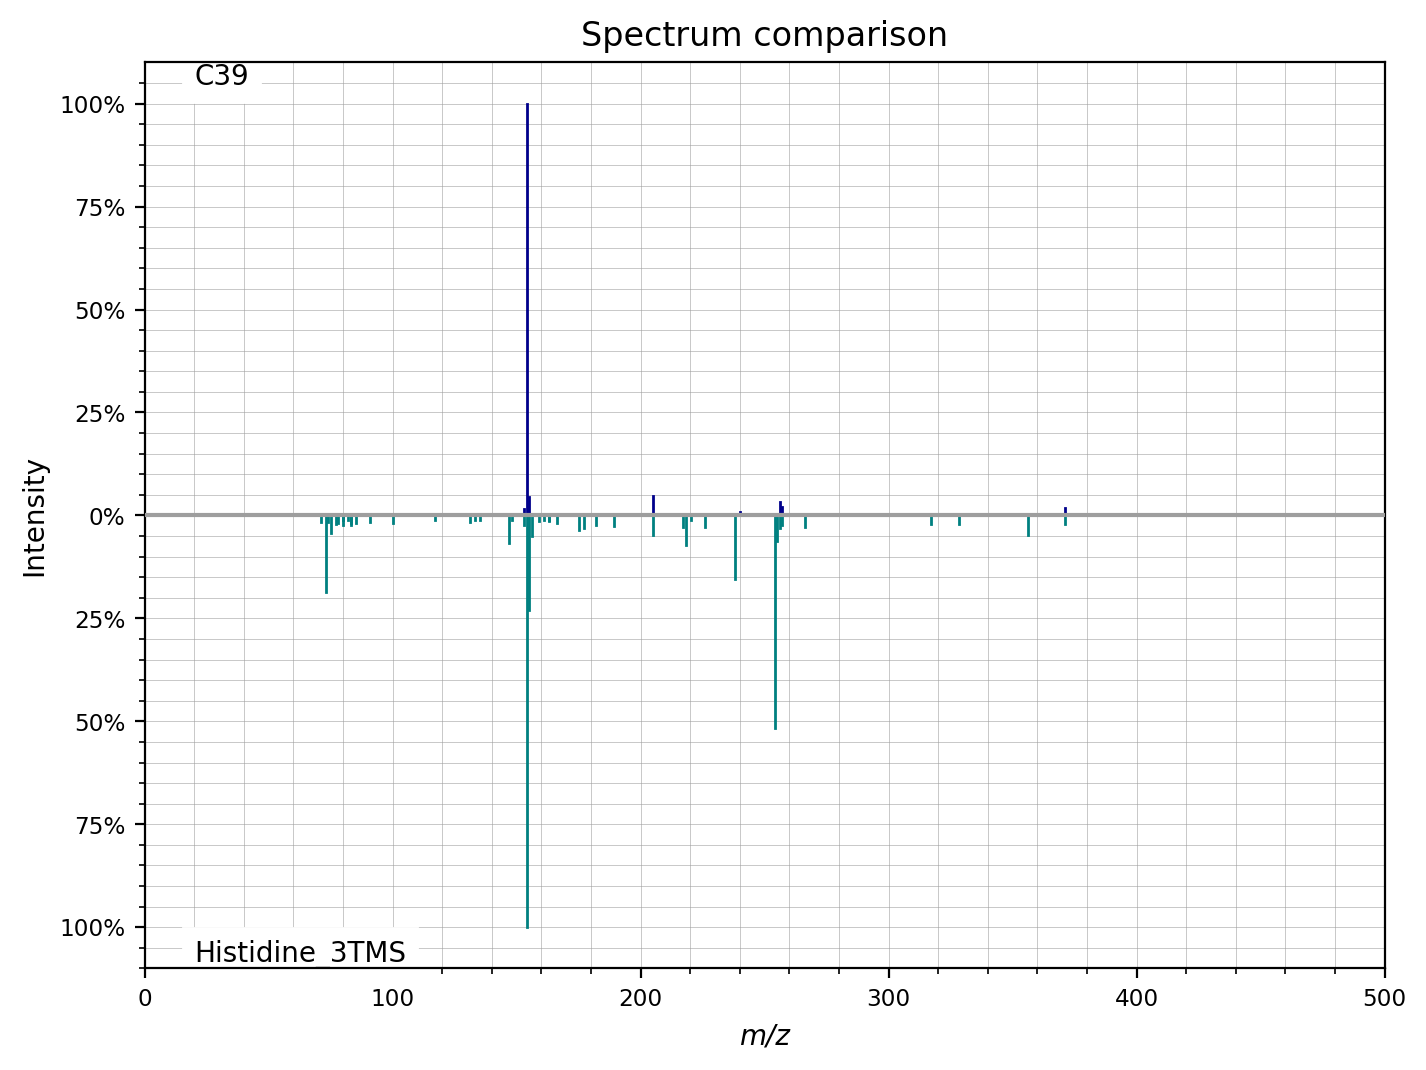

Spectrum C02 - detected peaks: 54
When matched to Pipecolinic acid_2TMS: 4 matched ions with 0.7553661382849925 total confidence
In this match, 40 peaks were not in library spectrum and 7 peaks from library spectrum were missing


In [ ]:
from collections import defaultdict
conc = "all"
def get_order(matched, conc=conc):
    repetition_counter = defaultdict(lambda: 0)
    order_dict = dict()
    for meas_id in matched[conc].id:
        order_dict[(meas_id, repetition_counter[meas_id])] = int(matched[conc].n_ions[matched[conc].id == meas_id].values[repetition_counter[meas_id]])    
        repetition_counter[meas_id] += 1
    return order_dict

ordered = get_order(matched, conc)
for c in reversed(sorted(ordered, key=lambda x: ordered[x])):
    spec, lib = couple_plot(c[0], measured, library, matched, conc=conc, repetition_count=c[1])
    spec.plot_against(lib, figsize=(8, 6))
    
    spec_enh,lib = couple_plot(c[0], measured, library, matched, conc=conc+"_enh", repetition_count=c[1])
    spec_enh.plot_against(lib, figsize=(8, 6))
    plt.show()

In [ ]:
ref = pd.read_csv("../data/11_KC_Confirmed_seminalplasma.csv.csv")
ref

In [ ]:
matched["all"]

In [ ]:
ground = set(ref["Metabolite name"])
pred = set(matched["all"].name) 

In [ ]:
from matplotlib_venn import venn2
venn2((pred, ground))

In [ ]:
from matchms import calculate_scores
from matchms.similarity import CosineHungarian

scores_orig = calculate_scores(
        references=list(library.values()),
        queries=list(measured["all"].values()),
        similarity_function=CosineHungarian(tolerance=0.1),
        is_symmetric=False
    )


In [ ]:
# MISSING RI FILTERING AND HI-RES STEP
scores = calculate_scores(
        references=list(library.values()),
        queries=list(enhanced["all"].values()),
        similarity_function=CosineHungarian(tolerance=0.003),
        is_symmetric=False
    )

In [ ]:

def get_outputs(args, scores):
    print("Storing outputs...")
    query_names = [spectra.metadata['compound_name'] for spectra in scores.queries]
    reference_names = [spectra.metadata['compound_name'] for spectra in scores.references]

    # Write scores to dataframe
    dataframe_scores = pd.DataFrame(data=[entry["score"] for entry in scores.scores], index=reference_names, columns=query_names)
    #dataframe_scores.to_csv(args.output_filename_scores, sep='\t')

    # Write number of matches to dataframe
    dataframe_matches = pd.DataFrame(data=[entry["matches"] for entry in scores.scores], index=reference_names, columns=query_names)
    #dataframe_matches.to_csv(args.output_filename_matches, sep='\t')

    return dataframe_scores, dataframe_matches

In [ ]:
sc, m = get_outputs(None, scores)
sc_, m_ = pd.read_csv(get_galaxy_filename('CosineHungarian scores', '../data'), sep="\t", index_col=0),  pd.read_csv(get_galaxy_filename('CosineHungarian matches', '../data'), sep="\t", index_col=0)

In [ ]:
m_.index

In [ ]:
p = set(m.index[((m > 6) & (sc > 0.7)).any(axis=1)])
venn2((p, ground))

In [ ]:
p_ = set(m_.index[((m_ > 6) & (sc_ > 0.7)).any(axis=1)])
venn2((p_, ground))

In [ ]:
orig = np.zeros(shape=(20, 10))
new = orig.copy()
for i, n_m in enumerate(range(1,21)):
    for j, n_s in enumerate(np.arange(0,1,0.1)):
        p_orig = set(m_.index[((m_ > n_m) & (sc_ > n_s)).any(axis=1)])
        p_new = set(m.index[((m > n_m) & (sc > n_s)).any(axis=1)])
        orig[i,j] = len(p_orig.intersection(ground))/len(p_orig.difference(ground)) if len(p_orig.difference(ground)) != 0 else 0
        new[i,j] = len(p_new.intersection(ground))/len(p_new.difference(ground)) if len(p_new.difference(ground)) != 0 else 0
        

In [ ]:
c = plt.contour(new, cmap='RdGy')
plt.clabel(c, inline=True, fontsize=8)

plt.colorbar()

In [ ]:
c = plt.contour(orig, cmap='RdGy')
plt.clabel(c, inline=True, fontsize=8)

plt.colorbar()


In [ ]:
new.sum()

In [ ]:
orig.sum()